In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout

In [2]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [3]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
1,Absol ex - 135/197,['Holofoil Market Price: '],8/2 to 8/4,$4.74
2,Absol ex - 135/197,['Holofoil Market Price: '],8/5 to 8/7,$4.74
3,Absol ex - 135/197,['Holofoil Market Price: '],8/8 to 8/10,$2.04
4,Absol ex - 135/197,['Holofoil Market Price: '],8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/19 to 10/21,$0.06
12926,Zigzagoon,[' Market Price: '],10/22 to 10/24,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/22 to 10/24,$0.05
12928,Zigzagoon,[' Market Price: '],10/25 to 10/27,$0.03


In [4]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [5]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [6]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 7.57% of the dataset has $0.00 market price

0.0757153905645785

In [7]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [8]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,$0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,$0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05


In [9]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [10]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
11946,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
11947,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
11948,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
11949,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [11]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

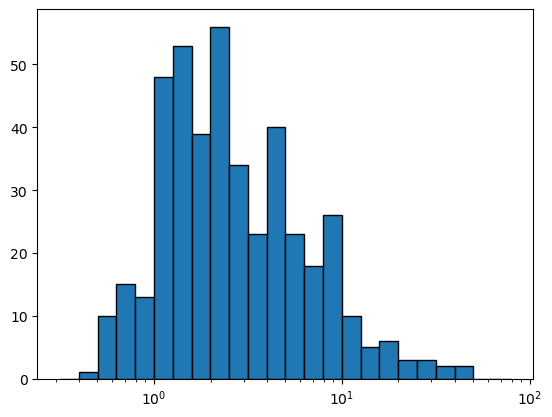

In [12]:
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [13]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 56% of the initial prices are more than double the latest price in the dataset

0.5627906976744186

In [14]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [15]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [16]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05,0.06,0.06


In [17]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.05


In [18]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


# Data Split

In [19]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'], dtype=object)

In [20]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 135/197,Holofoil,9/16 to 9/18,0.96,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,1.16,1.03,1.04,1.00,0.94
12,Absol ex - 135/197,Holofoil,9/19 to 9/21,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.96,1.16,1.03,1.04,1.00
13,Absol ex - 135/197,Holofoil,9/22 to 9/24,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,0.96,0.96,1.16,1.03,1.04
14,Absol ex - 135/197,Holofoil,9/25 to 9/27,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,1.03,1.08,0.96,0.96,1.16,1.03
15,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11


In [21]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
5494,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
5495,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
5496,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [22]:
of_cleaned.iloc[5884]

Product             Lillipup
Foil                  Normal
Date Range      8/23 to 8/25
Market Price            0.06
Name: 5884, dtype: object

In [23]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [24]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [25]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [26]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,0.167060
1,Previous Market Price_2,-0.074821
2,Previous Market Price_3,0.029078
3,Previous Market Price_4,-0.034503
4,Previous Market Price_5,-0.122030
5,Market Price,1.002076
6,Foil_Holofoil,-0.190213
7,Foil_Normal,0.061893
8,Foil_Reverse Holofoil,0.128320


In [27]:
y_pred = classifier.predict(X_test)

In [28]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [29]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9978
r2:  0.9978
MAE:  0.3416
MSE:  3.3686
RMSE:  1.8354


# LSTM

In [30]:
X_train = train[['Previous Market Price_5', 'Previous Market Price_4', 'Previous Market Price_3',
              'Previous Market Price_2', 'Previous Market Price_1', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_5', 'Previous Market Price_4', 'Previous Market Price_3',
              'Previous Market Price_2', 'Previous Market Price_1', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [31]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
5493    0.07
5494    0.08
5495    0.10
5496    0.11
5497    0.10
Name: Market Price, Length: 1720, dtype: float64

In [45]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063

model = Sequential()  
model.add(LSTM(2, input_dim=1, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 2)                 32        
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(X_train, y_train,epochs=10000, validation_data=(X_test, y_test))

Epoch 1/10000
54/54 [==============================] - 2s 10ms/step - loss: 1799.6638 - mean_squared_error: 1799.6638 - val_loss: 1561.0864 - val_mean_squared_error: 1561.0864
Epoch 2/10000
54/54 [==============================] - 0s 3ms/step - loss: 1799.3408 - mean_squared_error: 1799.3408 - val_loss: 1560.7705 - val_mean_squared_error: 1560.7705
Epoch 3/10000
54/54 [==============================] - 0s 3ms/step - loss: 1799.0610 - mean_squared_error: 1799.0610 - val_loss: 1560.4805 - val_mean_squared_error: 1560.4805
Epoch 4/10000
54/54 [==============================] - 0s 3ms/step - loss: 1798.7711 - mean_squared_error: 1798.7711 - val_loss: 1560.1766 - val_mean_squared_error: 1560.1766
Epoch 5/10000
54/54 [==============================] - 0s 3ms/step - loss: 1798.4888 - mean_squared_error: 1798.4888 - val_loss: 1559.9021 - val_mean_squared_error: 1559.9021
Epoch 6/10000
54/54 [==============================] - 0s 3ms/step - loss: 1798.2148 - mean_squared_error: 1798.2148 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1746.9907 - mean_squared_error: 1746.9907 - val_loss: 1506.5920 - val_mean_squared_error: 1506.5920
Epoch 48/10000
54/54 [==============================] - 0s 3ms/step - loss: 1746.3970 - mean_squared_error: 1746.3970 - val_loss: 1505.9739 - val_mean_squared_error: 1505.9739
Epoch 49/10000
54/54 [==============================] - 0s 3ms/step - loss: 1745.7529 - mean_squared_error: 1745.7529 - val_loss: 1505.3719 - val_mean_squared_error: 1505.3719
Epoch 50/10000
54/54 [==============================] - 0s 3ms/step - loss: 1745.2500 - mean_squared_error: 1745.2500 - val_loss: 1504.8224 - val_mean_squared_error: 1504.8224
Epoch 51/10000
54/54 [==============================] - 0s 3ms/step - loss: 1744.5847 - mean_squared_error: 1744.5847 - val_loss: 1504.0747 - val_mean_squared_error: 1504.0747
Epoch 52/10000
54/54 [==============================] - 0s 3ms/step - loss: 1743.8976 - mean_squared_error: 1743.8976 - val_loss: 1503.

54/54 [==============================] - 0s 3ms/step - loss: 1719.9506 - mean_squared_error: 1719.9506 - val_loss: 1478.6790 - val_mean_squared_error: 1478.6790
Epoch 94/10000
54/54 [==============================] - 0s 3ms/step - loss: 1719.4003 - mean_squared_error: 1719.4003 - val_loss: 1478.0791 - val_mean_squared_error: 1478.0791
Epoch 95/10000
54/54 [==============================] - 0s 3ms/step - loss: 1718.8158 - mean_squared_error: 1718.8158 - val_loss: 1477.4648 - val_mean_squared_error: 1477.4648
Epoch 96/10000
54/54 [==============================] - 0s 3ms/step - loss: 1718.2599 - mean_squared_error: 1718.2599 - val_loss: 1476.9039 - val_mean_squared_error: 1476.9039
Epoch 97/10000
54/54 [==============================] - 0s 3ms/step - loss: 1717.6526 - mean_squared_error: 1717.6526 - val_loss: 1476.2489 - val_mean_squared_error: 1476.2489
Epoch 98/10000
54/54 [==============================] - 0s 3ms/step - loss: 1717.1003 - mean_squared_error: 1717.1003 - val_loss: 1475.

54/54 [==============================] - 0s 3ms/step - loss: 1694.7972 - mean_squared_error: 1694.7972 - val_loss: 1452.5847 - val_mean_squared_error: 1452.5847
Epoch 140/10000
54/54 [==============================] - 0s 3ms/step - loss: 1694.2302 - mean_squared_error: 1694.2302 - val_loss: 1451.9939 - val_mean_squared_error: 1451.9939
Epoch 141/10000
54/54 [==============================] - 0s 3ms/step - loss: 1693.6991 - mean_squared_error: 1693.6991 - val_loss: 1451.4465 - val_mean_squared_error: 1451.4465
Epoch 142/10000
54/54 [==============================] - 0s 3ms/step - loss: 1693.0663 - mean_squared_error: 1693.0663 - val_loss: 1450.8003 - val_mean_squared_error: 1450.8003
Epoch 143/10000
54/54 [==============================] - 0s 3ms/step - loss: 1692.5421 - mean_squared_error: 1692.5421 - val_loss: 1450.2555 - val_mean_squared_error: 1450.2555
Epoch 144/10000
54/54 [==============================] - 0s 3ms/step - loss: 1692.0341 - mean_squared_error: 1692.0341 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1670.8625 - mean_squared_error: 1670.8625 - val_loss: 1427.8610 - val_mean_squared_error: 1427.8610
Epoch 186/10000
54/54 [==============================] - 0s 3ms/step - loss: 1670.3358 - mean_squared_error: 1670.3358 - val_loss: 1427.3156 - val_mean_squared_error: 1427.3156
Epoch 187/10000
54/54 [==============================] - 0s 3ms/step - loss: 1669.8241 - mean_squared_error: 1669.8241 - val_loss: 1426.7795 - val_mean_squared_error: 1426.7795
Epoch 188/10000
54/54 [==============================] - 0s 3ms/step - loss: 1669.2993 - mean_squared_error: 1669.2993 - val_loss: 1426.2797 - val_mean_squared_error: 1426.2797
Epoch 189/10000
54/54 [==============================] - 0s 3ms/step - loss: 1668.8722 - mean_squared_error: 1668.8722 - val_loss: 1425.8250 - val_mean_squared_error: 1425.8250
Epoch 190/10000
54/54 [==============================] - 0s 3ms/step - loss: 1668.3390 - mean_squared_error: 1668.3390 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1648.3119 - mean_squared_error: 1648.3119 - val_loss: 1404.5477 - val_mean_squared_error: 1404.5477
Epoch 232/10000
54/54 [==============================] - 0s 3ms/step - loss: 1647.7820 - mean_squared_error: 1647.7820 - val_loss: 1404.0061 - val_mean_squared_error: 1404.0061
Epoch 233/10000
54/54 [==============================] - 0s 3ms/step - loss: 1647.3052 - mean_squared_error: 1647.3052 - val_loss: 1403.5100 - val_mean_squared_error: 1403.5100
Epoch 234/10000
54/54 [==============================] - 0s 3ms/step - loss: 1646.8788 - mean_squared_error: 1646.8788 - val_loss: 1403.1262 - val_mean_squared_error: 1403.1262
Epoch 235/10000
54/54 [==============================] - 0s 3ms/step - loss: 1646.4225 - mean_squared_error: 1646.4225 - val_loss: 1402.5865 - val_mean_squared_error: 1402.5865
Epoch 236/10000
54/54 [==============================] - 0s 3ms/step - loss: 1645.8829 - mean_squared_error: 1645.8829 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1626.3303 - mean_squared_error: 1626.3303 - val_loss: 1381.8411 - val_mean_squared_error: 1381.8411
Epoch 278/10000
54/54 [==============================] - 0s 3ms/step - loss: 1625.8850 - mean_squared_error: 1625.8850 - val_loss: 1381.3856 - val_mean_squared_error: 1381.3856
Epoch 279/10000
54/54 [==============================] - 0s 3ms/step - loss: 1625.4207 - mean_squared_error: 1625.4207 - val_loss: 1380.9043 - val_mean_squared_error: 1380.9043
Epoch 280/10000
54/54 [==============================] - 0s 3ms/step - loss: 1624.9283 - mean_squared_error: 1624.9283 - val_loss: 1380.4120 - val_mean_squared_error: 1380.4120
Epoch 281/10000
54/54 [==============================] - 0s 3ms/step - loss: 1624.4711 - mean_squared_error: 1624.4711 - val_loss: 1379.8898 - val_mean_squared_error: 1379.8898
Epoch 282/10000
54/54 [==============================] - 0s 3ms/step - loss: 1623.9452 - mean_squared_error: 1623.9452 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1605.1168 - mean_squared_error: 1605.1168 - val_loss: 1359.9232 - val_mean_squared_error: 1359.9232
Epoch 324/10000
54/54 [==============================] - 0s 3ms/step - loss: 1604.6884 - mean_squared_error: 1604.6884 - val_loss: 1359.4244 - val_mean_squared_error: 1359.4244
Epoch 325/10000
54/54 [==============================] - 0s 3ms/step - loss: 1604.2030 - mean_squared_error: 1604.2030 - val_loss: 1358.9392 - val_mean_squared_error: 1358.9392
Epoch 326/10000
54/54 [==============================] - 0s 3ms/step - loss: 1603.8141 - mean_squared_error: 1603.8141 - val_loss: 1358.5406 - val_mean_squared_error: 1358.5406
Epoch 327/10000
54/54 [==============================] - 0s 3ms/step - loss: 1603.3514 - mean_squared_error: 1603.3514 - val_loss: 1358.1001 - val_mean_squared_error: 1358.1001
Epoch 328/10000
54/54 [==============================] - 0s 3ms/step - loss: 1602.9608 - mean_squared_error: 1602.9608 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1584.9927 - mean_squared_error: 1584.9927 - val_loss: 1338.9845 - val_mean_squared_error: 1338.9845
Epoch 370/10000
54/54 [==============================] - 0s 3ms/step - loss: 1584.5542 - mean_squared_error: 1584.5542 - val_loss: 1338.5845 - val_mean_squared_error: 1338.5845
Epoch 371/10000
54/54 [==============================] - 0s 3ms/step - loss: 1584.0916 - mean_squared_error: 1584.0916 - val_loss: 1338.1034 - val_mean_squared_error: 1338.1034
Epoch 372/10000
54/54 [==============================] - 0s 3ms/step - loss: 1583.6519 - mean_squared_error: 1583.6519 - val_loss: 1337.6394 - val_mean_squared_error: 1337.6394
Epoch 373/10000
54/54 [==============================] - 0s 3ms/step - loss: 1583.1931 - mean_squared_error: 1583.1931 - val_loss: 1337.1791 - val_mean_squared_error: 1337.1791
Epoch 374/10000
54/54 [==============================] - 0s 3ms/step - loss: 1582.7810 - mean_squared_error: 1582.7810 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1565.0852 - mean_squared_error: 1565.0852 - val_loss: 1318.5068 - val_mean_squared_error: 1318.5068
Epoch 416/10000
54/54 [==============================] - 0s 3ms/step - loss: 1564.6661 - mean_squared_error: 1564.6661 - val_loss: 1318.0796 - val_mean_squared_error: 1318.0796
Epoch 417/10000
54/54 [==============================] - 0s 3ms/step - loss: 1564.2584 - mean_squared_error: 1564.2584 - val_loss: 1317.6562 - val_mean_squared_error: 1317.6562
Epoch 418/10000
54/54 [==============================] - 0s 3ms/step - loss: 1563.8466 - mean_squared_error: 1563.8466 - val_loss: 1317.2416 - val_mean_squared_error: 1317.2416
Epoch 419/10000
54/54 [==============================] - 0s 3ms/step - loss: 1563.4421 - mean_squared_error: 1563.4421 - val_loss: 1316.8112 - val_mean_squared_error: 1316.8112
Epoch 420/10000
54/54 [==============================] - 0s 3ms/step - loss: 1563.0018 - mean_squared_error: 1563.0018 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1546.1064 - mean_squared_error: 1546.1064 - val_loss: 1298.9994 - val_mean_squared_error: 1298.9994
Epoch 462/10000
54/54 [==============================] - 0s 3ms/step - loss: 1545.6622 - mean_squared_error: 1545.6622 - val_loss: 1298.5603 - val_mean_squared_error: 1298.5603
Epoch 463/10000
54/54 [==============================] - 0s 3ms/step - loss: 1545.1936 - mean_squared_error: 1545.1936 - val_loss: 1298.0378 - val_mean_squared_error: 1298.0378
Epoch 464/10000
54/54 [==============================] - 0s 3ms/step - loss: 1544.7881 - mean_squared_error: 1544.7881 - val_loss: 1297.6501 - val_mean_squared_error: 1297.6501
Epoch 465/10000
54/54 [==============================] - 0s 3ms/step - loss: 1544.3942 - mean_squared_error: 1544.3942 - val_loss: 1297.2313 - val_mean_squared_error: 1297.2313
Epoch 466/10000
54/54 [==============================] - 0s 3ms/step - loss: 1544.0006 - mean_squared_error: 1544.0006 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1527.7469 - mean_squared_error: 1527.7469 - val_loss: 1280.1454 - val_mean_squared_error: 1280.1454
Epoch 508/10000
54/54 [==============================] - 0s 3ms/step - loss: 1527.2837 - mean_squared_error: 1527.2837 - val_loss: 1279.6924 - val_mean_squared_error: 1279.6924
Epoch 509/10000
54/54 [==============================] - 0s 3ms/step - loss: 1526.9313 - mean_squared_error: 1526.9313 - val_loss: 1279.3103 - val_mean_squared_error: 1279.3103
Epoch 510/10000
54/54 [==============================] - 0s 3ms/step - loss: 1526.5266 - mean_squared_error: 1526.5266 - val_loss: 1278.8844 - val_mean_squared_error: 1278.8844
Epoch 511/10000
54/54 [==============================] - 0s 3ms/step - loss: 1526.1091 - mean_squared_error: 1526.1091 - val_loss: 1278.5580 - val_mean_squared_error: 1278.5580
Epoch 512/10000
54/54 [==============================] - 0s 3ms/step - loss: 1525.7417 - mean_squared_error: 1525.7417 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1509.9454 - mean_squared_error: 1509.9454 - val_loss: 1261.9028 - val_mean_squared_error: 1261.9028
Epoch 554/10000
54/54 [==============================] - 0s 3ms/step - loss: 1509.6011 - mean_squared_error: 1509.6011 - val_loss: 1261.5250 - val_mean_squared_error: 1261.5250
Epoch 555/10000
54/54 [==============================] - 0s 3ms/step - loss: 1509.2334 - mean_squared_error: 1509.2334 - val_loss: 1261.2297 - val_mean_squared_error: 1261.2297
Epoch 556/10000
54/54 [==============================] - 0s 3ms/step - loss: 1508.9076 - mean_squared_error: 1508.9076 - val_loss: 1260.8740 - val_mean_squared_error: 1260.8740
Epoch 557/10000
54/54 [==============================] - 0s 3ms/step - loss: 1508.5144 - mean_squared_error: 1508.5144 - val_loss: 1260.4290 - val_mean_squared_error: 1260.4290
Epoch 558/10000
54/54 [==============================] - 0s 3ms/step - loss: 1508.1228 - mean_squared_error: 1508.1228 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1492.3036 - mean_squared_error: 1492.3036 - val_loss: 1243.9858 - val_mean_squared_error: 1243.9858
Epoch 600/10000
54/54 [==============================] - 0s 3ms/step - loss: 1491.9207 - mean_squared_error: 1491.9207 - val_loss: 1243.5436 - val_mean_squared_error: 1243.5436
Epoch 601/10000
54/54 [==============================] - 0s 3ms/step - loss: 1491.5116 - mean_squared_error: 1491.5116 - val_loss: 1243.1613 - val_mean_squared_error: 1243.1613
Epoch 602/10000
54/54 [==============================] - 0s 3ms/step - loss: 1491.1630 - mean_squared_error: 1491.1630 - val_loss: 1242.7506 - val_mean_squared_error: 1242.7506
Epoch 603/10000
54/54 [==============================] - 0s 3ms/step - loss: 1490.7705 - mean_squared_error: 1490.7705 - val_loss: 1242.3363 - val_mean_squared_error: 1242.3363
Epoch 604/10000
54/54 [==============================] - 0s 3ms/step - loss: 1490.4203 - mean_squared_error: 1490.4203 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1474.8551 - mean_squared_error: 1474.8551 - val_loss: 1226.1149 - val_mean_squared_error: 1226.1149
Epoch 646/10000
54/54 [==============================] - 0s 3ms/step - loss: 1474.5349 - mean_squared_error: 1474.5349 - val_loss: 1225.7971 - val_mean_squared_error: 1225.7971
Epoch 647/10000
54/54 [==============================] - 0s 3ms/step - loss: 1474.1542 - mean_squared_error: 1474.1542 - val_loss: 1225.3672 - val_mean_squared_error: 1225.3672
Epoch 648/10000
54/54 [==============================] - 0s 3ms/step - loss: 1473.7683 - mean_squared_error: 1473.7683 - val_loss: 1224.9618 - val_mean_squared_error: 1224.9618
Epoch 649/10000
54/54 [==============================] - 0s 3ms/step - loss: 1473.3888 - mean_squared_error: 1473.3888 - val_loss: 1224.6353 - val_mean_squared_error: 1224.6353
Epoch 650/10000
54/54 [==============================] - 0s 3ms/step - loss: 1473.0085 - mean_squared_error: 1473.0085 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1458.1545 - mean_squared_error: 1458.1545 - val_loss: 1209.1661 - val_mean_squared_error: 1209.1661
Epoch 692/10000
54/54 [==============================] - 0s 3ms/step - loss: 1457.7852 - mean_squared_error: 1457.7852 - val_loss: 1208.6998 - val_mean_squared_error: 1208.6998
Epoch 693/10000
54/54 [==============================] - 0s 3ms/step - loss: 1457.4084 - mean_squared_error: 1457.4084 - val_loss: 1208.4004 - val_mean_squared_error: 1208.4004
Epoch 694/10000
54/54 [==============================] - 0s 3ms/step - loss: 1457.0082 - mean_squared_error: 1457.0082 - val_loss: 1208.0536 - val_mean_squared_error: 1208.0536
Epoch 695/10000
54/54 [==============================] - 0s 3ms/step - loss: 1456.6567 - mean_squared_error: 1456.6567 - val_loss: 1207.5590 - val_mean_squared_error: 1207.5590
Epoch 696/10000
54/54 [==============================] - 0s 3ms/step - loss: 1456.3282 - mean_squared_error: 1456.3282 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1441.7849 - mean_squared_error: 1441.7849 - val_loss: 1192.5038 - val_mean_squared_error: 1192.5038
Epoch 738/10000
54/54 [==============================] - 0s 3ms/step - loss: 1441.3820 - mean_squared_error: 1441.3820 - val_loss: 1192.0848 - val_mean_squared_error: 1192.0848
Epoch 739/10000
54/54 [==============================] - 0s 3ms/step - loss: 1441.0154 - mean_squared_error: 1441.0154 - val_loss: 1191.7476 - val_mean_squared_error: 1191.7476
Epoch 740/10000
54/54 [==============================] - 0s 3ms/step - loss: 1440.6088 - mean_squared_error: 1440.6088 - val_loss: 1191.2288 - val_mean_squared_error: 1191.2288
Epoch 741/10000
54/54 [==============================] - 0s 3ms/step - loss: 1440.2765 - mean_squared_error: 1440.2765 - val_loss: 1190.9919 - val_mean_squared_error: 1190.9919
Epoch 742/10000
54/54 [==============================] - 0s 3ms/step - loss: 1439.9274 - mean_squared_error: 1439.9274 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1425.8245 - mean_squared_error: 1425.8245 - val_loss: 1176.5094 - val_mean_squared_error: 1176.5094
Epoch 784/10000
54/54 [==============================] - 0s 3ms/step - loss: 1425.4523 - mean_squared_error: 1425.4523 - val_loss: 1176.0820 - val_mean_squared_error: 1176.0820
Epoch 785/10000
54/54 [==============================] - 0s 3ms/step - loss: 1425.0834 - mean_squared_error: 1425.0834 - val_loss: 1175.7389 - val_mean_squared_error: 1175.7389
Epoch 786/10000
54/54 [==============================] - 0s 3ms/step - loss: 1424.7471 - mean_squared_error: 1424.7471 - val_loss: 1175.3683 - val_mean_squared_error: 1175.3683
Epoch 787/10000
54/54 [==============================] - 0s 3ms/step - loss: 1424.3834 - mean_squared_error: 1424.3834 - val_loss: 1174.9000 - val_mean_squared_error: 1174.9000
Epoch 788/10000
54/54 [==============================] - 0s 3ms/step - loss: 1424.0054 - mean_squared_error: 1424.0054 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1410.0016 - mean_squared_error: 1410.0016 - val_loss: 1160.6512 - val_mean_squared_error: 1160.6512
Epoch 830/10000
54/54 [==============================] - 0s 3ms/step - loss: 1409.6229 - mean_squared_error: 1409.6229 - val_loss: 1160.1821 - val_mean_squared_error: 1160.1821
Epoch 831/10000
54/54 [==============================] - 0s 3ms/step - loss: 1409.2949 - mean_squared_error: 1409.2949 - val_loss: 1159.7939 - val_mean_squared_error: 1159.7939
Epoch 832/10000
54/54 [==============================] - 0s 3ms/step - loss: 1408.9674 - mean_squared_error: 1408.9674 - val_loss: 1159.4583 - val_mean_squared_error: 1159.4583
Epoch 833/10000
54/54 [==============================] - 0s 3ms/step - loss: 1408.6461 - mean_squared_error: 1408.6461 - val_loss: 1159.2561 - val_mean_squared_error: 1159.2561
Epoch 834/10000
54/54 [==============================] - 0s 4ms/step - loss: 1408.2977 - mean_squared_error: 1408.2977 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1394.8424 - mean_squared_error: 1394.8424 - val_loss: 1145.3118 - val_mean_squared_error: 1145.3118
Epoch 876/10000
54/54 [==============================] - 0s 3ms/step - loss: 1394.5641 - mean_squared_error: 1394.5641 - val_loss: 1145.1313 - val_mean_squared_error: 1145.1313
Epoch 877/10000
54/54 [==============================] - 0s 3ms/step - loss: 1394.1981 - mean_squared_error: 1394.1981 - val_loss: 1144.6720 - val_mean_squared_error: 1144.6720
Epoch 878/10000
54/54 [==============================] - 0s 3ms/step - loss: 1393.8567 - mean_squared_error: 1393.8567 - val_loss: 1144.3782 - val_mean_squared_error: 1144.3782
Epoch 879/10000
54/54 [==============================] - 0s 3ms/step - loss: 1393.5503 - mean_squared_error: 1393.5503 - val_loss: 1143.9818 - val_mean_squared_error: 1143.9818
Epoch 880/10000
54/54 [==============================] - 0s 3ms/step - loss: 1393.2502 - mean_squared_error: 1393.2502 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1379.8484 - mean_squared_error: 1379.8484 - val_loss: 1130.3904 - val_mean_squared_error: 1130.3904
Epoch 922/10000
54/54 [==============================] - 0s 3ms/step - loss: 1379.5355 - mean_squared_error: 1379.5355 - val_loss: 1130.1119 - val_mean_squared_error: 1130.1119
Epoch 923/10000
54/54 [==============================] - 0s 3ms/step - loss: 1379.2131 - mean_squared_error: 1379.2131 - val_loss: 1129.7002 - val_mean_squared_error: 1129.7002
Epoch 924/10000
54/54 [==============================] - 0s 3ms/step - loss: 1378.8337 - mean_squared_error: 1378.8337 - val_loss: 1129.4843 - val_mean_squared_error: 1129.4843
Epoch 925/10000
54/54 [==============================] - 0s 3ms/step - loss: 1378.5717 - mean_squared_error: 1378.5717 - val_loss: 1128.9999 - val_mean_squared_error: 1128.9999
Epoch 926/10000
54/54 [==============================] - 0s 3ms/step - loss: 1378.2264 - mean_squared_error: 1378.2264 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1365.3710 - mean_squared_error: 1365.3710 - val_loss: 1115.6567 - val_mean_squared_error: 1115.6567
Epoch 968/10000
54/54 [==============================] - 0s 3ms/step - loss: 1365.0439 - mean_squared_error: 1365.0439 - val_loss: 1115.2833 - val_mean_squared_error: 1115.2833
Epoch 969/10000
54/54 [==============================] - 0s 3ms/step - loss: 1364.7373 - mean_squared_error: 1364.7373 - val_loss: 1115.4625 - val_mean_squared_error: 1115.4625
Epoch 970/10000
54/54 [==============================] - 0s 3ms/step - loss: 1364.4625 - mean_squared_error: 1364.4625 - val_loss: 1114.8699 - val_mean_squared_error: 1114.8699
Epoch 971/10000
54/54 [==============================] - 0s 3ms/step - loss: 1364.2104 - mean_squared_error: 1364.2104 - val_loss: 1114.7169 - val_mean_squared_error: 1114.7169
Epoch 972/10000
54/54 [==============================] - 0s 3ms/step - loss: 1363.9166 - mean_squared_error: 1363.9166 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1350.9556 - mean_squared_error: 1350.9556 - val_loss: 1101.5656 - val_mean_squared_error: 1101.5656
Epoch 1014/10000
54/54 [==============================] - 0s 3ms/step - loss: 1350.6403 - mean_squared_error: 1350.6403 - val_loss: 1101.2225 - val_mean_squared_error: 1101.2225
Epoch 1015/10000
54/54 [==============================] - 0s 3ms/step - loss: 1350.3241 - mean_squared_error: 1350.3241 - val_loss: 1100.7375 - val_mean_squared_error: 1100.7375
Epoch 1016/10000
54/54 [==============================] - 0s 3ms/step - loss: 1349.9984 - mean_squared_error: 1349.9984 - val_loss: 1100.4744 - val_mean_squared_error: 1100.4744
Epoch 1017/10000
54/54 [==============================] - 0s 3ms/step - loss: 1349.6638 - mean_squared_error: 1349.6638 - val_loss: 1100.1199 - val_mean_squared_error: 1100.1199
Epoch 1018/10000
54/54 [==============================] - 0s 3ms/step - loss: 1349.3397 - mean_squared_error: 1349.3397 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1337.0929 - mean_squared_error: 1337.0929 - val_loss: 1087.9438 - val_mean_squared_error: 1087.9438
Epoch 1060/10000
54/54 [==============================] - 0s 3ms/step - loss: 1336.7770 - mean_squared_error: 1336.7770 - val_loss: 1087.3253 - val_mean_squared_error: 1087.3253
Epoch 1061/10000
54/54 [==============================] - 0s 3ms/step - loss: 1336.4465 - mean_squared_error: 1336.4465 - val_loss: 1086.9923 - val_mean_squared_error: 1086.9923
Epoch 1062/10000
54/54 [==============================] - 0s 3ms/step - loss: 1336.1144 - mean_squared_error: 1336.1144 - val_loss: 1086.7479 - val_mean_squared_error: 1086.7479
Epoch 1063/10000
54/54 [==============================] - 0s 3ms/step - loss: 1335.8237 - mean_squared_error: 1335.8237 - val_loss: 1086.3993 - val_mean_squared_error: 1086.3993
Epoch 1064/10000
54/54 [==============================] - 0s 3ms/step - loss: 1335.5703 - mean_squared_error: 1335.5703 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1323.4172 - mean_squared_error: 1323.4172 - val_loss: 1074.3101 - val_mean_squared_error: 1074.3101
Epoch 1106/10000
54/54 [==============================] - 0s 3ms/step - loss: 1323.1426 - mean_squared_error: 1323.1426 - val_loss: 1073.8752 - val_mean_squared_error: 1073.8752
Epoch 1107/10000
54/54 [==============================] - 0s 3ms/step - loss: 1322.8567 - mean_squared_error: 1322.8567 - val_loss: 1073.3318 - val_mean_squared_error: 1073.3318
Epoch 1108/10000
54/54 [==============================] - 0s 3ms/step - loss: 1322.5372 - mean_squared_error: 1322.5372 - val_loss: 1073.6553 - val_mean_squared_error: 1073.6553
Epoch 1109/10000
54/54 [==============================] - 0s 3ms/step - loss: 1322.2430 - mean_squared_error: 1322.2430 - val_loss: 1073.1155 - val_mean_squared_error: 1073.1155
Epoch 1110/10000
54/54 [==============================] - 0s 3ms/step - loss: 1321.9924 - mean_squared_error: 1321.9924 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1310.1964 - mean_squared_error: 1310.1964 - val_loss: 1060.6704 - val_mean_squared_error: 1060.6704
Epoch 1152/10000
54/54 [==============================] - 0s 3ms/step - loss: 1309.9658 - mean_squared_error: 1309.9658 - val_loss: 1060.8845 - val_mean_squared_error: 1060.8845
Epoch 1153/10000
54/54 [==============================] - 0s 3ms/step - loss: 1309.7289 - mean_squared_error: 1309.7289 - val_loss: 1060.6108 - val_mean_squared_error: 1060.6108
Epoch 1154/10000
54/54 [==============================] - 0s 3ms/step - loss: 1309.5094 - mean_squared_error: 1309.5094 - val_loss: 1060.0642 - val_mean_squared_error: 1060.0642
Epoch 1155/10000
54/54 [==============================] - 0s 3ms/step - loss: 1309.1858 - mean_squared_error: 1309.1858 - val_loss: 1060.3167 - val_mean_squared_error: 1060.3167
Epoch 1156/10000
54/54 [==============================] - 0s 3ms/step - loss: 1308.8866 - mean_squared_error: 1308.8866 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1297.2852 - mean_squared_error: 1297.2852 - val_loss: 1047.3680 - val_mean_squared_error: 1047.3680
Epoch 1198/10000
54/54 [==============================] - 0s 3ms/step - loss: 1296.9725 - mean_squared_error: 1296.9725 - val_loss: 1047.1746 - val_mean_squared_error: 1047.1746
Epoch 1199/10000
54/54 [==============================] - 0s 3ms/step - loss: 1296.6893 - mean_squared_error: 1296.6893 - val_loss: 1046.7861 - val_mean_squared_error: 1046.7861
Epoch 1200/10000
54/54 [==============================] - 0s 4ms/step - loss: 1296.4427 - mean_squared_error: 1296.4427 - val_loss: 1046.8020 - val_mean_squared_error: 1046.8020
Epoch 1201/10000
54/54 [==============================] - 0s 3ms/step - loss: 1296.1901 - mean_squared_error: 1296.1901 - val_loss: 1046.3398 - val_mean_squared_error: 1046.3398
Epoch 1202/10000
54/54 [==============================] - 0s 3ms/step - loss: 1295.9622 - mean_squared_error: 1295.9622 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1284.3168 - mean_squared_error: 1284.3168 - val_loss: 1032.2200 - val_mean_squared_error: 1032.2200
Epoch 1244/10000
54/54 [==============================] - 0s 3ms/step - loss: 1284.0493 - mean_squared_error: 1284.0493 - val_loss: 1031.8318 - val_mean_squared_error: 1031.8318
Epoch 1245/10000
54/54 [==============================] - 0s 3ms/step - loss: 1283.7555 - mean_squared_error: 1283.7555 - val_loss: 1031.6001 - val_mean_squared_error: 1031.6001
Epoch 1246/10000
54/54 [==============================] - 0s 3ms/step - loss: 1283.5360 - mean_squared_error: 1283.5360 - val_loss: 1031.1599 - val_mean_squared_error: 1031.1599
Epoch 1247/10000
54/54 [==============================] - 0s 3ms/step - loss: 1283.3076 - mean_squared_error: 1283.3076 - val_loss: 1030.9370 - val_mean_squared_error: 1030.9370
Epoch 1248/10000
54/54 [==============================] - 0s 3ms/step - loss: 1282.9343 - mean_squared_error: 1282.9343 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1271.5083 - mean_squared_error: 1271.5083 - val_loss: 1019.3764 - val_mean_squared_error: 1019.3764
Epoch 1290/10000
54/54 [==============================] - 0s 3ms/step - loss: 1271.3101 - mean_squared_error: 1271.3101 - val_loss: 1019.0035 - val_mean_squared_error: 1019.0035
Epoch 1291/10000
54/54 [==============================] - 0s 3ms/step - loss: 1271.0345 - mean_squared_error: 1271.0345 - val_loss: 1018.4886 - val_mean_squared_error: 1018.4886
Epoch 1292/10000
54/54 [==============================] - 0s 3ms/step - loss: 1270.7853 - mean_squared_error: 1270.7853 - val_loss: 1018.2500 - val_mean_squared_error: 1018.2500
Epoch 1293/10000
54/54 [==============================] - 0s 3ms/step - loss: 1270.5001 - mean_squared_error: 1270.5001 - val_loss: 1017.9423 - val_mean_squared_error: 1017.9423
Epoch 1294/10000
54/54 [==============================] - 0s 3ms/step - loss: 1270.2881 - mean_squared_error: 1270.2881 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1259.1842 - mean_squared_error: 1259.1842 - val_loss: 1006.3935 - val_mean_squared_error: 1006.3935
Epoch 1336/10000
54/54 [==============================] - 0s 3ms/step - loss: 1258.8386 - mean_squared_error: 1258.8386 - val_loss: 1006.1573 - val_mean_squared_error: 1006.1573
Epoch 1337/10000
54/54 [==============================] - 0s 3ms/step - loss: 1258.5543 - mean_squared_error: 1258.5543 - val_loss: 1005.7682 - val_mean_squared_error: 1005.7682
Epoch 1338/10000
54/54 [==============================] - 0s 3ms/step - loss: 1258.2728 - mean_squared_error: 1258.2728 - val_loss: 1005.5021 - val_mean_squared_error: 1005.5021
Epoch 1339/10000
54/54 [==============================] - 0s 3ms/step - loss: 1258.0590 - mean_squared_error: 1258.0590 - val_loss: 1005.2635 - val_mean_squared_error: 1005.2635
Epoch 1340/10000
54/54 [==============================] - 0s 3ms/step - loss: 1257.6770 - mean_squared_error: 1257.6770 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1246.4017 - mean_squared_error: 1246.4017 - val_loss: 993.5155 - val_mean_squared_error: 993.5155
Epoch 1382/10000
54/54 [==============================] - 0s 3ms/step - loss: 1246.1685 - mean_squared_error: 1246.1685 - val_loss: 993.2318 - val_mean_squared_error: 993.2318
Epoch 1383/10000
54/54 [==============================] - 0s 3ms/step - loss: 1245.7399 - mean_squared_error: 1245.7399 - val_loss: 993.2070 - val_mean_squared_error: 993.2070
Epoch 1384/10000
54/54 [==============================] - 0s 3ms/step - loss: 1245.5222 - mean_squared_error: 1245.5222 - val_loss: 992.6230 - val_mean_squared_error: 992.6230
Epoch 1385/10000
54/54 [==============================] - 0s 3ms/step - loss: 1245.2749 - mean_squared_error: 1245.2749 - val_loss: 992.3254 - val_mean_squared_error: 992.3254
Epoch 1386/10000
54/54 [==============================] - 0s 3ms/step - loss: 1244.9644 - mean_squared_error: 1244.9644 - val_loss: 992.1

54/54 [==============================] - 0s 3ms/step - loss: 1233.7996 - mean_squared_error: 1233.7996 - val_loss: 980.8442 - val_mean_squared_error: 980.8442
Epoch 1428/10000
54/54 [==============================] - 0s 3ms/step - loss: 1233.5680 - mean_squared_error: 1233.5680 - val_loss: 980.8118 - val_mean_squared_error: 980.8118
Epoch 1429/10000
54/54 [==============================] - 0s 3ms/step - loss: 1233.3691 - mean_squared_error: 1233.3691 - val_loss: 980.5415 - val_mean_squared_error: 980.5415
Epoch 1430/10000
54/54 [==============================] - 0s 3ms/step - loss: 1233.1027 - mean_squared_error: 1233.1027 - val_loss: 980.1221 - val_mean_squared_error: 980.1221
Epoch 1431/10000
54/54 [==============================] - 0s 3ms/step - loss: 1232.8021 - mean_squared_error: 1232.8021 - val_loss: 980.1323 - val_mean_squared_error: 980.1323
Epoch 1432/10000
54/54 [==============================] - 0s 3ms/step - loss: 1232.5145 - mean_squared_error: 1232.5145 - val_loss: 979.5

54/54 [==============================] - 0s 3ms/step - loss: 1221.4550 - mean_squared_error: 1221.4550 - val_loss: 968.5969 - val_mean_squared_error: 968.5969
Epoch 1474/10000
54/54 [==============================] - 0s 4ms/step - loss: 1220.9423 - mean_squared_error: 1220.9423 - val_loss: 968.3659 - val_mean_squared_error: 968.3659
Epoch 1475/10000
54/54 [==============================] - 0s 4ms/step - loss: 1220.8025 - mean_squared_error: 1220.8025 - val_loss: 968.3146 - val_mean_squared_error: 968.3146
Epoch 1476/10000
54/54 [==============================] - 0s 4ms/step - loss: 1220.6183 - mean_squared_error: 1220.6183 - val_loss: 967.6930 - val_mean_squared_error: 967.6930
Epoch 1477/10000
54/54 [==============================] - 0s 4ms/step - loss: 1220.2949 - mean_squared_error: 1220.2949 - val_loss: 967.3401 - val_mean_squared_error: 967.3401
Epoch 1478/10000
54/54 [==============================] - 0s 4ms/step - loss: 1219.9994 - mean_squared_error: 1219.9994 - val_loss: 967.2

54/54 [==============================] - 0s 3ms/step - loss: 1209.1779 - mean_squared_error: 1209.1779 - val_loss: 956.5122 - val_mean_squared_error: 956.5122
Epoch 1520/10000
54/54 [==============================] - 0s 3ms/step - loss: 1208.9572 - mean_squared_error: 1208.9572 - val_loss: 956.0282 - val_mean_squared_error: 956.0282
Epoch 1521/10000
54/54 [==============================] - 0s 3ms/step - loss: 1208.6583 - mean_squared_error: 1208.6583 - val_loss: 955.7779 - val_mean_squared_error: 955.7779
Epoch 1522/10000
54/54 [==============================] - 0s 3ms/step - loss: 1208.4193 - mean_squared_error: 1208.4193 - val_loss: 955.4706 - val_mean_squared_error: 955.4706
Epoch 1523/10000
54/54 [==============================] - 0s 3ms/step - loss: 1208.1309 - mean_squared_error: 1208.1309 - val_loss: 955.2238 - val_mean_squared_error: 955.2238
Epoch 1524/10000
54/54 [==============================] - 0s 3ms/step - loss: 1207.8390 - mean_squared_error: 1207.8390 - val_loss: 954.8

54/54 [==============================] - 0s 3ms/step - loss: 1197.0562 - mean_squared_error: 1197.0562 - val_loss: 944.2630 - val_mean_squared_error: 944.2630
Epoch 1566/10000
54/54 [==============================] - 0s 3ms/step - loss: 1196.7643 - mean_squared_error: 1196.7643 - val_loss: 944.0457 - val_mean_squared_error: 944.0457
Epoch 1567/10000
54/54 [==============================] - 0s 3ms/step - loss: 1196.6111 - mean_squared_error: 1196.6111 - val_loss: 943.7931 - val_mean_squared_error: 943.7931
Epoch 1568/10000
54/54 [==============================] - 0s 3ms/step - loss: 1196.3722 - mean_squared_error: 1196.3722 - val_loss: 943.5674 - val_mean_squared_error: 943.5674
Epoch 1569/10000
54/54 [==============================] - 0s 3ms/step - loss: 1195.9923 - mean_squared_error: 1195.9923 - val_loss: 943.3135 - val_mean_squared_error: 943.3135
Epoch 1570/10000
54/54 [==============================] - 0s 3ms/step - loss: 1195.8413 - mean_squared_error: 1195.8413 - val_loss: 943.0

54/54 [==============================] - 0s 3ms/step - loss: 1185.0748 - mean_squared_error: 1185.0748 - val_loss: 932.4548 - val_mean_squared_error: 932.4548
Epoch 1612/10000
54/54 [==============================] - 0s 3ms/step - loss: 1184.8076 - mean_squared_error: 1184.8076 - val_loss: 932.5122 - val_mean_squared_error: 932.5122
Epoch 1613/10000
54/54 [==============================] - 0s 3ms/step - loss: 1184.4974 - mean_squared_error: 1184.4974 - val_loss: 931.8773 - val_mean_squared_error: 931.8773
Epoch 1614/10000
54/54 [==============================] - 0s 3ms/step - loss: 1184.2120 - mean_squared_error: 1184.2120 - val_loss: 931.7073 - val_mean_squared_error: 931.7073
Epoch 1615/10000
54/54 [==============================] - 0s 3ms/step - loss: 1183.9564 - mean_squared_error: 1183.9564 - val_loss: 931.6586 - val_mean_squared_error: 931.6586
Epoch 1616/10000
54/54 [==============================] - 0s 3ms/step - loss: 1183.7131 - mean_squared_error: 1183.7131 - val_loss: 931.1

54/54 [==============================] - 0s 3ms/step - loss: 1172.8302 - mean_squared_error: 1172.8302 - val_loss: 920.5114 - val_mean_squared_error: 920.5114
Epoch 1658/10000
54/54 [==============================] - 0s 3ms/step - loss: 1172.5355 - mean_squared_error: 1172.5355 - val_loss: 920.2975 - val_mean_squared_error: 920.2975
Epoch 1659/10000
54/54 [==============================] - 0s 3ms/step - loss: 1172.3595 - mean_squared_error: 1172.3595 - val_loss: 919.9697 - val_mean_squared_error: 919.9697
Epoch 1660/10000
54/54 [==============================] - 0s 3ms/step - loss: 1172.0708 - mean_squared_error: 1172.0708 - val_loss: 919.8002 - val_mean_squared_error: 919.8002
Epoch 1661/10000
54/54 [==============================] - 0s 3ms/step - loss: 1171.8320 - mean_squared_error: 1171.8320 - val_loss: 919.7573 - val_mean_squared_error: 919.7573
Epoch 1662/10000
54/54 [==============================] - 0s 3ms/step - loss: 1171.5740 - mean_squared_error: 1171.5740 - val_loss: 919.3

54/54 [==============================] - 0s 3ms/step - loss: 1160.8387 - mean_squared_error: 1160.8387 - val_loss: 909.0552 - val_mean_squared_error: 909.0552
Epoch 1704/10000
54/54 [==============================] - 0s 3ms/step - loss: 1160.6138 - mean_squared_error: 1160.6138 - val_loss: 908.5253 - val_mean_squared_error: 908.5253
Epoch 1705/10000
54/54 [==============================] - 0s 3ms/step - loss: 1160.3005 - mean_squared_error: 1160.3005 - val_loss: 908.7172 - val_mean_squared_error: 908.7172
Epoch 1706/10000
54/54 [==============================] - 0s 3ms/step - loss: 1160.1483 - mean_squared_error: 1160.1483 - val_loss: 908.0255 - val_mean_squared_error: 908.0255
Epoch 1707/10000
54/54 [==============================] - 0s 3ms/step - loss: 1159.8583 - mean_squared_error: 1159.8583 - val_loss: 908.0014 - val_mean_squared_error: 908.0014
Epoch 1708/10000
54/54 [==============================] - 0s 3ms/step - loss: 1159.6569 - mean_squared_error: 1159.6569 - val_loss: 907.5

54/54 [==============================] - 0s 3ms/step - loss: 1148.7535 - mean_squared_error: 1148.7535 - val_loss: 897.1769 - val_mean_squared_error: 897.1769
Epoch 1750/10000
54/54 [==============================] - 0s 3ms/step - loss: 1148.7023 - mean_squared_error: 1148.7023 - val_loss: 896.9310 - val_mean_squared_error: 896.9310
Epoch 1751/10000
54/54 [==============================] - 0s 3ms/step - loss: 1148.4659 - mean_squared_error: 1148.4659 - val_loss: 896.7346 - val_mean_squared_error: 896.7346
Epoch 1752/10000
54/54 [==============================] - 0s 3ms/step - loss: 1148.2048 - mean_squared_error: 1148.2048 - val_loss: 896.4563 - val_mean_squared_error: 896.4563
Epoch 1753/10000
54/54 [==============================] - 0s 3ms/step - loss: 1147.8430 - mean_squared_error: 1147.8430 - val_loss: 896.1548 - val_mean_squared_error: 896.1548
Epoch 1754/10000
54/54 [==============================] - 0s 3ms/step - loss: 1147.6150 - mean_squared_error: 1147.6150 - val_loss: 895.9

54/54 [==============================] - 0s 3ms/step - loss: 1137.1802 - mean_squared_error: 1137.1802 - val_loss: 885.8396 - val_mean_squared_error: 885.8396
Epoch 1796/10000
54/54 [==============================] - 0s 3ms/step - loss: 1137.0220 - mean_squared_error: 1137.0220 - val_loss: 885.9955 - val_mean_squared_error: 885.9955
Epoch 1797/10000
54/54 [==============================] - 0s 3ms/step - loss: 1136.7457 - mean_squared_error: 1136.7457 - val_loss: 885.3064 - val_mean_squared_error: 885.3064
Epoch 1798/10000
54/54 [==============================] - 0s 3ms/step - loss: 1136.3915 - mean_squared_error: 1136.3915 - val_loss: 885.0923 - val_mean_squared_error: 885.0923
Epoch 1799/10000
54/54 [==============================] - 0s 3ms/step - loss: 1136.1641 - mean_squared_error: 1136.1641 - val_loss: 884.8672 - val_mean_squared_error: 884.8672
Epoch 1800/10000
54/54 [==============================] - 0s 3ms/step - loss: 1135.9683 - mean_squared_error: 1135.9683 - val_loss: 884.6

54/54 [==============================] - 0s 3ms/step - loss: 1125.7125 - mean_squared_error: 1125.7125 - val_loss: 875.0541 - val_mean_squared_error: 875.0541
Epoch 1842/10000
54/54 [==============================] - 0s 3ms/step - loss: 1125.4276 - mean_squared_error: 1125.4276 - val_loss: 874.4167 - val_mean_squared_error: 874.4167
Epoch 1843/10000
54/54 [==============================] - 0s 3ms/step - loss: 1125.2131 - mean_squared_error: 1125.2131 - val_loss: 874.2051 - val_mean_squared_error: 874.2051
Epoch 1844/10000
54/54 [==============================] - 0s 3ms/step - loss: 1125.0000 - mean_squared_error: 1125.0000 - val_loss: 874.4579 - val_mean_squared_error: 874.4579
Epoch 1845/10000
54/54 [==============================] - 0s 3ms/step - loss: 1124.6332 - mean_squared_error: 1124.6332 - val_loss: 873.7461 - val_mean_squared_error: 873.7461
Epoch 1846/10000
54/54 [==============================] - 0s 3ms/step - loss: 1124.4448 - mean_squared_error: 1124.4448 - val_loss: 873.5

54/54 [==============================] - 0s 3ms/step - loss: 1113.9647 - mean_squared_error: 1113.9647 - val_loss: 863.3317 - val_mean_squared_error: 863.3317
Epoch 1888/10000
54/54 [==============================] - 0s 3ms/step - loss: 1113.7560 - mean_squared_error: 1113.7560 - val_loss: 863.0233 - val_mean_squared_error: 863.0233
Epoch 1889/10000
54/54 [==============================] - 0s 3ms/step - loss: 1113.4365 - mean_squared_error: 1113.4365 - val_loss: 863.0394 - val_mean_squared_error: 863.0394
Epoch 1890/10000
54/54 [==============================] - 0s 3ms/step - loss: 1113.2086 - mean_squared_error: 1113.2086 - val_loss: 862.5477 - val_mean_squared_error: 862.5477
Epoch 1891/10000
54/54 [==============================] - 0s 3ms/step - loss: 1112.8252 - mean_squared_error: 1112.8252 - val_loss: 862.3259 - val_mean_squared_error: 862.3259
Epoch 1892/10000
54/54 [==============================] - 0s 3ms/step - loss: 1112.7579 - mean_squared_error: 1112.7579 - val_loss: 862.1

54/54 [==============================] - 0s 3ms/step - loss: 1102.4202 - mean_squared_error: 1102.4202 - val_loss: 852.5947 - val_mean_squared_error: 852.5947
Epoch 1934/10000
54/54 [==============================] - 0s 3ms/step - loss: 1102.1788 - mean_squared_error: 1102.1788 - val_loss: 851.9425 - val_mean_squared_error: 851.9425
Epoch 1935/10000
54/54 [==============================] - 0s 3ms/step - loss: 1101.8842 - mean_squared_error: 1101.8842 - val_loss: 851.5792 - val_mean_squared_error: 851.5792
Epoch 1936/10000
54/54 [==============================] - 0s 3ms/step - loss: 1101.6366 - mean_squared_error: 1101.6366 - val_loss: 851.3496 - val_mean_squared_error: 851.3496
Epoch 1937/10000
54/54 [==============================] - 0s 3ms/step - loss: 1101.4735 - mean_squared_error: 1101.4735 - val_loss: 851.1008 - val_mean_squared_error: 851.1008
Epoch 1938/10000
54/54 [==============================] - 0s 3ms/step - loss: 1101.1366 - mean_squared_error: 1101.1366 - val_loss: 850.9

Epoch 1980/10000
54/54 [==============================] - 0s 3ms/step - loss: 1090.4435 - mean_squared_error: 1090.4435 - val_loss: 840.5844 - val_mean_squared_error: 840.5844
Epoch 1981/10000
54/54 [==============================] - 0s 3ms/step - loss: 1090.2510 - mean_squared_error: 1090.2510 - val_loss: 840.3743 - val_mean_squared_error: 840.3743
Epoch 1982/10000
54/54 [==============================] - 0s 3ms/step - loss: 1089.9678 - mean_squared_error: 1089.9678 - val_loss: 840.2740 - val_mean_squared_error: 840.2740
Epoch 1983/10000
54/54 [==============================] - 0s 3ms/step - loss: 1089.8485 - mean_squared_error: 1089.8485 - val_loss: 839.8621 - val_mean_squared_error: 839.8621
Epoch 1984/10000
54/54 [==============================] - 0s 3ms/step - loss: 1089.4668 - mean_squared_error: 1089.4668 - val_loss: 839.6501 - val_mean_squared_error: 839.6501
Epoch 1985/10000
54/54 [==============================] - 0s 4ms/step - loss: 1089.2521 - mean_squared_error: 1089.2521 

54/54 [==============================] - 0s 3ms/step - loss: 1078.9716 - mean_squared_error: 1078.9716 - val_loss: 829.4034 - val_mean_squared_error: 829.4034
Epoch 2027/10000
54/54 [==============================] - 0s 3ms/step - loss: 1078.6039 - mean_squared_error: 1078.6039 - val_loss: 829.1522 - val_mean_squared_error: 829.1522
Epoch 2028/10000
54/54 [==============================] - 0s 3ms/step - loss: 1078.2648 - mean_squared_error: 1078.2648 - val_loss: 828.9625 - val_mean_squared_error: 828.9625
Epoch 2029/10000
54/54 [==============================] - 0s 3ms/step - loss: 1078.0864 - mean_squared_error: 1078.0864 - val_loss: 828.8245 - val_mean_squared_error: 828.8245
Epoch 2030/10000
54/54 [==============================] - 0s 3ms/step - loss: 1077.9507 - mean_squared_error: 1077.9507 - val_loss: 828.4122 - val_mean_squared_error: 828.4122
Epoch 2031/10000
54/54 [==============================] - 0s 3ms/step - loss: 1077.6096 - mean_squared_error: 1077.6096 - val_loss: 828.2

Epoch 2073/10000
54/54 [==============================] - 0s 4ms/step - loss: 1067.0796 - mean_squared_error: 1067.0796 - val_loss: 817.9675 - val_mean_squared_error: 817.9675
Epoch 2074/10000
54/54 [==============================] - 0s 3ms/step - loss: 1066.7587 - mean_squared_error: 1066.7587 - val_loss: 817.7858 - val_mean_squared_error: 817.7858
Epoch 2075/10000
54/54 [==============================] - 0s 3ms/step - loss: 1066.4735 - mean_squared_error: 1066.4735 - val_loss: 817.5214 - val_mean_squared_error: 817.5214
Epoch 2076/10000
54/54 [==============================] - 0s 3ms/step - loss: 1066.2921 - mean_squared_error: 1066.2921 - val_loss: 817.4285 - val_mean_squared_error: 817.4285
Epoch 2077/10000
54/54 [==============================] - 0s 4ms/step - loss: 1066.0636 - mean_squared_error: 1066.0636 - val_loss: 817.2267 - val_mean_squared_error: 817.2267
Epoch 2078/10000
54/54 [==============================] - 0s 4ms/step - loss: 1065.8094 - mean_squared_error: 1065.8094 

54/54 [==============================] - 0s 3ms/step - loss: 1055.5671 - mean_squared_error: 1055.5671 - val_loss: 807.2114 - val_mean_squared_error: 807.2114
Epoch 2120/10000
54/54 [==============================] - 0s 3ms/step - loss: 1055.2505 - mean_squared_error: 1055.2505 - val_loss: 806.8839 - val_mean_squared_error: 806.8839
Epoch 2121/10000
54/54 [==============================] - 0s 3ms/step - loss: 1055.0444 - mean_squared_error: 1055.0444 - val_loss: 806.5483 - val_mean_squared_error: 806.5483
Epoch 2122/10000
54/54 [==============================] - 0s 3ms/step - loss: 1054.7482 - mean_squared_error: 1054.7482 - val_loss: 806.2165 - val_mean_squared_error: 806.2165
Epoch 2123/10000
54/54 [==============================] - 0s 3ms/step - loss: 1054.6029 - mean_squared_error: 1054.6029 - val_loss: 805.9326 - val_mean_squared_error: 805.9326
Epoch 2124/10000
54/54 [==============================] - 0s 3ms/step - loss: 1054.2845 - mean_squared_error: 1054.2845 - val_loss: 805.7

Epoch 2166/10000
54/54 [==============================] - 0s 4ms/step - loss: 1043.8370 - mean_squared_error: 1043.8370 - val_loss: 795.7911 - val_mean_squared_error: 795.7911
Epoch 2167/10000
54/54 [==============================] - 0s 4ms/step - loss: 1043.6710 - mean_squared_error: 1043.6710 - val_loss: 795.5988 - val_mean_squared_error: 795.5988
Epoch 2168/10000
54/54 [==============================] - 0s 4ms/step - loss: 1043.4169 - mean_squared_error: 1043.4169 - val_loss: 795.5059 - val_mean_squared_error: 795.5059
Epoch 2169/10000
54/54 [==============================] - 0s 3ms/step - loss: 1043.1438 - mean_squared_error: 1043.1438 - val_loss: 795.4302 - val_mean_squared_error: 795.4302
Epoch 2170/10000
54/54 [==============================] - 0s 4ms/step - loss: 1042.8839 - mean_squared_error: 1042.8839 - val_loss: 794.8190 - val_mean_squared_error: 794.8190
Epoch 2171/10000
54/54 [==============================] - 0s 3ms/step - loss: 1042.6200 - mean_squared_error: 1042.6200 

54/54 [==============================] - 0s 3ms/step - loss: 1032.5035 - mean_squared_error: 1032.5035 - val_loss: 784.7671 - val_mean_squared_error: 784.7671
Epoch 2213/10000
54/54 [==============================] - 0s 3ms/step - loss: 1032.2234 - mean_squared_error: 1032.2234 - val_loss: 784.6810 - val_mean_squared_error: 784.6810
Epoch 2214/10000
54/54 [==============================] - 0s 3ms/step - loss: 1031.9727 - mean_squared_error: 1031.9727 - val_loss: 784.3163 - val_mean_squared_error: 784.3163
Epoch 2215/10000
54/54 [==============================] - 0s 3ms/step - loss: 1031.7678 - mean_squared_error: 1031.7678 - val_loss: 784.0458 - val_mean_squared_error: 784.0458
Epoch 2216/10000
54/54 [==============================] - 0s 3ms/step - loss: 1031.4064 - mean_squared_error: 1031.4064 - val_loss: 784.4171 - val_mean_squared_error: 784.4171
Epoch 2217/10000
54/54 [==============================] - 0s 3ms/step - loss: 1031.2649 - mean_squared_error: 1031.2649 - val_loss: 783.5

Epoch 2259/10000
54/54 [==============================] - 0s 3ms/step - loss: 1020.7356 - mean_squared_error: 1020.7356 - val_loss: 773.5175 - val_mean_squared_error: 773.5175
Epoch 2260/10000
54/54 [==============================] - 0s 3ms/step - loss: 1020.3542 - mean_squared_error: 1020.3542 - val_loss: 774.4937 - val_mean_squared_error: 774.4937
Epoch 2261/10000
54/54 [==============================] - 0s 3ms/step - loss: 1020.1634 - mean_squared_error: 1020.1634 - val_loss: 773.0723 - val_mean_squared_error: 773.0723
Epoch 2262/10000
54/54 [==============================] - 0s 3ms/step - loss: 1019.9609 - mean_squared_error: 1019.9609 - val_loss: 773.0480 - val_mean_squared_error: 773.0480
Epoch 2263/10000
54/54 [==============================] - 0s 4ms/step - loss: 1019.6580 - mean_squared_error: 1019.6580 - val_loss: 772.8731 - val_mean_squared_error: 772.8731
Epoch 2264/10000
54/54 [==============================] - 0s 4ms/step - loss: 1019.5152 - mean_squared_error: 1019.5152 

54/54 [==============================] - 0s 3ms/step - loss: 1009.6113 - mean_squared_error: 1009.6113 - val_loss: 763.1281 - val_mean_squared_error: 763.1281
Epoch 2306/10000
54/54 [==============================] - 0s 3ms/step - loss: 1009.3983 - mean_squared_error: 1009.3983 - val_loss: 762.6520 - val_mean_squared_error: 762.6520
Epoch 2307/10000
54/54 [==============================] - 0s 3ms/step - loss: 1009.0373 - mean_squared_error: 1009.0373 - val_loss: 762.5114 - val_mean_squared_error: 762.5114
Epoch 2308/10000
54/54 [==============================] - 0s 3ms/step - loss: 1008.6971 - mean_squared_error: 1008.6971 - val_loss: 762.7188 - val_mean_squared_error: 762.7188
Epoch 2309/10000
54/54 [==============================] - 0s 3ms/step - loss: 1008.7465 - mean_squared_error: 1008.7465 - val_loss: 761.9911 - val_mean_squared_error: 761.9911
Epoch 2310/10000
54/54 [==============================] - 0s 3ms/step - loss: 1008.3386 - mean_squared_error: 1008.3386 - val_loss: 761.7

Epoch 2352/10000
54/54 [==============================] - 0s 4ms/step - loss: 998.3369 - mean_squared_error: 998.3369 - val_loss: 752.2844 - val_mean_squared_error: 752.2844
Epoch 2353/10000
54/54 [==============================] - 0s 4ms/step - loss: 998.0255 - mean_squared_error: 998.0255 - val_loss: 752.8541 - val_mean_squared_error: 752.8541
Epoch 2354/10000
54/54 [==============================] - 0s 4ms/step - loss: 997.7416 - mean_squared_error: 997.7416 - val_loss: 751.7156 - val_mean_squared_error: 751.7156
Epoch 2355/10000
54/54 [==============================] - 0s 4ms/step - loss: 997.5174 - mean_squared_error: 997.5174 - val_loss: 751.4915 - val_mean_squared_error: 751.4915
Epoch 2356/10000
54/54 [==============================] - 0s 3ms/step - loss: 997.2850 - mean_squared_error: 997.2850 - val_loss: 751.7014 - val_mean_squared_error: 751.7014
Epoch 2357/10000
54/54 [==============================] - 0s 3ms/step - loss: 997.1162 - mean_squared_error: 997.1162 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 986.9780 - mean_squared_error: 986.9780 - val_loss: 741.4380 - val_mean_squared_error: 741.4380
Epoch 2400/10000
54/54 [==============================] - 0s 3ms/step - loss: 986.6760 - mean_squared_error: 986.6760 - val_loss: 741.2772 - val_mean_squared_error: 741.2772
Epoch 2401/10000
54/54 [==============================] - 0s 3ms/step - loss: 986.5039 - mean_squared_error: 986.5039 - val_loss: 740.8906 - val_mean_squared_error: 740.8906
Epoch 2402/10000
54/54 [==============================] - 0s 3ms/step - loss: 986.1054 - mean_squared_error: 986.1054 - val_loss: 740.6970 - val_mean_squared_error: 740.6970
Epoch 2403/10000
54/54 [==============================] - 0s 3ms/step - loss: 985.8435 - mean_squared_error: 985.8435 - val_loss: 740.3925 - val_mean_squared_error: 740.3925
Epoch 2404/10000
54/54 [==============================] - 0s 3ms/step - loss: 985.6735 - mean_squared_error: 985.6735 - val_loss: 740.8453 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 975.5339 - mean_squared_error: 975.5339 - val_loss: 730.8021 - val_mean_squared_error: 730.8021
Epoch 2447/10000
54/54 [==============================] - 0s 3ms/step - loss: 975.3608 - mean_squared_error: 975.3608 - val_loss: 730.3849 - val_mean_squared_error: 730.3849
Epoch 2448/10000
54/54 [==============================] - 0s 3ms/step - loss: 975.3381 - mean_squared_error: 975.3381 - val_loss: 730.2075 - val_mean_squared_error: 730.2075
Epoch 2449/10000
54/54 [==============================] - 0s 3ms/step - loss: 974.7598 - mean_squared_error: 974.7598 - val_loss: 730.1526 - val_mean_squared_error: 730.1526
Epoch 2450/10000
54/54 [==============================] - 0s 3ms/step - loss: 974.6079 - mean_squared_error: 974.6079 - val_loss: 729.7134 - val_mean_squared_error: 729.7134
Epoch 2451/10000
54/54 [==============================] - 0s 3ms/step - loss: 974.3693 - mean_squared_error: 974.3693 - val_loss: 729.6472 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 964.4641 - mean_squared_error: 964.4641 - val_loss: 720.0934 - val_mean_squared_error: 720.0934
Epoch 2494/10000
54/54 [==============================] - 0s 3ms/step - loss: 964.1974 - mean_squared_error: 964.1974 - val_loss: 720.0994 - val_mean_squared_error: 720.0994
Epoch 2495/10000
54/54 [==============================] - 0s 3ms/step - loss: 963.9554 - mean_squared_error: 963.9554 - val_loss: 719.6274 - val_mean_squared_error: 719.6274
Epoch 2496/10000
54/54 [==============================] - 0s 3ms/step - loss: 963.6650 - mean_squared_error: 963.6650 - val_loss: 719.6805 - val_mean_squared_error: 719.6805
Epoch 2497/10000
54/54 [==============================] - 0s 3ms/step - loss: 963.4778 - mean_squared_error: 963.4778 - val_loss: 719.1877 - val_mean_squared_error: 719.1877
Epoch 2498/10000
54/54 [==============================] - 0s 3ms/step - loss: 963.1428 - mean_squared_error: 963.1428 - val_loss: 719.3785 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 953.2237 - mean_squared_error: 953.2237 - val_loss: 709.7579 - val_mean_squared_error: 709.7579
Epoch 2541/10000
54/54 [==============================] - 0s 3ms/step - loss: 953.0060 - mean_squared_error: 953.0060 - val_loss: 709.5129 - val_mean_squared_error: 709.5129
Epoch 2542/10000
54/54 [==============================] - 0s 3ms/step - loss: 952.7997 - mean_squared_error: 952.7997 - val_loss: 709.2084 - val_mean_squared_error: 709.2084
Epoch 2543/10000
54/54 [==============================] - 0s 3ms/step - loss: 952.5710 - mean_squared_error: 952.5710 - val_loss: 709.0731 - val_mean_squared_error: 709.0731
Epoch 2544/10000
54/54 [==============================] - 0s 3ms/step - loss: 952.3787 - mean_squared_error: 952.3787 - val_loss: 708.8014 - val_mean_squared_error: 708.8014
Epoch 2545/10000
54/54 [==============================] - 0s 3ms/step - loss: 952.1802 - mean_squared_error: 952.1802 - val_loss: 708.6291 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 942.4357 - mean_squared_error: 942.4357 - val_loss: 699.5272 - val_mean_squared_error: 699.5272
Epoch 2588/10000
54/54 [==============================] - 0s 3ms/step - loss: 942.3429 - mean_squared_error: 942.3429 - val_loss: 699.2833 - val_mean_squared_error: 699.2833
Epoch 2589/10000
54/54 [==============================] - 0s 3ms/step - loss: 942.1212 - mean_squared_error: 942.1212 - val_loss: 699.0684 - val_mean_squared_error: 699.0684
Epoch 2590/10000
54/54 [==============================] - 0s 3ms/step - loss: 941.7764 - mean_squared_error: 941.7764 - val_loss: 698.9607 - val_mean_squared_error: 698.9607
Epoch 2591/10000
54/54 [==============================] - 0s 3ms/step - loss: 941.6122 - mean_squared_error: 941.6122 - val_loss: 698.6161 - val_mean_squared_error: 698.6161
Epoch 2592/10000
54/54 [==============================] - 0s 3ms/step - loss: 941.2897 - mean_squared_error: 941.2897 - val_loss: 699.1517 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 931.4981 - mean_squared_error: 931.4981 - val_loss: 689.2526 - val_mean_squared_error: 689.2526
Epoch 2635/10000
54/54 [==============================] - 0s 3ms/step - loss: 931.2108 - mean_squared_error: 931.2108 - val_loss: 688.9551 - val_mean_squared_error: 688.9551
Epoch 2636/10000
54/54 [==============================] - 0s 3ms/step - loss: 930.9445 - mean_squared_error: 930.9445 - val_loss: 688.7656 - val_mean_squared_error: 688.7656
Epoch 2637/10000
54/54 [==============================] - 0s 3ms/step - loss: 930.7050 - mean_squared_error: 930.7050 - val_loss: 688.4781 - val_mean_squared_error: 688.4781
Epoch 2638/10000
54/54 [==============================] - 0s 3ms/step - loss: 930.5738 - mean_squared_error: 930.5738 - val_loss: 688.2787 - val_mean_squared_error: 688.2787
Epoch 2639/10000
54/54 [==============================] - 0s 3ms/step - loss: 930.2015 - mean_squared_error: 930.2015 - val_loss: 688.0422 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 920.4055 - mean_squared_error: 920.4055 - val_loss: 678.9536 - val_mean_squared_error: 678.9536
Epoch 2682/10000
54/54 [==============================] - 0s 4ms/step - loss: 919.9911 - mean_squared_error: 919.9911 - val_loss: 679.6113 - val_mean_squared_error: 679.6113
Epoch 2683/10000
54/54 [==============================] - 0s 4ms/step - loss: 919.8439 - mean_squared_error: 919.8439 - val_loss: 678.2964 - val_mean_squared_error: 678.2964
Epoch 2684/10000
54/54 [==============================] - 0s 3ms/step - loss: 919.5502 - mean_squared_error: 919.5502 - val_loss: 678.0591 - val_mean_squared_error: 678.0591
Epoch 2685/10000
54/54 [==============================] - 0s 3ms/step - loss: 919.3973 - mean_squared_error: 919.3973 - val_loss: 677.9189 - val_mean_squared_error: 677.9189
Epoch 2686/10000
54/54 [==============================] - 0s 3ms/step - loss: 919.1047 - mean_squared_error: 919.1047 - val_loss: 677.9830 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 909.2165 - mean_squared_error: 909.2165 - val_loss: 668.6531 - val_mean_squared_error: 668.6531
Epoch 2729/10000
54/54 [==============================] - 0s 3ms/step - loss: 909.0422 - mean_squared_error: 909.0422 - val_loss: 668.6815 - val_mean_squared_error: 668.6815
Epoch 2730/10000
54/54 [==============================] - 0s 3ms/step - loss: 908.8806 - mean_squared_error: 908.8806 - val_loss: 668.6810 - val_mean_squared_error: 668.6810
Epoch 2731/10000
54/54 [==============================] - 0s 3ms/step - loss: 908.7253 - mean_squared_error: 908.7253 - val_loss: 667.8582 - val_mean_squared_error: 667.8582
Epoch 2732/10000
54/54 [==============================] - 0s 3ms/step - loss: 908.2914 - mean_squared_error: 908.2914 - val_loss: 667.8229 - val_mean_squared_error: 667.8229
Epoch 2733/10000
54/54 [==============================] - 0s 3ms/step - loss: 908.1414 - mean_squared_error: 908.1414 - val_loss: 667.4514 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 898.4188 - mean_squared_error: 898.4188 - val_loss: 658.5015 - val_mean_squared_error: 658.5015
Epoch 2776/10000
54/54 [==============================] - 0s 4ms/step - loss: 898.1558 - mean_squared_error: 898.1558 - val_loss: 658.1441 - val_mean_squared_error: 658.1441
Epoch 2777/10000
54/54 [==============================] - 0s 4ms/step - loss: 897.9241 - mean_squared_error: 897.9241 - val_loss: 657.9615 - val_mean_squared_error: 657.9615
Epoch 2778/10000
54/54 [==============================] - 0s 4ms/step - loss: 897.6592 - mean_squared_error: 897.6592 - val_loss: 657.7278 - val_mean_squared_error: 657.7278
Epoch 2779/10000
54/54 [==============================] - 0s 4ms/step - loss: 897.4570 - mean_squared_error: 897.4570 - val_loss: 657.5135 - val_mean_squared_error: 657.5135
Epoch 2780/10000
54/54 [==============================] - 0s 4ms/step - loss: 897.2080 - mean_squared_error: 897.2080 - val_loss: 657.3029 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 887.3277 - mean_squared_error: 887.3277 - val_loss: 649.0883 - val_mean_squared_error: 649.0883
Epoch 2823/10000
54/54 [==============================] - 0s 3ms/step - loss: 887.2806 - mean_squared_error: 887.2806 - val_loss: 648.1424 - val_mean_squared_error: 648.1424
Epoch 2824/10000
54/54 [==============================] - 0s 3ms/step - loss: 887.0292 - mean_squared_error: 887.0292 - val_loss: 647.8963 - val_mean_squared_error: 647.8963
Epoch 2825/10000
54/54 [==============================] - 0s 3ms/step - loss: 886.8815 - mean_squared_error: 886.8815 - val_loss: 647.8253 - val_mean_squared_error: 647.8253
Epoch 2826/10000
54/54 [==============================] - 0s 4ms/step - loss: 886.4920 - mean_squared_error: 886.4920 - val_loss: 647.9301 - val_mean_squared_error: 647.9301
Epoch 2827/10000
54/54 [==============================] - 0s 3ms/step - loss: 886.3218 - mean_squared_error: 886.3218 - val_loss: 647.2803 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 876.8625 - mean_squared_error: 876.8625 - val_loss: 638.7033 - val_mean_squared_error: 638.7033
Epoch 2870/10000
54/54 [==============================] - 0s 3ms/step - loss: 876.4736 - mean_squared_error: 876.4736 - val_loss: 638.2439 - val_mean_squared_error: 638.2439
Epoch 2871/10000
54/54 [==============================] - 0s 3ms/step - loss: 876.2645 - mean_squared_error: 876.2645 - val_loss: 637.9993 - val_mean_squared_error: 637.9993
Epoch 2872/10000
54/54 [==============================] - 0s 3ms/step - loss: 876.1636 - mean_squared_error: 876.1636 - val_loss: 637.8338 - val_mean_squared_error: 637.8338
Epoch 2873/10000
54/54 [==============================] - 0s 3ms/step - loss: 875.8734 - mean_squared_error: 875.8734 - val_loss: 637.5727 - val_mean_squared_error: 637.5727
Epoch 2874/10000
54/54 [==============================] - 0s 4ms/step - loss: 875.5683 - mean_squared_error: 875.5683 - val_loss: 637.8492 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 865.9880 - mean_squared_error: 865.9880 - val_loss: 628.5203 - val_mean_squared_error: 628.5203
Epoch 2917/10000
54/54 [==============================] - 0s 3ms/step - loss: 865.6959 - mean_squared_error: 865.6959 - val_loss: 628.5962 - val_mean_squared_error: 628.5962
Epoch 2918/10000
54/54 [==============================] - 0s 3ms/step - loss: 865.5218 - mean_squared_error: 865.5218 - val_loss: 628.1674 - val_mean_squared_error: 628.1674
Epoch 2919/10000
54/54 [==============================] - 0s 3ms/step - loss: 865.3575 - mean_squared_error: 865.3575 - val_loss: 628.5522 - val_mean_squared_error: 628.5522
Epoch 2920/10000
54/54 [==============================] - 0s 3ms/step - loss: 865.1664 - mean_squared_error: 865.1664 - val_loss: 627.7629 - val_mean_squared_error: 627.7629
Epoch 2921/10000
54/54 [==============================] - 0s 3ms/step - loss: 865.0254 - mean_squared_error: 865.0254 - val_loss: 627.7568 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 855.5430 - mean_squared_error: 855.5430 - val_loss: 619.0525 - val_mean_squared_error: 619.0525
Epoch 2964/10000
54/54 [==============================] - 0s 4ms/step - loss: 855.2586 - mean_squared_error: 855.2586 - val_loss: 618.6710 - val_mean_squared_error: 618.6710
Epoch 2965/10000
54/54 [==============================] - 0s 4ms/step - loss: 855.1495 - mean_squared_error: 855.1495 - val_loss: 618.8624 - val_mean_squared_error: 618.8624
Epoch 2966/10000
54/54 [==============================] - 0s 3ms/step - loss: 854.7644 - mean_squared_error: 854.7644 - val_loss: 618.2020 - val_mean_squared_error: 618.2020
Epoch 2967/10000
54/54 [==============================] - 0s 3ms/step - loss: 854.5881 - mean_squared_error: 854.5881 - val_loss: 618.2442 - val_mean_squared_error: 618.2442
Epoch 2968/10000
54/54 [==============================] - 0s 3ms/step - loss: 854.4272 - mean_squared_error: 854.4272 - val_loss: 617.9630 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 845.0906 - mean_squared_error: 845.0906 - val_loss: 609.4265 - val_mean_squared_error: 609.4265
Epoch 3011/10000
54/54 [==============================] - 0s 3ms/step - loss: 844.9661 - mean_squared_error: 844.9661 - val_loss: 609.4933 - val_mean_squared_error: 609.4933
Epoch 3012/10000
54/54 [==============================] - 0s 3ms/step - loss: 844.8734 - mean_squared_error: 844.8734 - val_loss: 609.0186 - val_mean_squared_error: 609.0186
Epoch 3013/10000
54/54 [==============================] - 0s 3ms/step - loss: 844.5392 - mean_squared_error: 844.5392 - val_loss: 608.7839 - val_mean_squared_error: 608.7839
Epoch 3014/10000
54/54 [==============================] - 0s 3ms/step - loss: 844.2197 - mean_squared_error: 844.2197 - val_loss: 608.5776 - val_mean_squared_error: 608.5776
Epoch 3015/10000
54/54 [==============================] - 0s 3ms/step - loss: 844.0386 - mean_squared_error: 844.0386 - val_loss: 608.3760 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 834.9009 - mean_squared_error: 834.9009 - val_loss: 599.9330 - val_mean_squared_error: 599.9330
Epoch 3058/10000
54/54 [==============================] - 0s 3ms/step - loss: 834.6349 - mean_squared_error: 834.6349 - val_loss: 599.8425 - val_mean_squared_error: 599.8425
Epoch 3059/10000
54/54 [==============================] - 0s 3ms/step - loss: 834.4900 - mean_squared_error: 834.4900 - val_loss: 599.5359 - val_mean_squared_error: 599.5359
Epoch 3060/10000
54/54 [==============================] - 0s 3ms/step - loss: 834.1917 - mean_squared_error: 834.1917 - val_loss: 599.3419 - val_mean_squared_error: 599.3419
Epoch 3061/10000
54/54 [==============================] - 0s 3ms/step - loss: 834.0287 - mean_squared_error: 834.0287 - val_loss: 599.2084 - val_mean_squared_error: 599.2084
Epoch 3062/10000
54/54 [==============================] - 0s 3ms/step - loss: 833.6924 - mean_squared_error: 833.6924 - val_loss: 598.9810 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 824.6382 - mean_squared_error: 824.6382 - val_loss: 590.5632 - val_mean_squared_error: 590.5632
Epoch 3105/10000
54/54 [==============================] - 0s 3ms/step - loss: 824.2142 - mean_squared_error: 824.2142 - val_loss: 591.1135 - val_mean_squared_error: 591.1135
Epoch 3106/10000
54/54 [==============================] - 0s 3ms/step - loss: 824.1550 - mean_squared_error: 824.1550 - val_loss: 590.1532 - val_mean_squared_error: 590.1532
Epoch 3107/10000
54/54 [==============================] - 0s 3ms/step - loss: 823.9154 - mean_squared_error: 823.9154 - val_loss: 589.9576 - val_mean_squared_error: 589.9576
Epoch 3108/10000
54/54 [==============================] - 0s 3ms/step - loss: 823.5365 - mean_squared_error: 823.5365 - val_loss: 589.8575 - val_mean_squared_error: 589.8575
Epoch 3109/10000
54/54 [==============================] - 0s 3ms/step - loss: 823.3355 - mean_squared_error: 823.3355 - val_loss: 589.7181 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 813.9799 - mean_squared_error: 813.9799 - val_loss: 581.2110 - val_mean_squared_error: 581.2110
Epoch 3152/10000
54/54 [==============================] - 0s 3ms/step - loss: 813.7447 - mean_squared_error: 813.7447 - val_loss: 581.0527 - val_mean_squared_error: 581.0527
Epoch 3153/10000
54/54 [==============================] - 0s 3ms/step - loss: 813.5293 - mean_squared_error: 813.5293 - val_loss: 580.8076 - val_mean_squared_error: 580.8076
Epoch 3154/10000
54/54 [==============================] - 0s 3ms/step - loss: 813.2237 - mean_squared_error: 813.2237 - val_loss: 580.5239 - val_mean_squared_error: 580.5239
Epoch 3155/10000
54/54 [==============================] - 0s 3ms/step - loss: 813.0931 - mean_squared_error: 813.0931 - val_loss: 580.2416 - val_mean_squared_error: 580.2416
Epoch 3156/10000
54/54 [==============================] - 0s 3ms/step - loss: 812.9934 - mean_squared_error: 812.9934 - val_loss: 580.0090 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 803.8319 - mean_squared_error: 803.8319 - val_loss: 571.8388 - val_mean_squared_error: 571.8388
Epoch 3199/10000
54/54 [==============================] - 0s 3ms/step - loss: 803.5746 - mean_squared_error: 803.5746 - val_loss: 571.8972 - val_mean_squared_error: 571.8972
Epoch 3200/10000
54/54 [==============================] - 0s 3ms/step - loss: 803.2935 - mean_squared_error: 803.2935 - val_loss: 572.5358 - val_mean_squared_error: 572.5358
Epoch 3201/10000
54/54 [==============================] - 0s 3ms/step - loss: 803.2192 - mean_squared_error: 803.2192 - val_loss: 571.4351 - val_mean_squared_error: 571.4351
Epoch 3202/10000
54/54 [==============================] - 0s 3ms/step - loss: 802.8448 - mean_squared_error: 802.8448 - val_loss: 571.0473 - val_mean_squared_error: 571.0473
Epoch 3203/10000
54/54 [==============================] - 0s 3ms/step - loss: 802.6555 - mean_squared_error: 802.6555 - val_loss: 571.5523 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 793.6777 - mean_squared_error: 793.6777 - val_loss: 562.5935 - val_mean_squared_error: 562.5935
Epoch 3246/10000
54/54 [==============================] - 0s 3ms/step - loss: 793.3914 - mean_squared_error: 793.3914 - val_loss: 562.5781 - val_mean_squared_error: 562.5781
Epoch 3247/10000
54/54 [==============================] - 0s 3ms/step - loss: 793.1489 - mean_squared_error: 793.1489 - val_loss: 562.4260 - val_mean_squared_error: 562.4260
Epoch 3248/10000
54/54 [==============================] - 0s 3ms/step - loss: 792.9329 - mean_squared_error: 792.9329 - val_loss: 562.0094 - val_mean_squared_error: 562.0094
Epoch 3249/10000
54/54 [==============================] - 0s 3ms/step - loss: 792.7771 - mean_squared_error: 792.7771 - val_loss: 561.8353 - val_mean_squared_error: 561.8353
Epoch 3250/10000
54/54 [==============================] - 0s 3ms/step - loss: 792.4191 - mean_squared_error: 792.4191 - val_loss: 562.0325 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 783.6620 - mean_squared_error: 783.6620 - val_loss: 553.7353 - val_mean_squared_error: 553.7353
Epoch 3293/10000
54/54 [==============================] - 0s 4ms/step - loss: 783.4477 - mean_squared_error: 783.4477 - val_loss: 553.4672 - val_mean_squared_error: 553.4672
Epoch 3294/10000
54/54 [==============================] - 0s 4ms/step - loss: 783.2181 - mean_squared_error: 783.2181 - val_loss: 553.2452 - val_mean_squared_error: 553.2452
Epoch 3295/10000
54/54 [==============================] - 0s 3ms/step - loss: 782.9691 - mean_squared_error: 782.9691 - val_loss: 553.1404 - val_mean_squared_error: 553.1404
Epoch 3296/10000
54/54 [==============================] - 0s 3ms/step - loss: 782.7325 - mean_squared_error: 782.7325 - val_loss: 552.8057 - val_mean_squared_error: 552.8057
Epoch 3297/10000
54/54 [==============================] - 0s 3ms/step - loss: 782.5119 - mean_squared_error: 782.5119 - val_loss: 553.4337 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 773.4486 - mean_squared_error: 773.4486 - val_loss: 544.5038 - val_mean_squared_error: 544.5038
Epoch 3340/10000
54/54 [==============================] - 0s 3ms/step - loss: 773.2474 - mean_squared_error: 773.2474 - val_loss: 544.4247 - val_mean_squared_error: 544.4247
Epoch 3341/10000
54/54 [==============================] - 0s 3ms/step - loss: 772.8552 - mean_squared_error: 772.8552 - val_loss: 545.6791 - val_mean_squared_error: 545.6791
Epoch 3342/10000
54/54 [==============================] - 0s 3ms/step - loss: 772.8956 - mean_squared_error: 772.8956 - val_loss: 543.9536 - val_mean_squared_error: 543.9536
Epoch 3343/10000
54/54 [==============================] - 0s 3ms/step - loss: 772.4961 - mean_squared_error: 772.4961 - val_loss: 543.6569 - val_mean_squared_error: 543.6569
Epoch 3344/10000
54/54 [==============================] - 0s 3ms/step - loss: 772.3007 - mean_squared_error: 772.3007 - val_loss: 543.5437 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 763.1331 - mean_squared_error: 763.1331 - val_loss: 535.3912 - val_mean_squared_error: 535.3912
Epoch 3387/10000
54/54 [==============================] - 0s 4ms/step - loss: 762.9719 - mean_squared_error: 762.9719 - val_loss: 535.3800 - val_mean_squared_error: 535.3800
Epoch 3388/10000
54/54 [==============================] - 0s 4ms/step - loss: 762.8674 - mean_squared_error: 762.8674 - val_loss: 534.9918 - val_mean_squared_error: 534.9918
Epoch 3389/10000
54/54 [==============================] - 0s 4ms/step - loss: 762.5788 - mean_squared_error: 762.5788 - val_loss: 535.4347 - val_mean_squared_error: 535.4347
Epoch 3390/10000
54/54 [==============================] - 0s 3ms/step - loss: 762.3654 - mean_squared_error: 762.3654 - val_loss: 534.5856 - val_mean_squared_error: 534.5856
Epoch 3391/10000
54/54 [==============================] - 0s 3ms/step - loss: 762.1407 - mean_squared_error: 762.1407 - val_loss: 534.4129 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 753.1464 - mean_squared_error: 753.1464 - val_loss: 527.4930 - val_mean_squared_error: 527.4930
Epoch 3434/10000
54/54 [==============================] - 0s 3ms/step - loss: 753.0656 - mean_squared_error: 753.0656 - val_loss: 526.4262 - val_mean_squared_error: 526.4262
Epoch 3435/10000
54/54 [==============================] - 0s 3ms/step - loss: 752.8910 - mean_squared_error: 752.8910 - val_loss: 526.6290 - val_mean_squared_error: 526.6290
Epoch 3436/10000
54/54 [==============================] - 0s 3ms/step - loss: 752.7119 - mean_squared_error: 752.7119 - val_loss: 526.0130 - val_mean_squared_error: 526.0130
Epoch 3437/10000
54/54 [==============================] - 0s 3ms/step - loss: 752.3732 - mean_squared_error: 752.3732 - val_loss: 525.9504 - val_mean_squared_error: 525.9504
Epoch 3438/10000
54/54 [==============================] - 0s 3ms/step - loss: 752.1083 - mean_squared_error: 752.1083 - val_loss: 525.5902 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 743.2335 - mean_squared_error: 743.2335 - val_loss: 518.3036 - val_mean_squared_error: 518.3036
Epoch 3481/10000
54/54 [==============================] - 0s 4ms/step - loss: 743.0733 - mean_squared_error: 743.0733 - val_loss: 517.5311 - val_mean_squared_error: 517.5311
Epoch 3482/10000
54/54 [==============================] - 0s 3ms/step - loss: 742.8770 - mean_squared_error: 742.8770 - val_loss: 517.7347 - val_mean_squared_error: 517.7347
Epoch 3483/10000
54/54 [==============================] - 0s 4ms/step - loss: 742.6156 - mean_squared_error: 742.6156 - val_loss: 517.1420 - val_mean_squared_error: 517.1420
Epoch 3484/10000
54/54 [==============================] - 0s 4ms/step - loss: 742.5169 - mean_squared_error: 742.5169 - val_loss: 517.0547 - val_mean_squared_error: 517.0547
Epoch 3485/10000
54/54 [==============================] - 0s 3ms/step - loss: 742.2661 - mean_squared_error: 742.2661 - val_loss: 517.0433 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 733.5507 - mean_squared_error: 733.5507 - val_loss: 509.1367 - val_mean_squared_error: 509.1367
Epoch 3528/10000
54/54 [==============================] - 0s 3ms/step - loss: 733.5466 - mean_squared_error: 733.5466 - val_loss: 508.9151 - val_mean_squared_error: 508.9151
Epoch 3529/10000
54/54 [==============================] - 0s 3ms/step - loss: 733.2310 - mean_squared_error: 733.2310 - val_loss: 508.7545 - val_mean_squared_error: 508.7545
Epoch 3530/10000
54/54 [==============================] - 0s 3ms/step - loss: 732.9918 - mean_squared_error: 732.9918 - val_loss: 508.5190 - val_mean_squared_error: 508.5190
Epoch 3531/10000
54/54 [==============================] - 0s 3ms/step - loss: 732.6071 - mean_squared_error: 732.6071 - val_loss: 509.4198 - val_mean_squared_error: 509.4198
Epoch 3532/10000
54/54 [==============================] - 0s 3ms/step - loss: 732.5421 - mean_squared_error: 732.5421 - val_loss: 508.1878 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 723.5717 - mean_squared_error: 723.5717 - val_loss: 500.4242 - val_mean_squared_error: 500.4242
Epoch 3575/10000
54/54 [==============================] - 0s 3ms/step - loss: 723.3902 - mean_squared_error: 723.3902 - val_loss: 501.4836 - val_mean_squared_error: 501.4836
Epoch 3576/10000
54/54 [==============================] - 0s 3ms/step - loss: 723.1811 - mean_squared_error: 723.1811 - val_loss: 500.0612 - val_mean_squared_error: 500.0612
Epoch 3577/10000
54/54 [==============================] - 0s 3ms/step - loss: 723.1031 - mean_squared_error: 723.1031 - val_loss: 499.8056 - val_mean_squared_error: 499.8056
Epoch 3578/10000
54/54 [==============================] - 0s 3ms/step - loss: 722.8275 - mean_squared_error: 722.8275 - val_loss: 499.6381 - val_mean_squared_error: 499.6381
Epoch 3579/10000
54/54 [==============================] - 0s 3ms/step - loss: 722.7790 - mean_squared_error: 722.7790 - val_loss: 499.4853 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 714.0704 - mean_squared_error: 714.0704 - val_loss: 491.9103 - val_mean_squared_error: 491.9103
Epoch 3622/10000
54/54 [==============================] - 0s 3ms/step - loss: 713.7425 - mean_squared_error: 713.7425 - val_loss: 491.7075 - val_mean_squared_error: 491.7075
Epoch 3623/10000
54/54 [==============================] - 0s 3ms/step - loss: 713.5891 - mean_squared_error: 713.5891 - val_loss: 491.5460 - val_mean_squared_error: 491.5460
Epoch 3624/10000
54/54 [==============================] - 0s 3ms/step - loss: 713.4260 - mean_squared_error: 713.4260 - val_loss: 491.7253 - val_mean_squared_error: 491.7253
Epoch 3625/10000
54/54 [==============================] - 0s 3ms/step - loss: 713.2421 - mean_squared_error: 713.2421 - val_loss: 491.4856 - val_mean_squared_error: 491.4856
Epoch 3626/10000
54/54 [==============================] - 0s 3ms/step - loss: 715.2944 - mean_squared_error: 715.2944 - val_loss: 491.0458 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 704.2945 - mean_squared_error: 704.2945 - val_loss: 484.3371 - val_mean_squared_error: 484.3371
Epoch 3669/10000
54/54 [==============================] - 0s 3ms/step - loss: 704.5042 - mean_squared_error: 704.5042 - val_loss: 483.4221 - val_mean_squared_error: 483.4221
Epoch 3670/10000
54/54 [==============================] - 0s 3ms/step - loss: 704.0403 - mean_squared_error: 704.0403 - val_loss: 483.7266 - val_mean_squared_error: 483.7266
Epoch 3671/10000
54/54 [==============================] - 0s 3ms/step - loss: 703.8167 - mean_squared_error: 703.8167 - val_loss: 483.0366 - val_mean_squared_error: 483.0366
Epoch 3672/10000
54/54 [==============================] - 0s 3ms/step - loss: 703.6517 - mean_squared_error: 703.6517 - val_loss: 482.8509 - val_mean_squared_error: 482.8509
Epoch 3673/10000
54/54 [==============================] - 0s 3ms/step - loss: 703.2659 - mean_squared_error: 703.2659 - val_loss: 482.7350 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 695.1190 - mean_squared_error: 695.1190 - val_loss: 475.9858 - val_mean_squared_error: 475.9858
Epoch 3716/10000
54/54 [==============================] - 0s 3ms/step - loss: 694.8624 - mean_squared_error: 694.8624 - val_loss: 475.2860 - val_mean_squared_error: 475.2860
Epoch 3717/10000
54/54 [==============================] - 0s 3ms/step - loss: 694.7151 - mean_squared_error: 694.7151 - val_loss: 475.2285 - val_mean_squared_error: 475.2285
Epoch 3718/10000
54/54 [==============================] - 0s 3ms/step - loss: 694.5782 - mean_squared_error: 694.5782 - val_loss: 475.2747 - val_mean_squared_error: 475.2747
Epoch 3719/10000
54/54 [==============================] - 0s 3ms/step - loss: 694.3207 - mean_squared_error: 694.3207 - val_loss: 475.1847 - val_mean_squared_error: 475.1847
Epoch 3720/10000
54/54 [==============================] - 0s 3ms/step - loss: 694.0491 - mean_squared_error: 694.0491 - val_loss: 474.5709 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 685.5917 - mean_squared_error: 685.5917 - val_loss: 467.8691 - val_mean_squared_error: 467.8691
Epoch 3763/10000
54/54 [==============================] - 0s 3ms/step - loss: 685.4695 - mean_squared_error: 685.4695 - val_loss: 467.0081 - val_mean_squared_error: 467.0081
Epoch 3764/10000
54/54 [==============================] - 0s 3ms/step - loss: 685.1562 - mean_squared_error: 685.1562 - val_loss: 466.8732 - val_mean_squared_error: 466.8732
Epoch 3765/10000
54/54 [==============================] - 0s 3ms/step - loss: 684.7859 - mean_squared_error: 684.7859 - val_loss: 468.5373 - val_mean_squared_error: 468.5373
Epoch 3766/10000
54/54 [==============================] - 0s 3ms/step - loss: 684.7610 - mean_squared_error: 684.7610 - val_loss: 466.7179 - val_mean_squared_error: 466.7179
Epoch 3767/10000
54/54 [==============================] - 0s 3ms/step - loss: 684.6854 - mean_squared_error: 684.6854 - val_loss: 466.4664 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 676.1941 - mean_squared_error: 676.1941 - val_loss: 459.1459 - val_mean_squared_error: 459.1459
Epoch 3810/10000
54/54 [==============================] - 0s 3ms/step - loss: 676.0839 - mean_squared_error: 676.0839 - val_loss: 458.9912 - val_mean_squared_error: 458.9912
Epoch 3811/10000
54/54 [==============================] - 0s 3ms/step - loss: 675.7824 - mean_squared_error: 675.7824 - val_loss: 458.7968 - val_mean_squared_error: 458.7968
Epoch 3812/10000
54/54 [==============================] - 0s 3ms/step - loss: 675.5887 - mean_squared_error: 675.5887 - val_loss: 458.5173 - val_mean_squared_error: 458.5173
Epoch 3813/10000
54/54 [==============================] - 0s 3ms/step - loss: 675.3232 - mean_squared_error: 675.3232 - val_loss: 458.4658 - val_mean_squared_error: 458.4658
Epoch 3814/10000
54/54 [==============================] - 0s 3ms/step - loss: 675.2408 - mean_squared_error: 675.2408 - val_loss: 458.2207 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 666.9248 - mean_squared_error: 666.9248 - val_loss: 450.9908 - val_mean_squared_error: 450.9908
Epoch 3857/10000
54/54 [==============================] - 0s 3ms/step - loss: 666.6612 - mean_squared_error: 666.6612 - val_loss: 450.8762 - val_mean_squared_error: 450.8762
Epoch 3858/10000
54/54 [==============================] - 0s 3ms/step - loss: 666.5389 - mean_squared_error: 666.5389 - val_loss: 450.6644 - val_mean_squared_error: 450.6644
Epoch 3859/10000
54/54 [==============================] - 0s 3ms/step - loss: 666.2780 - mean_squared_error: 666.2780 - val_loss: 450.4877 - val_mean_squared_error: 450.4877
Epoch 3860/10000
54/54 [==============================] - 0s 3ms/step - loss: 665.9630 - mean_squared_error: 665.9630 - val_loss: 450.3920 - val_mean_squared_error: 450.3920
Epoch 3861/10000
54/54 [==============================] - 0s 3ms/step - loss: 665.8457 - mean_squared_error: 665.8457 - val_loss: 451.6973 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 657.5657 - mean_squared_error: 657.5657 - val_loss: 443.0599 - val_mean_squared_error: 443.0599
Epoch 3904/10000
54/54 [==============================] - 0s 3ms/step - loss: 657.3839 - mean_squared_error: 657.3839 - val_loss: 442.9345 - val_mean_squared_error: 442.9345
Epoch 3905/10000
54/54 [==============================] - 0s 3ms/step - loss: 657.1194 - mean_squared_error: 657.1194 - val_loss: 442.7369 - val_mean_squared_error: 442.7369
Epoch 3906/10000
54/54 [==============================] - 0s 4ms/step - loss: 657.0239 - mean_squared_error: 657.0239 - val_loss: 442.7467 - val_mean_squared_error: 442.7467
Epoch 3907/10000
54/54 [==============================] - 0s 4ms/step - loss: 656.8470 - mean_squared_error: 656.8470 - val_loss: 442.3545 - val_mean_squared_error: 442.3545
Epoch 3908/10000
54/54 [==============================] - 0s 3ms/step - loss: 656.8528 - mean_squared_error: 656.8528 - val_loss: 442.1642 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 648.4117 - mean_squared_error: 648.4117 - val_loss: 435.2041 - val_mean_squared_error: 435.2041
Epoch 3951/10000
54/54 [==============================] - 0s 3ms/step - loss: 648.2164 - mean_squared_error: 648.2164 - val_loss: 435.0178 - val_mean_squared_error: 435.0178
Epoch 3952/10000
54/54 [==============================] - 0s 3ms/step - loss: 648.0031 - mean_squared_error: 648.0031 - val_loss: 434.9224 - val_mean_squared_error: 434.9224
Epoch 3953/10000
54/54 [==============================] - 0s 3ms/step - loss: 647.8274 - mean_squared_error: 647.8274 - val_loss: 435.0558 - val_mean_squared_error: 435.0558
Epoch 3954/10000
54/54 [==============================] - 0s 3ms/step - loss: 648.1362 - mean_squared_error: 648.1362 - val_loss: 434.7352 - val_mean_squared_error: 434.7352
Epoch 3955/10000
54/54 [==============================] - 0s 3ms/step - loss: 647.4914 - mean_squared_error: 647.4914 - val_loss: 435.1565 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 639.1038 - mean_squared_error: 639.1038 - val_loss: 427.3136 - val_mean_squared_error: 427.3136
Epoch 3998/10000
54/54 [==============================] - 0s 3ms/step - loss: 638.9760 - mean_squared_error: 638.9760 - val_loss: 427.2580 - val_mean_squared_error: 427.2580
Epoch 3999/10000
54/54 [==============================] - 0s 4ms/step - loss: 638.7829 - mean_squared_error: 638.7829 - val_loss: 427.1156 - val_mean_squared_error: 427.1156
Epoch 4000/10000
54/54 [==============================] - 0s 4ms/step - loss: 638.5113 - mean_squared_error: 638.5113 - val_loss: 426.9413 - val_mean_squared_error: 426.9413
Epoch 4001/10000
54/54 [==============================] - 0s 4ms/step - loss: 638.3141 - mean_squared_error: 638.3141 - val_loss: 428.3978 - val_mean_squared_error: 428.3978
Epoch 4002/10000
54/54 [==============================] - 0s 4ms/step - loss: 638.2276 - mean_squared_error: 638.2276 - val_loss: 426.4900 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 629.9052 - mean_squared_error: 629.9052 - val_loss: 419.5860 - val_mean_squared_error: 419.5860
Epoch 4045/10000
54/54 [==============================] - 0s 3ms/step - loss: 629.7333 - mean_squared_error: 629.7333 - val_loss: 419.5211 - val_mean_squared_error: 419.5211
Epoch 4046/10000
54/54 [==============================] - 0s 3ms/step - loss: 629.6166 - mean_squared_error: 629.6166 - val_loss: 419.6412 - val_mean_squared_error: 419.6412
Epoch 4047/10000
54/54 [==============================] - 0s 3ms/step - loss: 629.3769 - mean_squared_error: 629.3769 - val_loss: 419.3121 - val_mean_squared_error: 419.3121
Epoch 4048/10000
54/54 [==============================] - 0s 3ms/step - loss: 629.2744 - mean_squared_error: 629.2744 - val_loss: 419.0398 - val_mean_squared_error: 419.0398
Epoch 4049/10000
54/54 [==============================] - 0s 3ms/step - loss: 628.9437 - mean_squared_error: 628.9437 - val_loss: 418.7296 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 620.8679 - mean_squared_error: 620.8679 - val_loss: 412.2723 - val_mean_squared_error: 412.2723
Epoch 4092/10000
54/54 [==============================] - 0s 4ms/step - loss: 620.6912 - mean_squared_error: 620.6912 - val_loss: 412.1333 - val_mean_squared_error: 412.1333
Epoch 4093/10000
54/54 [==============================] - 0s 3ms/step - loss: 620.5648 - mean_squared_error: 620.5648 - val_loss: 411.5717 - val_mean_squared_error: 411.5717
Epoch 4094/10000
54/54 [==============================] - 0s 3ms/step - loss: 620.3250 - mean_squared_error: 620.3250 - val_loss: 411.4556 - val_mean_squared_error: 411.4556
Epoch 4095/10000
54/54 [==============================] - 0s 3ms/step - loss: 619.8950 - mean_squared_error: 619.8950 - val_loss: 411.2506 - val_mean_squared_error: 411.2506
Epoch 4096/10000
54/54 [==============================] - 0s 3ms/step - loss: 619.9194 - mean_squared_error: 619.9194 - val_loss: 411.1364 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 611.8749 - mean_squared_error: 611.8749 - val_loss: 404.5237 - val_mean_squared_error: 404.5237
Epoch 4139/10000
54/54 [==============================] - 0s 3ms/step - loss: 611.7065 - mean_squared_error: 611.7065 - val_loss: 404.5717 - val_mean_squared_error: 404.5717
Epoch 4140/10000
54/54 [==============================] - 0s 3ms/step - loss: 611.5422 - mean_squared_error: 611.5422 - val_loss: 404.1998 - val_mean_squared_error: 404.1998
Epoch 4141/10000
54/54 [==============================] - 0s 3ms/step - loss: 611.3839 - mean_squared_error: 611.3839 - val_loss: 403.9409 - val_mean_squared_error: 403.9409
Epoch 4142/10000
54/54 [==============================] - 0s 3ms/step - loss: 611.1989 - mean_squared_error: 611.1989 - val_loss: 403.7596 - val_mean_squared_error: 403.7596
Epoch 4143/10000
54/54 [==============================] - 0s 3ms/step - loss: 610.7993 - mean_squared_error: 610.7993 - val_loss: 406.0812 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 603.1907 - mean_squared_error: 603.1907 - val_loss: 398.5526 - val_mean_squared_error: 398.5526
Epoch 4186/10000
54/54 [==============================] - 0s 4ms/step - loss: 603.2476 - mean_squared_error: 603.2476 - val_loss: 397.0706 - val_mean_squared_error: 397.0706
Epoch 4187/10000
54/54 [==============================] - 0s 3ms/step - loss: 602.7808 - mean_squared_error: 602.7808 - val_loss: 397.6480 - val_mean_squared_error: 397.6480
Epoch 4188/10000
54/54 [==============================] - 0s 3ms/step - loss: 602.6146 - mean_squared_error: 602.6146 - val_loss: 397.6292 - val_mean_squared_error: 397.6292
Epoch 4189/10000
54/54 [==============================] - 0s 3ms/step - loss: 602.5641 - mean_squared_error: 602.5641 - val_loss: 396.8471 - val_mean_squared_error: 396.8471
Epoch 4190/10000
54/54 [==============================] - 0s 3ms/step - loss: 602.3669 - mean_squared_error: 602.3669 - val_loss: 396.3664 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 594.4837 - mean_squared_error: 594.4837 - val_loss: 389.9746 - val_mean_squared_error: 389.9746
Epoch 4233/10000
54/54 [==============================] - 0s 3ms/step - loss: 594.6002 - mean_squared_error: 594.6002 - val_loss: 389.7657 - val_mean_squared_error: 389.7657
Epoch 4234/10000
54/54 [==============================] - 0s 3ms/step - loss: 594.1047 - mean_squared_error: 594.1047 - val_loss: 389.7211 - val_mean_squared_error: 389.7211
Epoch 4235/10000
54/54 [==============================] - 0s 3ms/step - loss: 593.9162 - mean_squared_error: 593.9162 - val_loss: 389.4646 - val_mean_squared_error: 389.4646
Epoch 4236/10000
54/54 [==============================] - 0s 3ms/step - loss: 593.9469 - mean_squared_error: 593.9469 - val_loss: 389.3102 - val_mean_squared_error: 389.3102
Epoch 4237/10000
54/54 [==============================] - 0s 3ms/step - loss: 593.4222 - mean_squared_error: 593.4222 - val_loss: 389.3211 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 585.6927 - mean_squared_error: 585.6927 - val_loss: 382.7541 - val_mean_squared_error: 382.7541
Epoch 4280/10000
54/54 [==============================] - 0s 3ms/step - loss: 585.5433 - mean_squared_error: 585.5433 - val_loss: 383.5474 - val_mean_squared_error: 383.5474
Epoch 4281/10000
54/54 [==============================] - 0s 3ms/step - loss: 585.4597 - mean_squared_error: 585.4597 - val_loss: 382.4185 - val_mean_squared_error: 382.4185
Epoch 4282/10000
54/54 [==============================] - 0s 3ms/step - loss: 585.0452 - mean_squared_error: 585.0452 - val_loss: 382.8503 - val_mean_squared_error: 382.8503
Epoch 4283/10000
54/54 [==============================] - 0s 3ms/step - loss: 585.0659 - mean_squared_error: 585.0659 - val_loss: 382.1532 - val_mean_squared_error: 382.1532
Epoch 4284/10000
54/54 [==============================] - 0s 3ms/step - loss: 584.8134 - mean_squared_error: 584.8134 - val_loss: 382.0169 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 577.0642 - mean_squared_error: 577.0642 - val_loss: 375.9425 - val_mean_squared_error: 375.9425
Epoch 4327/10000
54/54 [==============================] - 0s 3ms/step - loss: 576.8317 - mean_squared_error: 576.8317 - val_loss: 376.0847 - val_mean_squared_error: 376.0847
Epoch 4328/10000
54/54 [==============================] - 0s 3ms/step - loss: 576.7455 - mean_squared_error: 576.7455 - val_loss: 375.5576 - val_mean_squared_error: 375.5576
Epoch 4329/10000
54/54 [==============================] - 0s 3ms/step - loss: 576.4365 - mean_squared_error: 576.4365 - val_loss: 375.9830 - val_mean_squared_error: 375.9830
Epoch 4330/10000
54/54 [==============================] - 0s 3ms/step - loss: 576.3631 - mean_squared_error: 576.3631 - val_loss: 375.0175 - val_mean_squared_error: 375.0175
Epoch 4331/10000
54/54 [==============================] - 0s 3ms/step - loss: 576.1646 - mean_squared_error: 576.1646 - val_loss: 375.0702 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 568.3439 - mean_squared_error: 568.3439 - val_loss: 368.4993 - val_mean_squared_error: 368.4993
Epoch 4374/10000
54/54 [==============================] - 0s 3ms/step - loss: 568.2592 - mean_squared_error: 568.2592 - val_loss: 368.3700 - val_mean_squared_error: 368.3700
Epoch 4375/10000
54/54 [==============================] - 0s 4ms/step - loss: 567.9312 - mean_squared_error: 567.9312 - val_loss: 368.2204 - val_mean_squared_error: 368.2204
Epoch 4376/10000
54/54 [==============================] - 0s 4ms/step - loss: 567.8616 - mean_squared_error: 567.8616 - val_loss: 368.0794 - val_mean_squared_error: 368.0794
Epoch 4377/10000
54/54 [==============================] - 0s 3ms/step - loss: 567.6441 - mean_squared_error: 567.6441 - val_loss: 367.7851 - val_mean_squared_error: 367.7851
Epoch 4378/10000
54/54 [==============================] - 0s 3ms/step - loss: 567.4952 - mean_squared_error: 567.4952 - val_loss: 367.6735 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 559.7217 - mean_squared_error: 559.7217 - val_loss: 362.0040 - val_mean_squared_error: 362.0040
Epoch 4421/10000
54/54 [==============================] - 0s 3ms/step - loss: 559.5033 - mean_squared_error: 559.5033 - val_loss: 361.2390 - val_mean_squared_error: 361.2390
Epoch 4422/10000
54/54 [==============================] - 0s 3ms/step - loss: 559.2646 - mean_squared_error: 559.2646 - val_loss: 361.5872 - val_mean_squared_error: 361.5872
Epoch 4423/10000
54/54 [==============================] - 0s 3ms/step - loss: 559.1523 - mean_squared_error: 559.1523 - val_loss: 360.8813 - val_mean_squared_error: 360.8813
Epoch 4424/10000
54/54 [==============================] - 0s 3ms/step - loss: 558.9805 - mean_squared_error: 558.9805 - val_loss: 360.8777 - val_mean_squared_error: 360.8777
Epoch 4425/10000
54/54 [==============================] - 0s 3ms/step - loss: 558.7471 - mean_squared_error: 558.7471 - val_loss: 360.7153 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 551.2089 - mean_squared_error: 551.2089 - val_loss: 354.3352 - val_mean_squared_error: 354.3352
Epoch 4468/10000
54/54 [==============================] - 0s 3ms/step - loss: 550.7551 - mean_squared_error: 550.7551 - val_loss: 354.5227 - val_mean_squared_error: 354.5227
Epoch 4469/10000
54/54 [==============================] - 0s 3ms/step - loss: 550.7124 - mean_squared_error: 550.7124 - val_loss: 354.2023 - val_mean_squared_error: 354.2023
Epoch 4470/10000
54/54 [==============================] - 0s 3ms/step - loss: 550.5577 - mean_squared_error: 550.5577 - val_loss: 353.9605 - val_mean_squared_error: 353.9605
Epoch 4471/10000
54/54 [==============================] - 0s 3ms/step - loss: 550.2902 - mean_squared_error: 550.2902 - val_loss: 353.9655 - val_mean_squared_error: 353.9655
Epoch 4472/10000
54/54 [==============================] - 0s 3ms/step - loss: 550.1257 - mean_squared_error: 550.1257 - val_loss: 354.2939 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 542.7326 - mean_squared_error: 542.7326 - val_loss: 347.6267 - val_mean_squared_error: 347.6267
Epoch 4515/10000
54/54 [==============================] - 0s 3ms/step - loss: 542.4261 - mean_squared_error: 542.4261 - val_loss: 347.7032 - val_mean_squared_error: 347.7032
Epoch 4516/10000
54/54 [==============================] - 0s 3ms/step - loss: 542.3812 - mean_squared_error: 542.3812 - val_loss: 347.5283 - val_mean_squared_error: 347.5283
Epoch 4517/10000
54/54 [==============================] - 0s 3ms/step - loss: 542.0787 - mean_squared_error: 542.0787 - val_loss: 347.1659 - val_mean_squared_error: 347.1659
Epoch 4518/10000
54/54 [==============================] - 0s 4ms/step - loss: 541.9374 - mean_squared_error: 541.9374 - val_loss: 348.1549 - val_mean_squared_error: 348.1549
Epoch 4519/10000
54/54 [==============================] - 0s 3ms/step - loss: 541.7919 - mean_squared_error: 541.7919 - val_loss: 346.8712 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 534.4102 - mean_squared_error: 534.4102 - val_loss: 340.9177 - val_mean_squared_error: 340.9177
Epoch 4562/10000
54/54 [==============================] - 0s 3ms/step - loss: 534.2498 - mean_squared_error: 534.2498 - val_loss: 340.7756 - val_mean_squared_error: 340.7756
Epoch 4563/10000
54/54 [==============================] - 0s 3ms/step - loss: 533.9258 - mean_squared_error: 533.9258 - val_loss: 341.2779 - val_mean_squared_error: 341.2779
Epoch 4564/10000
54/54 [==============================] - 0s 3ms/step - loss: 533.9540 - mean_squared_error: 533.9540 - val_loss: 340.5021 - val_mean_squared_error: 340.5021
Epoch 4565/10000
54/54 [==============================] - 0s 3ms/step - loss: 533.6223 - mean_squared_error: 533.6223 - val_loss: 340.3268 - val_mean_squared_error: 340.3268
Epoch 4566/10000
54/54 [==============================] - 0s 3ms/step - loss: 533.3819 - mean_squared_error: 533.3819 - val_loss: 340.3339 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 526.0804 - mean_squared_error: 526.0804 - val_loss: 334.6724 - val_mean_squared_error: 334.6724
Epoch 4609/10000
54/54 [==============================] - 0s 3ms/step - loss: 525.8516 - mean_squared_error: 525.8516 - val_loss: 334.4673 - val_mean_squared_error: 334.4673
Epoch 4610/10000
54/54 [==============================] - 0s 3ms/step - loss: 525.7137 - mean_squared_error: 525.7137 - val_loss: 334.1848 - val_mean_squared_error: 334.1848
Epoch 4611/10000
54/54 [==============================] - 0s 4ms/step - loss: 525.4989 - mean_squared_error: 525.4989 - val_loss: 334.1915 - val_mean_squared_error: 334.1915
Epoch 4612/10000
54/54 [==============================] - 0s 4ms/step - loss: 525.3056 - mean_squared_error: 525.3056 - val_loss: 333.6938 - val_mean_squared_error: 333.6938
Epoch 4613/10000
54/54 [==============================] - 0s 4ms/step - loss: 525.1365 - mean_squared_error: 525.1365 - val_loss: 333.6868 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 517.8367 - mean_squared_error: 517.8367 - val_loss: 327.8241 - val_mean_squared_error: 327.8241
Epoch 4656/10000
54/54 [==============================] - 0s 3ms/step - loss: 517.6553 - mean_squared_error: 517.6553 - val_loss: 327.8760 - val_mean_squared_error: 327.8760
Epoch 4657/10000
54/54 [==============================] - 0s 3ms/step - loss: 517.5507 - mean_squared_error: 517.5507 - val_loss: 327.6057 - val_mean_squared_error: 327.6057
Epoch 4658/10000
54/54 [==============================] - 0s 3ms/step - loss: 517.3793 - mean_squared_error: 517.3793 - val_loss: 328.1947 - val_mean_squared_error: 328.1947
Epoch 4659/10000
54/54 [==============================] - 0s 3ms/step - loss: 517.2139 - mean_squared_error: 517.2139 - val_loss: 327.3210 - val_mean_squared_error: 327.3210
Epoch 4660/10000
54/54 [==============================] - 0s 3ms/step - loss: 517.1285 - mean_squared_error: 517.1285 - val_loss: 327.2187 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 509.6596 - mean_squared_error: 509.6596 - val_loss: 321.4235 - val_mean_squared_error: 321.4235
Epoch 4703/10000
54/54 [==============================] - 0s 4ms/step - loss: 509.3852 - mean_squared_error: 509.3852 - val_loss: 321.0762 - val_mean_squared_error: 321.0762
Epoch 4704/10000
54/54 [==============================] - 0s 3ms/step - loss: 509.3496 - mean_squared_error: 509.3496 - val_loss: 321.2761 - val_mean_squared_error: 321.2761
Epoch 4705/10000
54/54 [==============================] - 0s 3ms/step - loss: 509.0491 - mean_squared_error: 509.0491 - val_loss: 320.8041 - val_mean_squared_error: 320.8041
Epoch 4706/10000
54/54 [==============================] - 0s 3ms/step - loss: 508.9630 - mean_squared_error: 508.9630 - val_loss: 320.7521 - val_mean_squared_error: 320.7521
Epoch 4707/10000
54/54 [==============================] - 0s 3ms/step - loss: 508.6696 - mean_squared_error: 508.6696 - val_loss: 320.7118 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 501.4519 - mean_squared_error: 501.4519 - val_loss: 314.9188 - val_mean_squared_error: 314.9188
Epoch 4750/10000
54/54 [==============================] - 0s 3ms/step - loss: 501.2603 - mean_squared_error: 501.2603 - val_loss: 314.6923 - val_mean_squared_error: 314.6923
Epoch 4751/10000
54/54 [==============================] - 0s 3ms/step - loss: 501.1035 - mean_squared_error: 501.1035 - val_loss: 314.5320 - val_mean_squared_error: 314.5320
Epoch 4752/10000
54/54 [==============================] - 0s 3ms/step - loss: 500.9025 - mean_squared_error: 500.9025 - val_loss: 314.8308 - val_mean_squared_error: 314.8308
Epoch 4753/10000
54/54 [==============================] - 0s 3ms/step - loss: 500.7905 - mean_squared_error: 500.7905 - val_loss: 314.2251 - val_mean_squared_error: 314.2251
Epoch 4754/10000
54/54 [==============================] - 0s 3ms/step - loss: 500.5237 - mean_squared_error: 500.5237 - val_loss: 314.3255 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 493.3851 - mean_squared_error: 493.3851 - val_loss: 308.4739 - val_mean_squared_error: 308.4739
Epoch 4797/10000
54/54 [==============================] - 0s 4ms/step - loss: 493.2273 - mean_squared_error: 493.2273 - val_loss: 308.5509 - val_mean_squared_error: 308.5509
Epoch 4798/10000
54/54 [==============================] - 0s 4ms/step - loss: 492.9318 - mean_squared_error: 492.9318 - val_loss: 308.3986 - val_mean_squared_error: 308.3986
Epoch 4799/10000
54/54 [==============================] - 0s 4ms/step - loss: 492.7558 - mean_squared_error: 492.7558 - val_loss: 308.1192 - val_mean_squared_error: 308.1192
Epoch 4800/10000
54/54 [==============================] - 0s 4ms/step - loss: 492.7168 - mean_squared_error: 492.7168 - val_loss: 308.3309 - val_mean_squared_error: 308.3309
Epoch 4801/10000
54/54 [==============================] - 0s 3ms/step - loss: 492.4566 - mean_squared_error: 492.4566 - val_loss: 307.8461 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 485.3929 - mean_squared_error: 485.3929 - val_loss: 302.5911 - val_mean_squared_error: 302.5911
Epoch 4844/10000
54/54 [==============================] - 0s 3ms/step - loss: 485.4019 - mean_squared_error: 485.4019 - val_loss: 302.1954 - val_mean_squared_error: 302.1954
Epoch 4845/10000
54/54 [==============================] - 0s 3ms/step - loss: 485.0189 - mean_squared_error: 485.0189 - val_loss: 302.2243 - val_mean_squared_error: 302.2243
Epoch 4846/10000
54/54 [==============================] - 0s 3ms/step - loss: 484.8434 - mean_squared_error: 484.8434 - val_loss: 301.9557 - val_mean_squared_error: 301.9557
Epoch 4847/10000
54/54 [==============================] - 0s 3ms/step - loss: 484.7198 - mean_squared_error: 484.7198 - val_loss: 301.8291 - val_mean_squared_error: 301.8291
Epoch 4848/10000
54/54 [==============================] - 0s 3ms/step - loss: 484.5546 - mean_squared_error: 484.5546 - val_loss: 301.8571 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 477.4057 - mean_squared_error: 477.4057 - val_loss: 296.4031 - val_mean_squared_error: 296.4031
Epoch 4891/10000
54/54 [==============================] - 0s 3ms/step - loss: 477.2504 - mean_squared_error: 477.2504 - val_loss: 295.9955 - val_mean_squared_error: 295.9955
Epoch 4892/10000
54/54 [==============================] - 0s 3ms/step - loss: 477.0143 - mean_squared_error: 477.0143 - val_loss: 296.1781 - val_mean_squared_error: 296.1781
Epoch 4893/10000
54/54 [==============================] - 0s 3ms/step - loss: 476.8831 - mean_squared_error: 476.8831 - val_loss: 295.9448 - val_mean_squared_error: 295.9448
Epoch 4894/10000
54/54 [==============================] - 0s 3ms/step - loss: 476.7071 - mean_squared_error: 476.7071 - val_loss: 295.7189 - val_mean_squared_error: 295.7189
Epoch 4895/10000
54/54 [==============================] - 0s 3ms/step - loss: 476.5112 - mean_squared_error: 476.5112 - val_loss: 295.5646 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 469.6588 - mean_squared_error: 469.6588 - val_loss: 290.4163 - val_mean_squared_error: 290.4163
Epoch 4938/10000
54/54 [==============================] - 0s 3ms/step - loss: 469.5462 - mean_squared_error: 469.5462 - val_loss: 290.1328 - val_mean_squared_error: 290.1328
Epoch 4939/10000
54/54 [==============================] - 0s 3ms/step - loss: 469.3427 - mean_squared_error: 469.3427 - val_loss: 289.9933 - val_mean_squared_error: 289.9933
Epoch 4940/10000
54/54 [==============================] - 0s 3ms/step - loss: 469.1444 - mean_squared_error: 469.1444 - val_loss: 290.0857 - val_mean_squared_error: 290.0857
Epoch 4941/10000
54/54 [==============================] - 0s 3ms/step - loss: 469.0176 - mean_squared_error: 469.0176 - val_loss: 290.0082 - val_mean_squared_error: 290.0082
Epoch 4942/10000
54/54 [==============================] - 0s 3ms/step - loss: 468.8420 - mean_squared_error: 468.8420 - val_loss: 289.8925 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 461.9581 - mean_squared_error: 461.9581 - val_loss: 284.2706 - val_mean_squared_error: 284.2706
Epoch 4985/10000
54/54 [==============================] - 0s 3ms/step - loss: 461.6810 - mean_squared_error: 461.6810 - val_loss: 284.1127 - val_mean_squared_error: 284.1127
Epoch 4986/10000
54/54 [==============================] - 0s 3ms/step - loss: 461.6243 - mean_squared_error: 461.6243 - val_loss: 284.0305 - val_mean_squared_error: 284.0305
Epoch 4987/10000
54/54 [==============================] - 0s 3ms/step - loss: 461.4445 - mean_squared_error: 461.4445 - val_loss: 283.9894 - val_mean_squared_error: 283.9894
Epoch 4988/10000
54/54 [==============================] - 0s 3ms/step - loss: 461.2461 - mean_squared_error: 461.2461 - val_loss: 283.9482 - val_mean_squared_error: 283.9482
Epoch 4989/10000
54/54 [==============================] - 0s 3ms/step - loss: 461.0590 - mean_squared_error: 461.0590 - val_loss: 283.6917 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 454.3403 - mean_squared_error: 454.3403 - val_loss: 278.5549 - val_mean_squared_error: 278.5549
Epoch 5032/10000
54/54 [==============================] - 0s 3ms/step - loss: 454.1655 - mean_squared_error: 454.1655 - val_loss: 278.4129 - val_mean_squared_error: 278.4129
Epoch 5033/10000
54/54 [==============================] - 0s 3ms/step - loss: 454.1060 - mean_squared_error: 454.1060 - val_loss: 278.4538 - val_mean_squared_error: 278.4538
Epoch 5034/10000
54/54 [==============================] - 0s 3ms/step - loss: 453.8943 - mean_squared_error: 453.8943 - val_loss: 278.6848 - val_mean_squared_error: 278.6848
Epoch 5035/10000
54/54 [==============================] - 0s 3ms/step - loss: 453.7902 - mean_squared_error: 453.7902 - val_loss: 278.1467 - val_mean_squared_error: 278.1467
Epoch 5036/10000
54/54 [==============================] - 0s 3ms/step - loss: 453.5406 - mean_squared_error: 453.5406 - val_loss: 278.4714 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 446.7249 - mean_squared_error: 446.7249 - val_loss: 272.8681 - val_mean_squared_error: 272.8681
Epoch 5079/10000
54/54 [==============================] - 0s 3ms/step - loss: 446.5652 - mean_squared_error: 446.5652 - val_loss: 273.1527 - val_mean_squared_error: 273.1527
Epoch 5080/10000
54/54 [==============================] - 0s 3ms/step - loss: 446.4285 - mean_squared_error: 446.4285 - val_loss: 272.7930 - val_mean_squared_error: 272.7930
Epoch 5081/10000
54/54 [==============================] - 0s 3ms/step - loss: 446.1511 - mean_squared_error: 446.1511 - val_loss: 273.8441 - val_mean_squared_error: 273.8441
Epoch 5082/10000
54/54 [==============================] - 0s 3ms/step - loss: 446.1497 - mean_squared_error: 446.1497 - val_loss: 272.7556 - val_mean_squared_error: 272.7556
Epoch 5083/10000
54/54 [==============================] - 0s 3ms/step - loss: 445.9161 - mean_squared_error: 445.9161 - val_loss: 272.3800 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 438.9646 - mean_squared_error: 438.9646 - val_loss: 267.2512 - val_mean_squared_error: 267.2512
Epoch 5126/10000
54/54 [==============================] - 0s 3ms/step - loss: 438.8725 - mean_squared_error: 438.8725 - val_loss: 267.3028 - val_mean_squared_error: 267.3028
Epoch 5127/10000
54/54 [==============================] - 0s 3ms/step - loss: 438.7062 - mean_squared_error: 438.7062 - val_loss: 267.0094 - val_mean_squared_error: 267.0094
Epoch 5128/10000
54/54 [==============================] - 0s 3ms/step - loss: 438.5625 - mean_squared_error: 438.5625 - val_loss: 266.8235 - val_mean_squared_error: 266.8235
Epoch 5129/10000
54/54 [==============================] - 0s 4ms/step - loss: 438.4016 - mean_squared_error: 438.4016 - val_loss: 266.8465 - val_mean_squared_error: 266.8465
Epoch 5130/10000
54/54 [==============================] - 0s 3ms/step - loss: 438.2327 - mean_squared_error: 438.2327 - val_loss: 266.4491 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 431.4787 - mean_squared_error: 431.4787 - val_loss: 261.4622 - val_mean_squared_error: 261.4622
Epoch 5173/10000
54/54 [==============================] - 0s 3ms/step - loss: 431.2611 - mean_squared_error: 431.2611 - val_loss: 261.5551 - val_mean_squared_error: 261.5551
Epoch 5174/10000
54/54 [==============================] - 0s 3ms/step - loss: 431.1726 - mean_squared_error: 431.1726 - val_loss: 261.3194 - val_mean_squared_error: 261.3194
Epoch 5175/10000
54/54 [==============================] - 0s 3ms/step - loss: 431.0015 - mean_squared_error: 431.0015 - val_loss: 261.2409 - val_mean_squared_error: 261.2409
Epoch 5176/10000
54/54 [==============================] - 0s 3ms/step - loss: 430.7928 - mean_squared_error: 430.7928 - val_loss: 261.0288 - val_mean_squared_error: 261.0288
Epoch 5177/10000
54/54 [==============================] - 0s 3ms/step - loss: 430.6424 - mean_squared_error: 430.6424 - val_loss: 261.6800 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 424.1522 - mean_squared_error: 424.1522 - val_loss: 255.9436 - val_mean_squared_error: 255.9436
Epoch 5220/10000
54/54 [==============================] - 0s 3ms/step - loss: 423.8170 - mean_squared_error: 423.8170 - val_loss: 256.8695 - val_mean_squared_error: 256.8695
Epoch 5221/10000
54/54 [==============================] - 0s 3ms/step - loss: 423.8129 - mean_squared_error: 423.8129 - val_loss: 255.7441 - val_mean_squared_error: 255.7441
Epoch 5222/10000
54/54 [==============================] - 0s 4ms/step - loss: 423.4871 - mean_squared_error: 423.4871 - val_loss: 255.6386 - val_mean_squared_error: 255.6386
Epoch 5223/10000
54/54 [==============================] - 0s 3ms/step - loss: 423.4587 - mean_squared_error: 423.4587 - val_loss: 255.5864 - val_mean_squared_error: 255.5864
Epoch 5224/10000
54/54 [==============================] - 0s 3ms/step - loss: 423.3683 - mean_squared_error: 423.3683 - val_loss: 255.5774 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 416.7260 - mean_squared_error: 416.7260 - val_loss: 250.7618 - val_mean_squared_error: 250.7618
Epoch 5267/10000
54/54 [==============================] - 0s 3ms/step - loss: 416.5168 - mean_squared_error: 416.5168 - val_loss: 252.5109 - val_mean_squared_error: 252.5109
Epoch 5268/10000
54/54 [==============================] - 0s 3ms/step - loss: 416.4239 - mean_squared_error: 416.4239 - val_loss: 250.5014 - val_mean_squared_error: 250.5014
Epoch 5269/10000
54/54 [==============================] - 0s 3ms/step - loss: 416.2582 - mean_squared_error: 416.2582 - val_loss: 250.3380 - val_mean_squared_error: 250.3380
Epoch 5270/10000
54/54 [==============================] - 0s 3ms/step - loss: 416.0427 - mean_squared_error: 416.0427 - val_loss: 250.1838 - val_mean_squared_error: 250.1838
Epoch 5271/10000
54/54 [==============================] - 0s 3ms/step - loss: 415.9777 - mean_squared_error: 415.9777 - val_loss: 250.2034 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 409.3488 - mean_squared_error: 409.3488 - val_loss: 245.2783 - val_mean_squared_error: 245.2783
Epoch 5314/10000
54/54 [==============================] - 0s 4ms/step - loss: 409.2480 - mean_squared_error: 409.2480 - val_loss: 245.1666 - val_mean_squared_error: 245.1666
Epoch 5315/10000
54/54 [==============================] - 0s 3ms/step - loss: 409.0821 - mean_squared_error: 409.0821 - val_loss: 245.1096 - val_mean_squared_error: 245.1096
Epoch 5316/10000
54/54 [==============================] - 0s 4ms/step - loss: 408.9575 - mean_squared_error: 408.9575 - val_loss: 245.4827 - val_mean_squared_error: 245.4827
Epoch 5317/10000
54/54 [==============================] - 0s 3ms/step - loss: 408.6675 - mean_squared_error: 408.6675 - val_loss: 244.7956 - val_mean_squared_error: 244.7956
Epoch 5318/10000
54/54 [==============================] - 0s 3ms/step - loss: 408.5837 - mean_squared_error: 408.5837 - val_loss: 244.9104 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 401.9677 - mean_squared_error: 401.9677 - val_loss: 240.2032 - val_mean_squared_error: 240.2032
Epoch 5361/10000
54/54 [==============================] - 0s 3ms/step - loss: 401.9023 - mean_squared_error: 401.9023 - val_loss: 240.0178 - val_mean_squared_error: 240.0178
Epoch 5362/10000
54/54 [==============================] - 0s 3ms/step - loss: 401.7031 - mean_squared_error: 401.7031 - val_loss: 239.8113 - val_mean_squared_error: 239.8113
Epoch 5363/10000
54/54 [==============================] - 0s 3ms/step - loss: 401.6105 - mean_squared_error: 401.6105 - val_loss: 239.6689 - val_mean_squared_error: 239.6689
Epoch 5364/10000
54/54 [==============================] - 0s 3ms/step - loss: 401.3547 - mean_squared_error: 401.3547 - val_loss: 239.6309 - val_mean_squared_error: 239.6309
Epoch 5365/10000
54/54 [==============================] - 0s 3ms/step - loss: 401.1979 - mean_squared_error: 401.1979 - val_loss: 239.9527 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 394.9432 - mean_squared_error: 394.9432 - val_loss: 234.7893 - val_mean_squared_error: 234.7893
Epoch 5408/10000
54/54 [==============================] - 0s 4ms/step - loss: 394.7260 - mean_squared_error: 394.7260 - val_loss: 235.8107 - val_mean_squared_error: 235.8107
Epoch 5409/10000
54/54 [==============================] - 0s 4ms/step - loss: 394.6588 - mean_squared_error: 394.6588 - val_loss: 234.8660 - val_mean_squared_error: 234.8660
Epoch 5410/10000
54/54 [==============================] - 0s 4ms/step - loss: 394.4025 - mean_squared_error: 394.4025 - val_loss: 235.1756 - val_mean_squared_error: 235.1756
Epoch 5411/10000
54/54 [==============================] - 0s 4ms/step - loss: 394.5641 - mean_squared_error: 394.5641 - val_loss: 234.7116 - val_mean_squared_error: 234.7116
Epoch 5412/10000
54/54 [==============================] - 0s 3ms/step - loss: 394.1447 - mean_squared_error: 394.1447 - val_loss: 234.2475 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 387.8704 - mean_squared_error: 387.8704 - val_loss: 229.9496 - val_mean_squared_error: 229.9496
Epoch 5455/10000
54/54 [==============================] - 0s 3ms/step - loss: 387.6736 - mean_squared_error: 387.6736 - val_loss: 229.7715 - val_mean_squared_error: 229.7715
Epoch 5456/10000
54/54 [==============================] - 0s 3ms/step - loss: 387.5127 - mean_squared_error: 387.5127 - val_loss: 229.9204 - val_mean_squared_error: 229.9204
Epoch 5457/10000
54/54 [==============================] - 0s 3ms/step - loss: 387.8685 - mean_squared_error: 387.8685 - val_loss: 229.7419 - val_mean_squared_error: 229.7419
Epoch 5458/10000
54/54 [==============================] - 0s 3ms/step - loss: 387.2093 - mean_squared_error: 387.2093 - val_loss: 229.4164 - val_mean_squared_error: 229.4164
Epoch 5459/10000
54/54 [==============================] - 0s 3ms/step - loss: 387.0689 - mean_squared_error: 387.0689 - val_loss: 229.4312 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 380.5586 - mean_squared_error: 380.5586 - val_loss: 224.7676 - val_mean_squared_error: 224.7676
Epoch 5502/10000
54/54 [==============================] - 0s 3ms/step - loss: 380.4654 - mean_squared_error: 380.4654 - val_loss: 225.1433 - val_mean_squared_error: 225.1433
Epoch 5503/10000
54/54 [==============================] - 0s 3ms/step - loss: 380.3472 - mean_squared_error: 380.3472 - val_loss: 225.2043 - val_mean_squared_error: 225.2043
Epoch 5504/10000
54/54 [==============================] - 0s 3ms/step - loss: 380.1956 - mean_squared_error: 380.1956 - val_loss: 224.6998 - val_mean_squared_error: 224.6998
Epoch 5505/10000
54/54 [==============================] - 0s 3ms/step - loss: 380.0762 - mean_squared_error: 380.0762 - val_loss: 225.0281 - val_mean_squared_error: 225.0281
Epoch 5506/10000
54/54 [==============================] - 0s 3ms/step - loss: 379.8329 - mean_squared_error: 379.8329 - val_loss: 224.7240 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 373.7860 - mean_squared_error: 373.7860 - val_loss: 219.8781 - val_mean_squared_error: 219.8781
Epoch 5549/10000
54/54 [==============================] - 0s 3ms/step - loss: 373.5363 - mean_squared_error: 373.5363 - val_loss: 219.8612 - val_mean_squared_error: 219.8612
Epoch 5550/10000
54/54 [==============================] - 0s 3ms/step - loss: 373.5000 - mean_squared_error: 373.5000 - val_loss: 219.6338 - val_mean_squared_error: 219.6338
Epoch 5551/10000
54/54 [==============================] - 0s 3ms/step - loss: 373.2589 - mean_squared_error: 373.2589 - val_loss: 220.2233 - val_mean_squared_error: 220.2233
Epoch 5552/10000
54/54 [==============================] - 0s 3ms/step - loss: 373.1774 - mean_squared_error: 373.1774 - val_loss: 219.7243 - val_mean_squared_error: 219.7243
Epoch 5553/10000
54/54 [==============================] - 0s 3ms/step - loss: 373.0397 - mean_squared_error: 373.0397 - val_loss: 219.8144 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 366.8676 - mean_squared_error: 366.8676 - val_loss: 215.3847 - val_mean_squared_error: 215.3847
Epoch 5596/10000
54/54 [==============================] - 0s 3ms/step - loss: 366.6909 - mean_squared_error: 366.6909 - val_loss: 215.1391 - val_mean_squared_error: 215.1391
Epoch 5597/10000
54/54 [==============================] - 0s 3ms/step - loss: 366.5734 - mean_squared_error: 366.5734 - val_loss: 215.3928 - val_mean_squared_error: 215.3928
Epoch 5598/10000
54/54 [==============================] - 0s 3ms/step - loss: 366.3496 - mean_squared_error: 366.3496 - val_loss: 214.8004 - val_mean_squared_error: 214.8004
Epoch 5599/10000
54/54 [==============================] - 0s 3ms/step - loss: 366.2619 - mean_squared_error: 366.2619 - val_loss: 214.7810 - val_mean_squared_error: 214.7810
Epoch 5600/10000
54/54 [==============================] - 0s 3ms/step - loss: 366.0696 - mean_squared_error: 366.0696 - val_loss: 214.7755 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 360.0827 - mean_squared_error: 360.0827 - val_loss: 211.1704 - val_mean_squared_error: 211.1704
Epoch 5643/10000
54/54 [==============================] - 0s 3ms/step - loss: 359.7619 - mean_squared_error: 359.7619 - val_loss: 210.2568 - val_mean_squared_error: 210.2568
Epoch 5644/10000
54/54 [==============================] - 0s 3ms/step - loss: 359.7408 - mean_squared_error: 359.7408 - val_loss: 210.6993 - val_mean_squared_error: 210.6993
Epoch 5645/10000
54/54 [==============================] - 0s 3ms/step - loss: 359.6285 - mean_squared_error: 359.6285 - val_loss: 210.7354 - val_mean_squared_error: 210.7354
Epoch 5646/10000
54/54 [==============================] - 0s 3ms/step - loss: 359.4124 - mean_squared_error: 359.4124 - val_loss: 210.1848 - val_mean_squared_error: 210.1848
Epoch 5647/10000
54/54 [==============================] - 0s 4ms/step - loss: 359.3656 - mean_squared_error: 359.3656 - val_loss: 209.9268 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 353.3006 - mean_squared_error: 353.3006 - val_loss: 205.7543 - val_mean_squared_error: 205.7543
Epoch 5690/10000
54/54 [==============================] - 0s 3ms/step - loss: 353.1491 - mean_squared_error: 353.1491 - val_loss: 206.1120 - val_mean_squared_error: 206.1120
Epoch 5691/10000
54/54 [==============================] - 0s 3ms/step - loss: 352.9713 - mean_squared_error: 352.9713 - val_loss: 205.7318 - val_mean_squared_error: 205.7318
Epoch 5692/10000
54/54 [==============================] - 0s 3ms/step - loss: 352.9566 - mean_squared_error: 352.9566 - val_loss: 205.6295 - val_mean_squared_error: 205.6295
Epoch 5693/10000
54/54 [==============================] - 0s 3ms/step - loss: 352.7917 - mean_squared_error: 352.7917 - val_loss: 205.5939 - val_mean_squared_error: 205.5939
Epoch 5694/10000
54/54 [==============================] - 0s 3ms/step - loss: 352.8981 - mean_squared_error: 352.8981 - val_loss: 205.5025 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 346.6137 - mean_squared_error: 346.6137 - val_loss: 201.5043 - val_mean_squared_error: 201.5043
Epoch 5737/10000
54/54 [==============================] - 0s 3ms/step - loss: 346.5029 - mean_squared_error: 346.5029 - val_loss: 201.2257 - val_mean_squared_error: 201.2257
Epoch 5738/10000
54/54 [==============================] - 0s 3ms/step - loss: 346.2906 - mean_squared_error: 346.2906 - val_loss: 201.3241 - val_mean_squared_error: 201.3241
Epoch 5739/10000
54/54 [==============================] - 0s 3ms/step - loss: 346.3051 - mean_squared_error: 346.3051 - val_loss: 201.0615 - val_mean_squared_error: 201.0615
Epoch 5740/10000
54/54 [==============================] - 0s 3ms/step - loss: 346.0870 - mean_squared_error: 346.0870 - val_loss: 201.2512 - val_mean_squared_error: 201.2512
Epoch 5741/10000
54/54 [==============================] - 0s 4ms/step - loss: 345.8990 - mean_squared_error: 345.8990 - val_loss: 201.2809 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 340.1332 - mean_squared_error: 340.1332 - val_loss: 197.1295 - val_mean_squared_error: 197.1295
Epoch 5784/10000
54/54 [==============================] - 0s 3ms/step - loss: 339.9800 - mean_squared_error: 339.9800 - val_loss: 196.8480 - val_mean_squared_error: 196.8480
Epoch 5785/10000
54/54 [==============================] - 0s 3ms/step - loss: 339.7610 - mean_squared_error: 339.7610 - val_loss: 196.8199 - val_mean_squared_error: 196.8199
Epoch 5786/10000
54/54 [==============================] - 0s 3ms/step - loss: 339.6437 - mean_squared_error: 339.6437 - val_loss: 197.0042 - val_mean_squared_error: 197.0042
Epoch 5787/10000
54/54 [==============================] - 0s 3ms/step - loss: 339.4912 - mean_squared_error: 339.4912 - val_loss: 197.0462 - val_mean_squared_error: 197.0462
Epoch 5788/10000
54/54 [==============================] - 0s 3ms/step - loss: 339.3074 - mean_squared_error: 339.3074 - val_loss: 196.6778 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 333.5503 - mean_squared_error: 333.5503 - val_loss: 192.6166 - val_mean_squared_error: 192.6166
Epoch 5831/10000
54/54 [==============================] - 0s 3ms/step - loss: 333.5589 - mean_squared_error: 333.5589 - val_loss: 192.5428 - val_mean_squared_error: 192.5428
Epoch 5832/10000
54/54 [==============================] - 0s 3ms/step - loss: 333.2880 - mean_squared_error: 333.2880 - val_loss: 192.4863 - val_mean_squared_error: 192.4863
Epoch 5833/10000
54/54 [==============================] - 0s 3ms/step - loss: 333.1193 - mean_squared_error: 333.1193 - val_loss: 192.3461 - val_mean_squared_error: 192.3461
Epoch 5834/10000
54/54 [==============================] - 0s 3ms/step - loss: 332.9498 - mean_squared_error: 332.9498 - val_loss: 193.1758 - val_mean_squared_error: 193.1758
Epoch 5835/10000
54/54 [==============================] - 0s 3ms/step - loss: 332.8464 - mean_squared_error: 332.8464 - val_loss: 193.0569 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 326.9549 - mean_squared_error: 326.9549 - val_loss: 188.9013 - val_mean_squared_error: 188.9013
Epoch 5878/10000
54/54 [==============================] - 0s 3ms/step - loss: 326.8421 - mean_squared_error: 326.8421 - val_loss: 189.3380 - val_mean_squared_error: 189.3380
Epoch 5879/10000
54/54 [==============================] - 0s 3ms/step - loss: 326.7420 - mean_squared_error: 326.7420 - val_loss: 188.1803 - val_mean_squared_error: 188.1803
Epoch 5880/10000
54/54 [==============================] - 0s 3ms/step - loss: 326.6267 - mean_squared_error: 326.6267 - val_loss: 188.1570 - val_mean_squared_error: 188.1570
Epoch 5881/10000
54/54 [==============================] - 0s 3ms/step - loss: 326.3990 - mean_squared_error: 326.3990 - val_loss: 188.1011 - val_mean_squared_error: 188.1011
Epoch 5882/10000
54/54 [==============================] - 0s 3ms/step - loss: 326.2424 - mean_squared_error: 326.2424 - val_loss: 188.8558 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 320.5756 - mean_squared_error: 320.5756 - val_loss: 184.7668 - val_mean_squared_error: 184.7668
Epoch 5925/10000
54/54 [==============================] - 0s 4ms/step - loss: 320.4111 - mean_squared_error: 320.4111 - val_loss: 184.5381 - val_mean_squared_error: 184.5381
Epoch 5926/10000
54/54 [==============================] - 0s 4ms/step - loss: 320.3125 - mean_squared_error: 320.3125 - val_loss: 184.6844 - val_mean_squared_error: 184.6844
Epoch 5927/10000
54/54 [==============================] - 0s 4ms/step - loss: 320.0795 - mean_squared_error: 320.0795 - val_loss: 183.9477 - val_mean_squared_error: 183.9477
Epoch 5928/10000
54/54 [==============================] - 0s 3ms/step - loss: 319.9951 - mean_squared_error: 319.9951 - val_loss: 184.1356 - val_mean_squared_error: 184.1356
Epoch 5929/10000
54/54 [==============================] - 0s 4ms/step - loss: 320.0076 - mean_squared_error: 320.0076 - val_loss: 184.1161 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 314.1234 - mean_squared_error: 314.1234 - val_loss: 180.0077 - val_mean_squared_error: 180.0077
Epoch 5972/10000
54/54 [==============================] - 0s 3ms/step - loss: 313.9738 - mean_squared_error: 313.9738 - val_loss: 180.3842 - val_mean_squared_error: 180.3842
Epoch 5973/10000
54/54 [==============================] - 0s 3ms/step - loss: 313.6698 - mean_squared_error: 313.6698 - val_loss: 179.9025 - val_mean_squared_error: 179.9025
Epoch 5974/10000
54/54 [==============================] - 0s 3ms/step - loss: 313.6562 - mean_squared_error: 313.6562 - val_loss: 180.1157 - val_mean_squared_error: 180.1157
Epoch 5975/10000
54/54 [==============================] - 0s 3ms/step - loss: 313.4875 - mean_squared_error: 313.4875 - val_loss: 180.2926 - val_mean_squared_error: 180.2926
Epoch 5976/10000
54/54 [==============================] - 0s 3ms/step - loss: 313.4709 - mean_squared_error: 313.4709 - val_loss: 179.6217 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 307.6972 - mean_squared_error: 307.6972 - val_loss: 175.9936 - val_mean_squared_error: 175.9936
Epoch 6019/10000
54/54 [==============================] - 0s 3ms/step - loss: 307.6873 - mean_squared_error: 307.6873 - val_loss: 176.0319 - val_mean_squared_error: 176.0319
Epoch 6020/10000
54/54 [==============================] - 0s 3ms/step - loss: 307.4472 - mean_squared_error: 307.4472 - val_loss: 176.1277 - val_mean_squared_error: 176.1277
Epoch 6021/10000
54/54 [==============================] - 0s 3ms/step - loss: 307.3275 - mean_squared_error: 307.3275 - val_loss: 176.1276 - val_mean_squared_error: 176.1276
Epoch 6022/10000
54/54 [==============================] - 0s 3ms/step - loss: 307.2141 - mean_squared_error: 307.2141 - val_loss: 176.1140 - val_mean_squared_error: 176.1140
Epoch 6023/10000
54/54 [==============================] - 0s 3ms/step - loss: 306.9712 - mean_squared_error: 306.9712 - val_loss: 175.6974 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 301.4508 - mean_squared_error: 301.4508 - val_loss: 172.2507 - val_mean_squared_error: 172.2507
Epoch 6066/10000
54/54 [==============================] - 0s 3ms/step - loss: 301.3103 - mean_squared_error: 301.3103 - val_loss: 171.8836 - val_mean_squared_error: 171.8836
Epoch 6067/10000
54/54 [==============================] - 0s 3ms/step - loss: 301.1282 - mean_squared_error: 301.1282 - val_loss: 171.9122 - val_mean_squared_error: 171.9122
Epoch 6068/10000
54/54 [==============================] - 0s 3ms/step - loss: 301.0889 - mean_squared_error: 301.0889 - val_loss: 171.7386 - val_mean_squared_error: 171.7386
Epoch 6069/10000
54/54 [==============================] - 0s 3ms/step - loss: 300.9657 - mean_squared_error: 300.9657 - val_loss: 171.7166 - val_mean_squared_error: 171.7166
Epoch 6070/10000
54/54 [==============================] - 0s 3ms/step - loss: 300.8519 - mean_squared_error: 300.8519 - val_loss: 171.8080 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 295.1679 - mean_squared_error: 295.1679 - val_loss: 168.3624 - val_mean_squared_error: 168.3624
Epoch 6113/10000
54/54 [==============================] - 0s 3ms/step - loss: 295.1808 - mean_squared_error: 295.1808 - val_loss: 168.5341 - val_mean_squared_error: 168.5341
Epoch 6114/10000
54/54 [==============================] - 0s 3ms/step - loss: 295.0432 - mean_squared_error: 295.0432 - val_loss: 168.2354 - val_mean_squared_error: 168.2354
Epoch 6115/10000
54/54 [==============================] - 0s 3ms/step - loss: 294.8789 - mean_squared_error: 294.8789 - val_loss: 168.1039 - val_mean_squared_error: 168.1039
Epoch 6116/10000
54/54 [==============================] - 0s 3ms/step - loss: 294.8212 - mean_squared_error: 294.8212 - val_loss: 168.0278 - val_mean_squared_error: 168.0278
Epoch 6117/10000
54/54 [==============================] - 0s 3ms/step - loss: 294.5957 - mean_squared_error: 294.5957 - val_loss: 167.8241 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 289.1726 - mean_squared_error: 289.1726 - val_loss: 164.5477 - val_mean_squared_error: 164.5477
Epoch 6160/10000
54/54 [==============================] - 0s 3ms/step - loss: 289.0497 - mean_squared_error: 289.0497 - val_loss: 164.7987 - val_mean_squared_error: 164.7987
Epoch 6161/10000
54/54 [==============================] - 0s 3ms/step - loss: 289.0426 - mean_squared_error: 289.0426 - val_loss: 164.4202 - val_mean_squared_error: 164.4202
Epoch 6162/10000
54/54 [==============================] - 0s 3ms/step - loss: 288.9803 - mean_squared_error: 288.9803 - val_loss: 164.4554 - val_mean_squared_error: 164.4554
Epoch 6163/10000
54/54 [==============================] - 0s 3ms/step - loss: 288.7055 - mean_squared_error: 288.7055 - val_loss: 164.5906 - val_mean_squared_error: 164.5906
Epoch 6164/10000
54/54 [==============================] - 0s 3ms/step - loss: 288.6678 - mean_squared_error: 288.6678 - val_loss: 164.4776 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 283.2311 - mean_squared_error: 283.2311 - val_loss: 160.9250 - val_mean_squared_error: 160.9250
Epoch 6207/10000
54/54 [==============================] - 0s 3ms/step - loss: 283.0374 - mean_squared_error: 283.0374 - val_loss: 160.8269 - val_mean_squared_error: 160.8269
Epoch 6208/10000
54/54 [==============================] - 0s 3ms/step - loss: 282.9212 - mean_squared_error: 282.9212 - val_loss: 160.8416 - val_mean_squared_error: 160.8416
Epoch 6209/10000
54/54 [==============================] - 0s 3ms/step - loss: 282.7665 - mean_squared_error: 282.7665 - val_loss: 160.9288 - val_mean_squared_error: 160.9288
Epoch 6210/10000
54/54 [==============================] - 0s 3ms/step - loss: 282.7337 - mean_squared_error: 282.7337 - val_loss: 160.3719 - val_mean_squared_error: 160.3719
Epoch 6211/10000
54/54 [==============================] - 0s 3ms/step - loss: 282.5973 - mean_squared_error: 282.5973 - val_loss: 160.7184 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 277.1328 - mean_squared_error: 277.1328 - val_loss: 157.2668 - val_mean_squared_error: 157.2668
Epoch 6254/10000
54/54 [==============================] - 0s 3ms/step - loss: 277.2278 - mean_squared_error: 277.2278 - val_loss: 157.2960 - val_mean_squared_error: 157.2960
Epoch 6255/10000
54/54 [==============================] - 0s 3ms/step - loss: 276.8246 - mean_squared_error: 276.8246 - val_loss: 157.2412 - val_mean_squared_error: 157.2412
Epoch 6256/10000
54/54 [==============================] - 0s 4ms/step - loss: 276.7685 - mean_squared_error: 276.7685 - val_loss: 157.8017 - val_mean_squared_error: 157.8017
Epoch 6257/10000
54/54 [==============================] - 0s 4ms/step - loss: 276.6917 - mean_squared_error: 276.6917 - val_loss: 156.9787 - val_mean_squared_error: 156.9787
Epoch 6258/10000
54/54 [==============================] - 0s 3ms/step - loss: 276.5068 - mean_squared_error: 276.5068 - val_loss: 157.1827 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 271.1483 - mean_squared_error: 271.1483 - val_loss: 153.7920 - val_mean_squared_error: 153.7920
Epoch 6301/10000
54/54 [==============================] - 0s 3ms/step - loss: 271.1851 - mean_squared_error: 271.1851 - val_loss: 153.6936 - val_mean_squared_error: 153.6936
Epoch 6302/10000
54/54 [==============================] - 0s 3ms/step - loss: 270.8505 - mean_squared_error: 270.8505 - val_loss: 153.9324 - val_mean_squared_error: 153.9324
Epoch 6303/10000
54/54 [==============================] - 0s 3ms/step - loss: 270.8215 - mean_squared_error: 270.8215 - val_loss: 153.4543 - val_mean_squared_error: 153.4543
Epoch 6304/10000
54/54 [==============================] - 0s 3ms/step - loss: 270.6176 - mean_squared_error: 270.6176 - val_loss: 153.5879 - val_mean_squared_error: 153.5879
Epoch 6305/10000
54/54 [==============================] - 0s 3ms/step - loss: 270.5254 - mean_squared_error: 270.5254 - val_loss: 153.6563 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 265.2501 - mean_squared_error: 265.2501 - val_loss: 150.5681 - val_mean_squared_error: 150.5681
Epoch 6348/10000
54/54 [==============================] - 0s 3ms/step - loss: 265.0380 - mean_squared_error: 265.0380 - val_loss: 150.1973 - val_mean_squared_error: 150.1973
Epoch 6349/10000
54/54 [==============================] - 0s 4ms/step - loss: 265.0057 - mean_squared_error: 265.0057 - val_loss: 150.0996 - val_mean_squared_error: 150.0996
Epoch 6350/10000
54/54 [==============================] - 0s 4ms/step - loss: 265.0117 - mean_squared_error: 265.0117 - val_loss: 150.4209 - val_mean_squared_error: 150.4209
Epoch 6351/10000
54/54 [==============================] - 0s 4ms/step - loss: 264.7438 - mean_squared_error: 264.7438 - val_loss: 149.9393 - val_mean_squared_error: 149.9393
Epoch 6352/10000
54/54 [==============================] - 0s 4ms/step - loss: 264.8354 - mean_squared_error: 264.8354 - val_loss: 150.9879 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 259.5317 - mean_squared_error: 259.5317 - val_loss: 147.0504 - val_mean_squared_error: 147.0504
Epoch 6395/10000
54/54 [==============================] - 0s 3ms/step - loss: 259.4145 - mean_squared_error: 259.4145 - val_loss: 146.9064 - val_mean_squared_error: 146.9064
Epoch 6396/10000
54/54 [==============================] - 0s 3ms/step - loss: 259.2780 - mean_squared_error: 259.2780 - val_loss: 147.0984 - val_mean_squared_error: 147.0984
Epoch 6397/10000
54/54 [==============================] - 0s 3ms/step - loss: 259.1925 - mean_squared_error: 259.1925 - val_loss: 146.9370 - val_mean_squared_error: 146.9370
Epoch 6398/10000
54/54 [==============================] - 0s 3ms/step - loss: 258.9608 - mean_squared_error: 258.9608 - val_loss: 147.0248 - val_mean_squared_error: 147.0248
Epoch 6399/10000
54/54 [==============================] - 0s 3ms/step - loss: 258.8810 - mean_squared_error: 258.8810 - val_loss: 146.7827 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 253.7592 - mean_squared_error: 253.7592 - val_loss: 144.1173 - val_mean_squared_error: 144.1173
Epoch 6442/10000
54/54 [==============================] - 0s 3ms/step - loss: 253.5703 - mean_squared_error: 253.5703 - val_loss: 143.8618 - val_mean_squared_error: 143.8618
Epoch 6443/10000
54/54 [==============================] - 0s 3ms/step - loss: 253.4710 - mean_squared_error: 253.4710 - val_loss: 145.0005 - val_mean_squared_error: 145.0005
Epoch 6444/10000
54/54 [==============================] - 0s 3ms/step - loss: 253.4995 - mean_squared_error: 253.4995 - val_loss: 143.5183 - val_mean_squared_error: 143.5183
Epoch 6445/10000
54/54 [==============================] - 0s 3ms/step - loss: 253.1938 - mean_squared_error: 253.1938 - val_loss: 144.0981 - val_mean_squared_error: 144.0981
Epoch 6446/10000
54/54 [==============================] - 0s 4ms/step - loss: 253.1729 - mean_squared_error: 253.1729 - val_loss: 143.5063 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 248.0224 - mean_squared_error: 248.0224 - val_loss: 140.5658 - val_mean_squared_error: 140.5658
Epoch 6489/10000
54/54 [==============================] - 0s 3ms/step - loss: 247.8156 - mean_squared_error: 247.8156 - val_loss: 141.0912 - val_mean_squared_error: 141.0912
Epoch 6490/10000
54/54 [==============================] - 0s 3ms/step - loss: 247.8060 - mean_squared_error: 247.8060 - val_loss: 140.8563 - val_mean_squared_error: 140.8563
Epoch 6491/10000
54/54 [==============================] - 0s 3ms/step - loss: 247.6962 - mean_squared_error: 247.6962 - val_loss: 140.6303 - val_mean_squared_error: 140.6303
Epoch 6492/10000
54/54 [==============================] - 0s 3ms/step - loss: 247.6500 - mean_squared_error: 247.6500 - val_loss: 140.3961 - val_mean_squared_error: 140.3961
Epoch 6493/10000
54/54 [==============================] - 0s 3ms/step - loss: 247.4905 - mean_squared_error: 247.4905 - val_loss: 140.3251 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 242.3870 - mean_squared_error: 242.3870 - val_loss: 138.2046 - val_mean_squared_error: 138.2046
Epoch 6536/10000
54/54 [==============================] - 0s 4ms/step - loss: 242.1794 - mean_squared_error: 242.1794 - val_loss: 137.4908 - val_mean_squared_error: 137.4908
Epoch 6537/10000
54/54 [==============================] - 0s 4ms/step - loss: 242.1175 - mean_squared_error: 242.1175 - val_loss: 137.3981 - val_mean_squared_error: 137.3981
Epoch 6538/10000
54/54 [==============================] - 0s 4ms/step - loss: 242.0373 - mean_squared_error: 242.0373 - val_loss: 137.2346 - val_mean_squared_error: 137.2346
Epoch 6539/10000
54/54 [==============================] - 0s 3ms/step - loss: 241.9622 - mean_squared_error: 241.9622 - val_loss: 137.7364 - val_mean_squared_error: 137.7364
Epoch 6540/10000
54/54 [==============================] - 0s 3ms/step - loss: 241.8834 - mean_squared_error: 241.8834 - val_loss: 137.2791 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 236.7840 - mean_squared_error: 236.7840 - val_loss: 134.4872 - val_mean_squared_error: 134.4872
Epoch 6583/10000
54/54 [==============================] - 0s 3ms/step - loss: 236.5104 - mean_squared_error: 236.5104 - val_loss: 135.8990 - val_mean_squared_error: 135.8990
Epoch 6584/10000
54/54 [==============================] - 0s 3ms/step - loss: 236.4540 - mean_squared_error: 236.4540 - val_loss: 134.6279 - val_mean_squared_error: 134.6279
Epoch 6585/10000
54/54 [==============================] - 0s 3ms/step - loss: 236.4155 - mean_squared_error: 236.4155 - val_loss: 134.7905 - val_mean_squared_error: 134.7905
Epoch 6586/10000
54/54 [==============================] - 0s 3ms/step - loss: 236.3437 - mean_squared_error: 236.3437 - val_loss: 134.4555 - val_mean_squared_error: 134.4555
Epoch 6587/10000
54/54 [==============================] - 0s 3ms/step - loss: 236.2264 - mean_squared_error: 236.2264 - val_loss: 134.7198 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 231.4013 - mean_squared_error: 231.4013 - val_loss: 132.1607 - val_mean_squared_error: 132.1607
Epoch 6630/10000
54/54 [==============================] - 0s 3ms/step - loss: 231.2735 - mean_squared_error: 231.2735 - val_loss: 132.0301 - val_mean_squared_error: 132.0301
Epoch 6631/10000
54/54 [==============================] - 0s 3ms/step - loss: 231.0997 - mean_squared_error: 231.0997 - val_loss: 132.0012 - val_mean_squared_error: 132.0012
Epoch 6632/10000
54/54 [==============================] - 0s 3ms/step - loss: 231.0020 - mean_squared_error: 231.0020 - val_loss: 131.3573 - val_mean_squared_error: 131.3573
Epoch 6633/10000
54/54 [==============================] - 0s 3ms/step - loss: 230.9624 - mean_squared_error: 230.9624 - val_loss: 131.3389 - val_mean_squared_error: 131.3389
Epoch 6634/10000
54/54 [==============================] - 0s 3ms/step - loss: 230.8400 - mean_squared_error: 230.8400 - val_loss: 131.5597 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 225.8644 - mean_squared_error: 225.8644 - val_loss: 129.0396 - val_mean_squared_error: 129.0396
Epoch 6677/10000
54/54 [==============================] - 0s 3ms/step - loss: 225.7005 - mean_squared_error: 225.7005 - val_loss: 128.8473 - val_mean_squared_error: 128.8473
Epoch 6678/10000
54/54 [==============================] - 0s 3ms/step - loss: 225.6761 - mean_squared_error: 225.6761 - val_loss: 128.7294 - val_mean_squared_error: 128.7294
Epoch 6679/10000
54/54 [==============================] - 0s 3ms/step - loss: 225.6238 - mean_squared_error: 225.6238 - val_loss: 128.7744 - val_mean_squared_error: 128.7744
Epoch 6680/10000
54/54 [==============================] - 0s 3ms/step - loss: 225.3402 - mean_squared_error: 225.3402 - val_loss: 128.3523 - val_mean_squared_error: 128.3523
Epoch 6681/10000
54/54 [==============================] - 0s 3ms/step - loss: 225.2451 - mean_squared_error: 225.2451 - val_loss: 128.9438 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 220.5077 - mean_squared_error: 220.5077 - val_loss: 126.0710 - val_mean_squared_error: 126.0710
Epoch 6724/10000
54/54 [==============================] - 0s 3ms/step - loss: 220.2883 - mean_squared_error: 220.2883 - val_loss: 126.6704 - val_mean_squared_error: 126.6704
Epoch 6725/10000
54/54 [==============================] - 0s 3ms/step - loss: 220.2179 - mean_squared_error: 220.2179 - val_loss: 126.0641 - val_mean_squared_error: 126.0641
Epoch 6726/10000
54/54 [==============================] - 0s 3ms/step - loss: 220.1286 - mean_squared_error: 220.1286 - val_loss: 125.9300 - val_mean_squared_error: 125.9300
Epoch 6727/10000
54/54 [==============================] - 0s 3ms/step - loss: 219.9804 - mean_squared_error: 219.9804 - val_loss: 125.8131 - val_mean_squared_error: 125.8131
Epoch 6728/10000
54/54 [==============================] - 0s 3ms/step - loss: 219.8746 - mean_squared_error: 219.8746 - val_loss: 126.8480 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 215.1991 - mean_squared_error: 215.1991 - val_loss: 123.8604 - val_mean_squared_error: 123.8604
Epoch 6771/10000
54/54 [==============================] - 0s 3ms/step - loss: 215.0517 - mean_squared_error: 215.0517 - val_loss: 123.7927 - val_mean_squared_error: 123.7927
Epoch 6772/10000
54/54 [==============================] - 0s 3ms/step - loss: 214.8797 - mean_squared_error: 214.8797 - val_loss: 123.7671 - val_mean_squared_error: 123.7671
Epoch 6773/10000
54/54 [==============================] - 0s 3ms/step - loss: 214.7976 - mean_squared_error: 214.7976 - val_loss: 123.2528 - val_mean_squared_error: 123.2528
Epoch 6774/10000
54/54 [==============================] - 0s 3ms/step - loss: 214.6909 - mean_squared_error: 214.6909 - val_loss: 123.4566 - val_mean_squared_error: 123.4566
Epoch 6775/10000
54/54 [==============================] - 0s 3ms/step - loss: 214.6344 - mean_squared_error: 214.6344 - val_loss: 123.6353 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 209.9428 - mean_squared_error: 209.9428 - val_loss: 121.1517 - val_mean_squared_error: 121.1517
Epoch 6818/10000
54/54 [==============================] - 0s 3ms/step - loss: 209.8660 - mean_squared_error: 209.8660 - val_loss: 120.7680 - val_mean_squared_error: 120.7680
Epoch 6819/10000
54/54 [==============================] - 0s 3ms/step - loss: 209.6558 - mean_squared_error: 209.6558 - val_loss: 121.2552 - val_mean_squared_error: 121.2552
Epoch 6820/10000
54/54 [==============================] - 0s 3ms/step - loss: 209.5790 - mean_squared_error: 209.5790 - val_loss: 121.8748 - val_mean_squared_error: 121.8748
Epoch 6821/10000
54/54 [==============================] - 0s 3ms/step - loss: 209.5764 - mean_squared_error: 209.5764 - val_loss: 121.0876 - val_mean_squared_error: 121.0876
Epoch 6822/10000
54/54 [==============================] - 0s 3ms/step - loss: 209.3787 - mean_squared_error: 209.3787 - val_loss: 121.0220 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 204.5989 - mean_squared_error: 204.5989 - val_loss: 118.1472 - val_mean_squared_error: 118.1472
Epoch 6865/10000
54/54 [==============================] - 0s 3ms/step - loss: 204.6448 - mean_squared_error: 204.6448 - val_loss: 118.2051 - val_mean_squared_error: 118.2051
Epoch 6866/10000
54/54 [==============================] - 0s 4ms/step - loss: 204.4418 - mean_squared_error: 204.4418 - val_loss: 118.7299 - val_mean_squared_error: 118.7299
Epoch 6867/10000
54/54 [==============================] - 0s 3ms/step - loss: 204.3589 - mean_squared_error: 204.3589 - val_loss: 118.7292 - val_mean_squared_error: 118.7292
Epoch 6868/10000
54/54 [==============================] - 0s 3ms/step - loss: 204.2823 - mean_squared_error: 204.2823 - val_loss: 118.3125 - val_mean_squared_error: 118.3125
Epoch 6869/10000
54/54 [==============================] - 0s 3ms/step - loss: 204.0623 - mean_squared_error: 204.0623 - val_loss: 118.5913 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 199.4655 - mean_squared_error: 199.4655 - val_loss: 115.9922 - val_mean_squared_error: 115.9922
Epoch 6912/10000
54/54 [==============================] - 0s 3ms/step - loss: 199.6518 - mean_squared_error: 199.6518 - val_loss: 115.9990 - val_mean_squared_error: 115.9990
Epoch 6913/10000
54/54 [==============================] - 0s 3ms/step - loss: 199.3586 - mean_squared_error: 199.3586 - val_loss: 116.6040 - val_mean_squared_error: 116.6040
Epoch 6914/10000
54/54 [==============================] - 0s 3ms/step - loss: 199.3380 - mean_squared_error: 199.3380 - val_loss: 116.2403 - val_mean_squared_error: 116.2403
Epoch 6915/10000
54/54 [==============================] - 0s 3ms/step - loss: 199.2092 - mean_squared_error: 199.2092 - val_loss: 116.0119 - val_mean_squared_error: 116.0119
Epoch 6916/10000
54/54 [==============================] - 0s 3ms/step - loss: 198.9786 - mean_squared_error: 198.9786 - val_loss: 115.6247 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 194.5255 - mean_squared_error: 194.5255 - val_loss: 114.3652 - val_mean_squared_error: 114.3652
Epoch 6959/10000
54/54 [==============================] - 0s 3ms/step - loss: 194.5131 - mean_squared_error: 194.5131 - val_loss: 114.1137 - val_mean_squared_error: 114.1137
Epoch 6960/10000
54/54 [==============================] - 0s 4ms/step - loss: 194.4221 - mean_squared_error: 194.4221 - val_loss: 114.4166 - val_mean_squared_error: 114.4166
Epoch 6961/10000
54/54 [==============================] - 0s 4ms/step - loss: 194.2559 - mean_squared_error: 194.2559 - val_loss: 114.2164 - val_mean_squared_error: 114.2164
Epoch 6962/10000
54/54 [==============================] - 0s 4ms/step - loss: 194.1331 - mean_squared_error: 194.1331 - val_loss: 113.3932 - val_mean_squared_error: 113.3932
Epoch 6963/10000
54/54 [==============================] - 0s 4ms/step - loss: 194.1222 - mean_squared_error: 194.1222 - val_loss: 113.7030 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 189.6889 - mean_squared_error: 189.6889 - val_loss: 111.6202 - val_mean_squared_error: 111.6202
Epoch 7006/10000
54/54 [==============================] - 0s 3ms/step - loss: 189.6261 - mean_squared_error: 189.6261 - val_loss: 111.6020 - val_mean_squared_error: 111.6020
Epoch 7007/10000
54/54 [==============================] - 0s 3ms/step - loss: 189.3972 - mean_squared_error: 189.3972 - val_loss: 111.6041 - val_mean_squared_error: 111.6041
Epoch 7008/10000
54/54 [==============================] - 0s 3ms/step - loss: 189.2722 - mean_squared_error: 189.2722 - val_loss: 111.8220 - val_mean_squared_error: 111.8220
Epoch 7009/10000
54/54 [==============================] - 0s 3ms/step - loss: 189.2809 - mean_squared_error: 189.2809 - val_loss: 112.1229 - val_mean_squared_error: 112.1229
Epoch 7010/10000
54/54 [==============================] - 0s 3ms/step - loss: 189.1399 - mean_squared_error: 189.1399 - val_loss: 111.6047 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 184.7778 - mean_squared_error: 184.7778 - val_loss: 110.5927 - val_mean_squared_error: 110.5927
Epoch 7053/10000
54/54 [==============================] - 0s 4ms/step - loss: 184.6542 - mean_squared_error: 184.6542 - val_loss: 109.4650 - val_mean_squared_error: 109.4650
Epoch 7054/10000
54/54 [==============================] - 0s 3ms/step - loss: 184.5677 - mean_squared_error: 184.5677 - val_loss: 109.7599 - val_mean_squared_error: 109.7599
Epoch 7055/10000
54/54 [==============================] - 0s 3ms/step - loss: 184.4181 - mean_squared_error: 184.4181 - val_loss: 110.0115 - val_mean_squared_error: 110.0115
Epoch 7056/10000
54/54 [==============================] - 0s 3ms/step - loss: 184.2773 - mean_squared_error: 184.2773 - val_loss: 109.4641 - val_mean_squared_error: 109.4641
Epoch 7057/10000
54/54 [==============================] - 0s 4ms/step - loss: 184.2460 - mean_squared_error: 184.2460 - val_loss: 109.6062 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 179.9852 - mean_squared_error: 179.9852 - val_loss: 106.8643 - val_mean_squared_error: 106.8643
Epoch 7100/10000
54/54 [==============================] - 0s 3ms/step - loss: 179.8727 - mean_squared_error: 179.8727 - val_loss: 106.8713 - val_mean_squared_error: 106.8713
Epoch 7101/10000
54/54 [==============================] - 0s 3ms/step - loss: 179.7687 - mean_squared_error: 179.7687 - val_loss: 107.0521 - val_mean_squared_error: 107.0521
Epoch 7102/10000
54/54 [==============================] - 0s 3ms/step - loss: 179.7098 - mean_squared_error: 179.7098 - val_loss: 106.7169 - val_mean_squared_error: 106.7169
Epoch 7103/10000
54/54 [==============================] - 0s 3ms/step - loss: 179.4831 - mean_squared_error: 179.4831 - val_loss: 106.9237 - val_mean_squared_error: 106.9237
Epoch 7104/10000
54/54 [==============================] - 0s 3ms/step - loss: 179.4653 - mean_squared_error: 179.4653 - val_loss: 107.2937 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 175.2209 - mean_squared_error: 175.2209 - val_loss: 105.2100 - val_mean_squared_error: 105.2100
Epoch 7147/10000
54/54 [==============================] - 0s 4ms/step - loss: 175.1122 - mean_squared_error: 175.1122 - val_loss: 104.3652 - val_mean_squared_error: 104.3652
Epoch 7148/10000
54/54 [==============================] - 0s 3ms/step - loss: 174.9246 - mean_squared_error: 174.9246 - val_loss: 105.5306 - val_mean_squared_error: 105.5306
Epoch 7149/10000
54/54 [==============================] - 0s 3ms/step - loss: 174.8081 - mean_squared_error: 174.8081 - val_loss: 105.3173 - val_mean_squared_error: 105.3173
Epoch 7150/10000
54/54 [==============================] - 0s 3ms/step - loss: 174.7127 - mean_squared_error: 174.7127 - val_loss: 105.2793 - val_mean_squared_error: 105.2793
Epoch 7151/10000
54/54 [==============================] - 0s 3ms/step - loss: 174.5860 - mean_squared_error: 174.5860 - val_loss: 104.0829 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 170.5016 - mean_squared_error: 170.5016 - val_loss: 103.5956 - val_mean_squared_error: 103.5956
Epoch 7194/10000
54/54 [==============================] - 0s 3ms/step - loss: 170.4143 - mean_squared_error: 170.4143 - val_loss: 102.6489 - val_mean_squared_error: 102.6489
Epoch 7195/10000
54/54 [==============================] - 0s 3ms/step - loss: 170.1493 - mean_squared_error: 170.1493 - val_loss: 103.3850 - val_mean_squared_error: 103.3850
Epoch 7196/10000
54/54 [==============================] - 0s 3ms/step - loss: 170.2444 - mean_squared_error: 170.2444 - val_loss: 103.5877 - val_mean_squared_error: 103.5877
Epoch 7197/10000
54/54 [==============================] - 0s 3ms/step - loss: 170.0860 - mean_squared_error: 170.0860 - val_loss: 102.6941 - val_mean_squared_error: 102.6941
Epoch 7198/10000
54/54 [==============================] - 0s 3ms/step - loss: 169.9030 - mean_squared_error: 169.9030 - val_loss: 102.8379 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 165.9118 - mean_squared_error: 165.9118 - val_loss: 100.9833 - val_mean_squared_error: 100.9833
Epoch 7241/10000
54/54 [==============================] - 0s 3ms/step - loss: 165.7719 - mean_squared_error: 165.7719 - val_loss: 101.7473 - val_mean_squared_error: 101.7473
Epoch 7242/10000
54/54 [==============================] - 0s 3ms/step - loss: 165.6258 - mean_squared_error: 165.6258 - val_loss: 101.3123 - val_mean_squared_error: 101.3123
Epoch 7243/10000
54/54 [==============================] - 0s 3ms/step - loss: 165.6585 - mean_squared_error: 165.6585 - val_loss: 101.6494 - val_mean_squared_error: 101.6494
Epoch 7244/10000
54/54 [==============================] - 0s 3ms/step - loss: 165.3410 - mean_squared_error: 165.3410 - val_loss: 100.9392 - val_mean_squared_error: 100.9392
Epoch 7245/10000
54/54 [==============================] - 0s 3ms/step - loss: 165.3926 - mean_squared_error: 165.3926 - val_loss: 100.8467 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 161.1973 - mean_squared_error: 161.1973 - val_loss: 100.0775 - val_mean_squared_error: 100.0775
Epoch 7288/10000
54/54 [==============================] - 0s 3ms/step - loss: 161.0624 - mean_squared_error: 161.0624 - val_loss: 99.4570 - val_mean_squared_error: 99.4570
Epoch 7289/10000
54/54 [==============================] - 0s 3ms/step - loss: 161.0611 - mean_squared_error: 161.0611 - val_loss: 99.9148 - val_mean_squared_error: 99.9148
Epoch 7290/10000
54/54 [==============================] - 0s 3ms/step - loss: 160.9673 - mean_squared_error: 160.9673 - val_loss: 99.5744 - val_mean_squared_error: 99.5744
Epoch 7291/10000
54/54 [==============================] - 0s 3ms/step - loss: 160.9147 - mean_squared_error: 160.9147 - val_loss: 99.6277 - val_mean_squared_error: 99.6277
Epoch 7292/10000
54/54 [==============================] - 0s 3ms/step - loss: 160.7645 - mean_squared_error: 160.7645 - val_loss: 99.4577 - val_mean_square

Epoch 7335/10000
54/54 [==============================] - 0s 3ms/step - loss: 156.5391 - mean_squared_error: 156.5391 - val_loss: 98.5305 - val_mean_squared_error: 98.5305
Epoch 7336/10000
54/54 [==============================] - 0s 3ms/step - loss: 156.5101 - mean_squared_error: 156.5101 - val_loss: 98.3850 - val_mean_squared_error: 98.3850
Epoch 7337/10000
54/54 [==============================] - 0s 3ms/step - loss: 156.3790 - mean_squared_error: 156.3790 - val_loss: 98.2922 - val_mean_squared_error: 98.2922
Epoch 7338/10000
54/54 [==============================] - 0s 3ms/step - loss: 156.2578 - mean_squared_error: 156.2578 - val_loss: 98.3009 - val_mean_squared_error: 98.3009
Epoch 7339/10000
54/54 [==============================] - 0s 3ms/step - loss: 156.2961 - mean_squared_error: 156.2961 - val_loss: 97.5680 - val_mean_squared_error: 97.5680
Epoch 7340/10000
54/54 [==============================] - 0s 3ms/step - loss: 156.0737 - mean_squared_error: 156.0737 - val_loss: 97.0267 - 

54/54 [==============================] - 0s 3ms/step - loss: 152.2367 - mean_squared_error: 152.2367 - val_loss: 96.7360 - val_mean_squared_error: 96.7360
Epoch 7383/10000
54/54 [==============================] - 0s 3ms/step - loss: 152.0986 - mean_squared_error: 152.0986 - val_loss: 96.2777 - val_mean_squared_error: 96.2777
Epoch 7384/10000
54/54 [==============================] - 0s 3ms/step - loss: 151.9060 - mean_squared_error: 151.9060 - val_loss: 96.6242 - val_mean_squared_error: 96.6242
Epoch 7385/10000
54/54 [==============================] - 0s 3ms/step - loss: 151.8365 - mean_squared_error: 151.8365 - val_loss: 96.4390 - val_mean_squared_error: 96.4390
Epoch 7386/10000
54/54 [==============================] - 0s 3ms/step - loss: 151.7639 - mean_squared_error: 151.7639 - val_loss: 96.4707 - val_mean_squared_error: 96.4707
Epoch 7387/10000
54/54 [==============================] - 0s 3ms/step - loss: 151.6647 - mean_squared_error: 151.6647 - val_loss: 96.6075 - val_mean_squared_

Epoch 7430/10000
54/54 [==============================] - 0s 3ms/step - loss: 147.6125 - mean_squared_error: 147.6125 - val_loss: 95.9764 - val_mean_squared_error: 95.9764
Epoch 7431/10000
54/54 [==============================] - 0s 3ms/step - loss: 147.6744 - mean_squared_error: 147.6744 - val_loss: 95.3682 - val_mean_squared_error: 95.3682
Epoch 7432/10000
54/54 [==============================] - 0s 3ms/step - loss: 147.4733 - mean_squared_error: 147.4733 - val_loss: 95.5874 - val_mean_squared_error: 95.5874
Epoch 7433/10000
54/54 [==============================] - 0s 3ms/step - loss: 147.3369 - mean_squared_error: 147.3369 - val_loss: 95.2180 - val_mean_squared_error: 95.2180
Epoch 7434/10000
54/54 [==============================] - 0s 3ms/step - loss: 147.2424 - mean_squared_error: 147.2424 - val_loss: 95.1360 - val_mean_squared_error: 95.1360
Epoch 7435/10000
54/54 [==============================] - 0s 3ms/step - loss: 147.2820 - mean_squared_error: 147.2820 - val_loss: 95.2844 - 

54/54 [==============================] - 0s 3ms/step - loss: 143.3789 - mean_squared_error: 143.3789 - val_loss: 94.3845 - val_mean_squared_error: 94.3845
Epoch 7478/10000
54/54 [==============================] - 0s 3ms/step - loss: 143.2754 - mean_squared_error: 143.2754 - val_loss: 93.3158 - val_mean_squared_error: 93.3158
Epoch 7479/10000
54/54 [==============================] - 0s 3ms/step - loss: 143.0555 - mean_squared_error: 143.0555 - val_loss: 94.1457 - val_mean_squared_error: 94.1457
Epoch 7480/10000
54/54 [==============================] - 0s 4ms/step - loss: 143.0640 - mean_squared_error: 143.0640 - val_loss: 94.4236 - val_mean_squared_error: 94.4236
Epoch 7481/10000
54/54 [==============================] - 0s 4ms/step - loss: 143.0680 - mean_squared_error: 143.0680 - val_loss: 94.0953 - val_mean_squared_error: 94.0953
Epoch 7482/10000
54/54 [==============================] - 0s 3ms/step - loss: 142.8530 - mean_squared_error: 142.8530 - val_loss: 94.0281 - val_mean_squared_

Epoch 7525/10000
54/54 [==============================] - 0s 3ms/step - loss: 138.8776 - mean_squared_error: 138.8776 - val_loss: 92.6064 - val_mean_squared_error: 92.6064
Epoch 7526/10000
54/54 [==============================] - 0s 3ms/step - loss: 138.7920 - mean_squared_error: 138.7920 - val_loss: 92.1631 - val_mean_squared_error: 92.1631
Epoch 7527/10000
54/54 [==============================] - 0s 3ms/step - loss: 138.7520 - mean_squared_error: 138.7520 - val_loss: 92.7910 - val_mean_squared_error: 92.7910
Epoch 7528/10000
54/54 [==============================] - 0s 3ms/step - loss: 138.6150 - mean_squared_error: 138.6150 - val_loss: 93.1693 - val_mean_squared_error: 93.1693
Epoch 7529/10000
54/54 [==============================] - 0s 3ms/step - loss: 138.7442 - mean_squared_error: 138.7442 - val_loss: 92.6512 - val_mean_squared_error: 92.6512
Epoch 7530/10000
54/54 [==============================] - 0s 3ms/step - loss: 138.4676 - mean_squared_error: 138.4676 - val_loss: 91.8641 - 

54/54 [==============================] - 0s 3ms/step - loss: 134.7803 - mean_squared_error: 134.7803 - val_loss: 91.4281 - val_mean_squared_error: 91.4281
Epoch 7573/10000
54/54 [==============================] - 0s 4ms/step - loss: 134.5454 - mean_squared_error: 134.5454 - val_loss: 90.4767 - val_mean_squared_error: 90.4767
Epoch 7574/10000
54/54 [==============================] - 0s 4ms/step - loss: 134.5461 - mean_squared_error: 134.5461 - val_loss: 91.5136 - val_mean_squared_error: 91.5136
Epoch 7575/10000
54/54 [==============================] - 0s 4ms/step - loss: 134.4646 - mean_squared_error: 134.4646 - val_loss: 91.8712 - val_mean_squared_error: 91.8712
Epoch 7576/10000
54/54 [==============================] - 0s 4ms/step - loss: 134.3283 - mean_squared_error: 134.3283 - val_loss: 91.6298 - val_mean_squared_error: 91.6298
Epoch 7577/10000
54/54 [==============================] - 0s 4ms/step - loss: 134.2066 - mean_squared_error: 134.2066 - val_loss: 91.1537 - val_mean_squared_

Epoch 7620/10000
54/54 [==============================] - 0s 3ms/step - loss: 130.4916 - mean_squared_error: 130.4916 - val_loss: 90.3623 - val_mean_squared_error: 90.3623
Epoch 7621/10000
54/54 [==============================] - 0s 3ms/step - loss: 130.4384 - mean_squared_error: 130.4384 - val_loss: 90.4485 - val_mean_squared_error: 90.4485
Epoch 7622/10000
54/54 [==============================] - 0s 3ms/step - loss: 130.3967 - mean_squared_error: 130.3967 - val_loss: 90.3873 - val_mean_squared_error: 90.3873
Epoch 7623/10000
54/54 [==============================] - 0s 3ms/step - loss: 130.3031 - mean_squared_error: 130.3031 - val_loss: 90.4003 - val_mean_squared_error: 90.4003
Epoch 7624/10000
54/54 [==============================] - 0s 3ms/step - loss: 130.2305 - mean_squared_error: 130.2305 - val_loss: 90.6875 - val_mean_squared_error: 90.6875
Epoch 7625/10000
54/54 [==============================] - 0s 3ms/step - loss: 130.0029 - mean_squared_error: 130.0029 - val_loss: 90.5685 - 

54/54 [==============================] - 0s 3ms/step - loss: 126.3628 - mean_squared_error: 126.3628 - val_loss: 90.6654 - val_mean_squared_error: 90.6654
Epoch 7668/10000
54/54 [==============================] - 0s 3ms/step - loss: 126.2820 - mean_squared_error: 126.2820 - val_loss: 89.3985 - val_mean_squared_error: 89.3985
Epoch 7669/10000
54/54 [==============================] - 0s 3ms/step - loss: 126.1826 - mean_squared_error: 126.1826 - val_loss: 89.5232 - val_mean_squared_error: 89.5232
Epoch 7670/10000
54/54 [==============================] - 0s 4ms/step - loss: 126.1900 - mean_squared_error: 126.1900 - val_loss: 89.6818 - val_mean_squared_error: 89.6818
Epoch 7671/10000
54/54 [==============================] - 0s 3ms/step - loss: 125.9620 - mean_squared_error: 125.9620 - val_loss: 89.9331 - val_mean_squared_error: 89.9331
Epoch 7672/10000
54/54 [==============================] - 0s 3ms/step - loss: 126.0417 - mean_squared_error: 126.0417 - val_loss: 89.2848 - val_mean_squared_

Epoch 7715/10000
54/54 [==============================] - 0s 3ms/step - loss: 122.3024 - mean_squared_error: 122.3024 - val_loss: 89.0997 - val_mean_squared_error: 89.0997
Epoch 7716/10000
54/54 [==============================] - 0s 3ms/step - loss: 122.1765 - mean_squared_error: 122.1765 - val_loss: 88.6180 - val_mean_squared_error: 88.6180
Epoch 7717/10000
54/54 [==============================] - 0s 3ms/step - loss: 122.0951 - mean_squared_error: 122.0951 - val_loss: 89.1471 - val_mean_squared_error: 89.1471
Epoch 7718/10000
54/54 [==============================] - 0s 3ms/step - loss: 121.9753 - mean_squared_error: 121.9753 - val_loss: 93.0127 - val_mean_squared_error: 93.0127
Epoch 7719/10000
54/54 [==============================] - 0s 3ms/step - loss: 121.7966 - mean_squared_error: 121.7966 - val_loss: 88.0086 - val_mean_squared_error: 88.0086
Epoch 7720/10000
54/54 [==============================] - 0s 3ms/step - loss: 121.9400 - mean_squared_error: 121.9400 - val_loss: 88.7126 - 

54/54 [==============================] - 0s 4ms/step - loss: 118.2574 - mean_squared_error: 118.2574 - val_loss: 88.3386 - val_mean_squared_error: 88.3386
Epoch 7763/10000
54/54 [==============================] - 0s 4ms/step - loss: 118.2004 - mean_squared_error: 118.2004 - val_loss: 89.8506 - val_mean_squared_error: 89.8506
Epoch 7764/10000
54/54 [==============================] - 0s 3ms/step - loss: 118.1797 - mean_squared_error: 118.1797 - val_loss: 88.3149 - val_mean_squared_error: 88.3149
Epoch 7765/10000
54/54 [==============================] - 0s 3ms/step - loss: 118.0404 - mean_squared_error: 118.0404 - val_loss: 87.8681 - val_mean_squared_error: 87.8681
Epoch 7766/10000
54/54 [==============================] - 0s 3ms/step - loss: 117.9985 - mean_squared_error: 117.9985 - val_loss: 98.1010 - val_mean_squared_error: 98.1010
Epoch 7767/10000
54/54 [==============================] - 0s 3ms/step - loss: 117.8436 - mean_squared_error: 117.8436 - val_loss: 87.1827 - val_mean_squared_

Epoch 7810/10000
54/54 [==============================] - 0s 3ms/step - loss: 114.4520 - mean_squared_error: 114.4520 - val_loss: 91.1237 - val_mean_squared_error: 91.1237
Epoch 7811/10000
54/54 [==============================] - 0s 3ms/step - loss: 114.5168 - mean_squared_error: 114.5168 - val_loss: 85.6605 - val_mean_squared_error: 85.6605
Epoch 7812/10000
54/54 [==============================] - 0s 3ms/step - loss: 114.3588 - mean_squared_error: 114.3588 - val_loss: 76.3636 - val_mean_squared_error: 76.3636
Epoch 7813/10000
54/54 [==============================] - 0s 3ms/step - loss: 114.2465 - mean_squared_error: 114.2465 - val_loss: 87.7149 - val_mean_squared_error: 87.7149
Epoch 7814/10000
54/54 [==============================] - 0s 3ms/step - loss: 114.1081 - mean_squared_error: 114.1081 - val_loss: 87.7887 - val_mean_squared_error: 87.7887
Epoch 7815/10000
54/54 [==============================] - 0s 3ms/step - loss: 114.0541 - mean_squared_error: 114.0541 - val_loss: 86.8362 - 

54/54 [==============================] - 0s 3ms/step - loss: 110.7047 - mean_squared_error: 110.7047 - val_loss: 86.8774 - val_mean_squared_error: 86.8774
Epoch 7858/10000
54/54 [==============================] - 0s 3ms/step - loss: 110.6502 - mean_squared_error: 110.6502 - val_loss: 87.1895 - val_mean_squared_error: 87.1895
Epoch 7859/10000
54/54 [==============================] - 0s 3ms/step - loss: 110.4850 - mean_squared_error: 110.4850 - val_loss: 87.5940 - val_mean_squared_error: 87.5940
Epoch 7860/10000
54/54 [==============================] - 0s 3ms/step - loss: 110.3285 - mean_squared_error: 110.3285 - val_loss: 85.9904 - val_mean_squared_error: 85.9904
Epoch 7861/10000
54/54 [==============================] - 0s 3ms/step - loss: 110.3029 - mean_squared_error: 110.3029 - val_loss: 65.6327 - val_mean_squared_error: 65.6327
Epoch 7862/10000
54/54 [==============================] - 0s 3ms/step - loss: 110.3572 - mean_squared_error: 110.3572 - val_loss: 86.5152 - val_mean_squared_

Epoch 7905/10000
54/54 [==============================] - 0s 3ms/step - loss: 106.8823 - mean_squared_error: 106.8823 - val_loss: 86.1500 - val_mean_squared_error: 86.1500
Epoch 7906/10000
54/54 [==============================] - 0s 3ms/step - loss: 106.7352 - mean_squared_error: 106.7352 - val_loss: 81.0922 - val_mean_squared_error: 81.0922
Epoch 7907/10000
54/54 [==============================] - 0s 3ms/step - loss: 106.6018 - mean_squared_error: 106.6018 - val_loss: 65.3126 - val_mean_squared_error: 65.3126
Epoch 7908/10000
54/54 [==============================] - 0s 3ms/step - loss: 106.5893 - mean_squared_error: 106.5893 - val_loss: 85.0225 - val_mean_squared_error: 85.0225
Epoch 7909/10000
54/54 [==============================] - 0s 3ms/step - loss: 106.6229 - mean_squared_error: 106.6229 - val_loss: 83.4025 - val_mean_squared_error: 83.4025
Epoch 7910/10000
54/54 [==============================] - 0s 3ms/step - loss: 106.3439 - mean_squared_error: 106.3439 - val_loss: 84.6389 - 

54/54 [==============================] - 0s 3ms/step - loss: 103.1941 - mean_squared_error: 103.1941 - val_loss: 81.6375 - val_mean_squared_error: 81.6375
Epoch 7953/10000
54/54 [==============================] - 0s 3ms/step - loss: 103.0890 - mean_squared_error: 103.0890 - val_loss: 74.9274 - val_mean_squared_error: 74.9274
Epoch 7954/10000
54/54 [==============================] - 0s 3ms/step - loss: 102.9671 - mean_squared_error: 102.9671 - val_loss: 91.2813 - val_mean_squared_error: 91.2813
Epoch 7955/10000
54/54 [==============================] - 0s 3ms/step - loss: 102.9402 - mean_squared_error: 102.9402 - val_loss: 63.3652 - val_mean_squared_error: 63.3652
Epoch 7956/10000
54/54 [==============================] - 0s 3ms/step - loss: 102.8653 - mean_squared_error: 102.8653 - val_loss: 87.3162 - val_mean_squared_error: 87.3162
Epoch 7957/10000
54/54 [==============================] - 0s 3ms/step - loss: 102.8830 - mean_squared_error: 102.8830 - val_loss: 69.8438 - val_mean_squared_

Epoch 8000/10000
54/54 [==============================] - 0s 3ms/step - loss: 99.3753 - mean_squared_error: 99.3753 - val_loss: 64.7666 - val_mean_squared_error: 64.7666
Epoch 8001/10000
54/54 [==============================] - 0s 3ms/step - loss: 99.4655 - mean_squared_error: 99.4655 - val_loss: 62.4660 - val_mean_squared_error: 62.4660
Epoch 8002/10000
54/54 [==============================] - 0s 3ms/step - loss: 99.2888 - mean_squared_error: 99.2888 - val_loss: 61.0418 - val_mean_squared_error: 61.0418
Epoch 8003/10000
54/54 [==============================] - 0s 3ms/step - loss: 99.3538 - mean_squared_error: 99.3538 - val_loss: 81.7954 - val_mean_squared_error: 81.7954
Epoch 8004/10000
54/54 [==============================] - 0s 4ms/step - loss: 99.3112 - mean_squared_error: 99.3112 - val_loss: 71.0473 - val_mean_squared_error: 71.0473
Epoch 8005/10000
54/54 [==============================] - 0s 4ms/step - loss: 99.1797 - mean_squared_error: 99.1797 - val_loss: 80.1655 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 95.9544 - mean_squared_error: 95.9544 - val_loss: 85.9762 - val_mean_squared_error: 85.9762
Epoch 8049/10000
54/54 [==============================] - 0s 3ms/step - loss: 95.8905 - mean_squared_error: 95.8905 - val_loss: 83.4652 - val_mean_squared_error: 83.4652
Epoch 8050/10000
54/54 [==============================] - 0s 3ms/step - loss: 95.7840 - mean_squared_error: 95.7840 - val_loss: 83.3019 - val_mean_squared_error: 83.3019
Epoch 8051/10000
54/54 [==============================] - 0s 3ms/step - loss: 95.6426 - mean_squared_error: 95.6426 - val_loss: 55.6357 - val_mean_squared_error: 55.6357
Epoch 8052/10000
54/54 [==============================] - 0s 3ms/step - loss: 95.5733 - mean_squared_error: 95.5733 - val_loss: 60.4532 - val_mean_squared_error: 60.4532
Epoch 8053/10000
54/54 [==============================] - 0s 3ms/step - loss: 95.6030 - mean_squared_error: 95.6030 - val_loss: 71.6286 - val_mean_squared_error: 71.62

54/54 [==============================] - 0s 3ms/step - loss: 92.4887 - mean_squared_error: 92.4887 - val_loss: 58.8616 - val_mean_squared_error: 58.8616
Epoch 8097/10000
54/54 [==============================] - 0s 3ms/step - loss: 92.2871 - mean_squared_error: 92.2871 - val_loss: 82.8524 - val_mean_squared_error: 82.8524
Epoch 8098/10000
54/54 [==============================] - 0s 4ms/step - loss: 92.4399 - mean_squared_error: 92.4399 - val_loss: 59.0122 - val_mean_squared_error: 59.0122
Epoch 8099/10000
54/54 [==============================] - 0s 4ms/step - loss: 92.2928 - mean_squared_error: 92.2928 - val_loss: 65.7627 - val_mean_squared_error: 65.7627
Epoch 8100/10000
54/54 [==============================] - 0s 4ms/step - loss: 92.1146 - mean_squared_error: 92.1146 - val_loss: 67.8421 - val_mean_squared_error: 67.8421
Epoch 8101/10000
54/54 [==============================] - 0s 4ms/step - loss: 92.0029 - mean_squared_error: 92.0029 - val_loss: 58.6567 - val_mean_squared_error: 58.65

54/54 [==============================] - 0s 3ms/step - loss: 88.8814 - mean_squared_error: 88.8814 - val_loss: 53.1276 - val_mean_squared_error: 53.1276
Epoch 8145/10000
54/54 [==============================] - 0s 3ms/step - loss: 88.9396 - mean_squared_error: 88.9396 - val_loss: 72.2629 - val_mean_squared_error: 72.2629
Epoch 8146/10000
54/54 [==============================] - 0s 3ms/step - loss: 88.7629 - mean_squared_error: 88.7629 - val_loss: 54.5757 - val_mean_squared_error: 54.5757
Epoch 8147/10000
54/54 [==============================] - 0s 3ms/step - loss: 88.6645 - mean_squared_error: 88.6645 - val_loss: 71.3892 - val_mean_squared_error: 71.3892
Epoch 8148/10000
54/54 [==============================] - 0s 3ms/step - loss: 88.5900 - mean_squared_error: 88.5900 - val_loss: 58.6648 - val_mean_squared_error: 58.6648
Epoch 8149/10000
54/54 [==============================] - 0s 3ms/step - loss: 88.5875 - mean_squared_error: 88.5875 - val_loss: 58.9532 - val_mean_squared_error: 58.95

54/54 [==============================] - 0s 4ms/step - loss: 85.5162 - mean_squared_error: 85.5162 - val_loss: 64.3844 - val_mean_squared_error: 64.3844
Epoch 8193/10000
54/54 [==============================] - 0s 3ms/step - loss: 85.4481 - mean_squared_error: 85.4481 - val_loss: 58.8723 - val_mean_squared_error: 58.8723
Epoch 8194/10000
54/54 [==============================] - 0s 3ms/step - loss: 85.2968 - mean_squared_error: 85.2968 - val_loss: 64.3370 - val_mean_squared_error: 64.3370
Epoch 8195/10000
54/54 [==============================] - 0s 4ms/step - loss: 85.3216 - mean_squared_error: 85.3216 - val_loss: 73.1629 - val_mean_squared_error: 73.1629
Epoch 8196/10000
54/54 [==============================] - 0s 4ms/step - loss: 85.2341 - mean_squared_error: 85.2341 - val_loss: 58.7596 - val_mean_squared_error: 58.7596
Epoch 8197/10000
54/54 [==============================] - 0s 4ms/step - loss: 85.2699 - mean_squared_error: 85.2699 - val_loss: 63.8459 - val_mean_squared_error: 63.84

54/54 [==============================] - 0s 3ms/step - loss: 82.2568 - mean_squared_error: 82.2568 - val_loss: 49.6961 - val_mean_squared_error: 49.6961
Epoch 8241/10000
54/54 [==============================] - 0s 3ms/step - loss: 82.2693 - mean_squared_error: 82.2693 - val_loss: 69.8606 - val_mean_squared_error: 69.8606
Epoch 8242/10000
54/54 [==============================] - 0s 3ms/step - loss: 82.0500 - mean_squared_error: 82.0500 - val_loss: 68.6899 - val_mean_squared_error: 68.6899
Epoch 8243/10000
54/54 [==============================] - 0s 3ms/step - loss: 82.0695 - mean_squared_error: 82.0695 - val_loss: 59.2539 - val_mean_squared_error: 59.2539
Epoch 8244/10000
54/54 [==============================] - 0s 3ms/step - loss: 81.9900 - mean_squared_error: 81.9900 - val_loss: 87.4041 - val_mean_squared_error: 87.4041
Epoch 8245/10000
54/54 [==============================] - 0s 3ms/step - loss: 82.1874 - mean_squared_error: 82.1874 - val_loss: 64.7566 - val_mean_squared_error: 64.75

54/54 [==============================] - 0s 3ms/step - loss: 79.0088 - mean_squared_error: 79.0088 - val_loss: 48.4269 - val_mean_squared_error: 48.4269
Epoch 8289/10000
54/54 [==============================] - 0s 3ms/step - loss: 78.7972 - mean_squared_error: 78.7972 - val_loss: 63.4923 - val_mean_squared_error: 63.4923
Epoch 8290/10000
54/54 [==============================] - 0s 3ms/step - loss: 78.6740 - mean_squared_error: 78.6740 - val_loss: 82.8100 - val_mean_squared_error: 82.8100
Epoch 8291/10000
54/54 [==============================] - 0s 3ms/step - loss: 78.6659 - mean_squared_error: 78.6659 - val_loss: 46.0329 - val_mean_squared_error: 46.0329
Epoch 8292/10000
54/54 [==============================] - 0s 3ms/step - loss: 78.8882 - mean_squared_error: 78.8882 - val_loss: 62.6264 - val_mean_squared_error: 62.6264
Epoch 8293/10000
54/54 [==============================] - 0s 3ms/step - loss: 78.5377 - mean_squared_error: 78.5377 - val_loss: 45.2074 - val_mean_squared_error: 45.20

54/54 [==============================] - 0s 3ms/step - loss: 75.6335 - mean_squared_error: 75.6335 - val_loss: 49.7589 - val_mean_squared_error: 49.7589
Epoch 8337/10000
54/54 [==============================] - 0s 3ms/step - loss: 75.8084 - mean_squared_error: 75.8084 - val_loss: 67.9254 - val_mean_squared_error: 67.9254
Epoch 8338/10000
54/54 [==============================] - 0s 3ms/step - loss: 75.4974 - mean_squared_error: 75.4974 - val_loss: 43.5721 - val_mean_squared_error: 43.5721
Epoch 8339/10000
54/54 [==============================] - 0s 3ms/step - loss: 75.4242 - mean_squared_error: 75.4242 - val_loss: 63.1374 - val_mean_squared_error: 63.1374
Epoch 8340/10000
54/54 [==============================] - 0s 3ms/step - loss: 75.4782 - mean_squared_error: 75.4782 - val_loss: 60.9622 - val_mean_squared_error: 60.9622
Epoch 8341/10000
54/54 [==============================] - 0s 3ms/step - loss: 75.6139 - mean_squared_error: 75.6139 - val_loss: 75.1517 - val_mean_squared_error: 75.15

54/54 [==============================] - 0s 3ms/step - loss: 72.5604 - mean_squared_error: 72.5604 - val_loss: 49.0121 - val_mean_squared_error: 49.0121
Epoch 8385/10000
54/54 [==============================] - 0s 3ms/step - loss: 72.5425 - mean_squared_error: 72.5425 - val_loss: 43.7910 - val_mean_squared_error: 43.7910
Epoch 8386/10000
54/54 [==============================] - 0s 3ms/step - loss: 72.5845 - mean_squared_error: 72.5845 - val_loss: 73.5888 - val_mean_squared_error: 73.5888
Epoch 8387/10000
54/54 [==============================] - 0s 3ms/step - loss: 72.3207 - mean_squared_error: 72.3207 - val_loss: 58.6341 - val_mean_squared_error: 58.6341
Epoch 8388/10000
54/54 [==============================] - 0s 3ms/step - loss: 72.5509 - mean_squared_error: 72.5509 - val_loss: 43.6527 - val_mean_squared_error: 43.6527
Epoch 8389/10000
54/54 [==============================] - 0s 3ms/step - loss: 72.3128 - mean_squared_error: 72.3128 - val_loss: 61.2550 - val_mean_squared_error: 61.25

54/54 [==============================] - 0s 3ms/step - loss: 69.4430 - mean_squared_error: 69.4430 - val_loss: 40.9754 - val_mean_squared_error: 40.9754
Epoch 8433/10000
54/54 [==============================] - 0s 3ms/step - loss: 69.4357 - mean_squared_error: 69.4357 - val_loss: 40.1482 - val_mean_squared_error: 40.1482
Epoch 8434/10000
54/54 [==============================] - 0s 3ms/step - loss: 69.2618 - mean_squared_error: 69.2618 - val_loss: 50.8745 - val_mean_squared_error: 50.8745
Epoch 8435/10000
54/54 [==============================] - 0s 3ms/step - loss: 69.1980 - mean_squared_error: 69.1980 - val_loss: 40.2387 - val_mean_squared_error: 40.2387
Epoch 8436/10000
54/54 [==============================] - 0s 3ms/step - loss: 69.2091 - mean_squared_error: 69.2091 - val_loss: 62.8491 - val_mean_squared_error: 62.8491
Epoch 8437/10000
54/54 [==============================] - 0s 3ms/step - loss: 69.1818 - mean_squared_error: 69.1818 - val_loss: 40.8508 - val_mean_squared_error: 40.85

54/54 [==============================] - 0s 3ms/step - loss: 66.6381 - mean_squared_error: 66.6381 - val_loss: 54.6754 - val_mean_squared_error: 54.6754
Epoch 8481/10000
54/54 [==============================] - 0s 3ms/step - loss: 66.5324 - mean_squared_error: 66.5324 - val_loss: 51.5040 - val_mean_squared_error: 51.5040
Epoch 8482/10000
54/54 [==============================] - 0s 3ms/step - loss: 66.5700 - mean_squared_error: 66.5700 - val_loss: 42.2471 - val_mean_squared_error: 42.2471
Epoch 8483/10000
54/54 [==============================] - 0s 3ms/step - loss: 66.3857 - mean_squared_error: 66.3857 - val_loss: 50.2822 - val_mean_squared_error: 50.2822
Epoch 8484/10000
54/54 [==============================] - 0s 3ms/step - loss: 66.3488 - mean_squared_error: 66.3488 - val_loss: 53.4158 - val_mean_squared_error: 53.4158
Epoch 8485/10000
54/54 [==============================] - 0s 3ms/step - loss: 66.2149 - mean_squared_error: 66.2149 - val_loss: 44.1106 - val_mean_squared_error: 44.11

54/54 [==============================] - 0s 4ms/step - loss: 63.7952 - mean_squared_error: 63.7952 - val_loss: 80.4158 - val_mean_squared_error: 80.4158
Epoch 8529/10000
54/54 [==============================] - 0s 4ms/step - loss: 63.4455 - mean_squared_error: 63.4455 - val_loss: 47.9341 - val_mean_squared_error: 47.9341
Epoch 8530/10000
54/54 [==============================] - 0s 4ms/step - loss: 63.5727 - mean_squared_error: 63.5727 - val_loss: 40.2972 - val_mean_squared_error: 40.2972
Epoch 8531/10000
54/54 [==============================] - 0s 4ms/step - loss: 63.4287 - mean_squared_error: 63.4287 - val_loss: 36.2649 - val_mean_squared_error: 36.2649
Epoch 8532/10000
54/54 [==============================] - 0s 3ms/step - loss: 63.6211 - mean_squared_error: 63.6211 - val_loss: 50.5351 - val_mean_squared_error: 50.5351
Epoch 8533/10000
54/54 [==============================] - 0s 4ms/step - loss: 63.3664 - mean_squared_error: 63.3664 - val_loss: 52.4546 - val_mean_squared_error: 52.45

54/54 [==============================] - 0s 3ms/step - loss: 60.9863 - mean_squared_error: 60.9863 - val_loss: 35.0482 - val_mean_squared_error: 35.0482
Epoch 8577/10000
54/54 [==============================] - 0s 3ms/step - loss: 60.8608 - mean_squared_error: 60.8608 - val_loss: 36.0550 - val_mean_squared_error: 36.0550
Epoch 8578/10000
54/54 [==============================] - 0s 3ms/step - loss: 60.5812 - mean_squared_error: 60.5812 - val_loss: 46.7043 - val_mean_squared_error: 46.7043
Epoch 8579/10000
54/54 [==============================] - 0s 3ms/step - loss: 60.6023 - mean_squared_error: 60.6023 - val_loss: 61.4119 - val_mean_squared_error: 61.4119
Epoch 8580/10000
54/54 [==============================] - 0s 3ms/step - loss: 60.8759 - mean_squared_error: 60.8759 - val_loss: 52.6219 - val_mean_squared_error: 52.6219
Epoch 8581/10000
54/54 [==============================] - 0s 3ms/step - loss: 60.6415 - mean_squared_error: 60.6415 - val_loss: 35.2320 - val_mean_squared_error: 35.23

54/54 [==============================] - 0s 4ms/step - loss: 58.0560 - mean_squared_error: 58.0560 - val_loss: 43.8653 - val_mean_squared_error: 43.8653
Epoch 8625/10000
54/54 [==============================] - 0s 4ms/step - loss: 57.9496 - mean_squared_error: 57.9496 - val_loss: 34.7840 - val_mean_squared_error: 34.7840
Epoch 8626/10000
54/54 [==============================] - 0s 4ms/step - loss: 57.9444 - mean_squared_error: 57.9444 - val_loss: 37.8426 - val_mean_squared_error: 37.8426
Epoch 8627/10000
54/54 [==============================] - 0s 4ms/step - loss: 57.7826 - mean_squared_error: 57.7826 - val_loss: 33.5339 - val_mean_squared_error: 33.5339
Epoch 8628/10000
54/54 [==============================] - 0s 3ms/step - loss: 57.7291 - mean_squared_error: 57.7291 - val_loss: 38.7591 - val_mean_squared_error: 38.7591
Epoch 8629/10000
54/54 [==============================] - 0s 3ms/step - loss: 57.8268 - mean_squared_error: 57.8268 - val_loss: 33.5479 - val_mean_squared_error: 33.54

54/54 [==============================] - 0s 3ms/step - loss: 55.1178 - mean_squared_error: 55.1178 - val_loss: 39.0539 - val_mean_squared_error: 39.0539
Epoch 8673/10000
54/54 [==============================] - 0s 3ms/step - loss: 55.2622 - mean_squared_error: 55.2622 - val_loss: 31.2074 - val_mean_squared_error: 31.2074
Epoch 8674/10000
54/54 [==============================] - 0s 3ms/step - loss: 55.2378 - mean_squared_error: 55.2378 - val_loss: 33.3604 - val_mean_squared_error: 33.3604
Epoch 8675/10000
54/54 [==============================] - 0s 3ms/step - loss: 55.1658 - mean_squared_error: 55.1658 - val_loss: 31.8213 - val_mean_squared_error: 31.8213
Epoch 8676/10000
54/54 [==============================] - 0s 3ms/step - loss: 55.0684 - mean_squared_error: 55.0684 - val_loss: 31.4296 - val_mean_squared_error: 31.4296
Epoch 8677/10000
54/54 [==============================] - 0s 3ms/step - loss: 54.9340 - mean_squared_error: 54.9340 - val_loss: 31.2897 - val_mean_squared_error: 31.28

54/54 [==============================] - 0s 4ms/step - loss: 52.6206 - mean_squared_error: 52.6206 - val_loss: 37.3546 - val_mean_squared_error: 37.3546
Epoch 8721/10000
54/54 [==============================] - 0s 4ms/step - loss: 52.5213 - mean_squared_error: 52.5213 - val_loss: 29.9574 - val_mean_squared_error: 29.9574
Epoch 8722/10000
54/54 [==============================] - 0s 3ms/step - loss: 52.5358 - mean_squared_error: 52.5358 - val_loss: 29.6233 - val_mean_squared_error: 29.6233
Epoch 8723/10000
54/54 [==============================] - 0s 3ms/step - loss: 52.5058 - mean_squared_error: 52.5058 - val_loss: 29.2533 - val_mean_squared_error: 29.2533
Epoch 8724/10000
54/54 [==============================] - 0s 3ms/step - loss: 52.4476 - mean_squared_error: 52.4476 - val_loss: 29.7776 - val_mean_squared_error: 29.7776
Epoch 8725/10000
54/54 [==============================] - 0s 3ms/step - loss: 52.2744 - mean_squared_error: 52.2744 - val_loss: 48.0969 - val_mean_squared_error: 48.09

54/54 [==============================] - 0s 3ms/step - loss: 49.9936 - mean_squared_error: 49.9936 - val_loss: 47.5955 - val_mean_squared_error: 47.5955
Epoch 8769/10000
54/54 [==============================] - 0s 3ms/step - loss: 49.9391 - mean_squared_error: 49.9391 - val_loss: 28.4663 - val_mean_squared_error: 28.4663
Epoch 8770/10000
54/54 [==============================] - 0s 3ms/step - loss: 49.9296 - mean_squared_error: 49.9296 - val_loss: 27.8415 - val_mean_squared_error: 27.8415
Epoch 8771/10000
54/54 [==============================] - 0s 3ms/step - loss: 49.8844 - mean_squared_error: 49.8844 - val_loss: 28.9003 - val_mean_squared_error: 28.9003
Epoch 8772/10000
54/54 [==============================] - 0s 3ms/step - loss: 49.8478 - mean_squared_error: 49.8478 - val_loss: 28.3469 - val_mean_squared_error: 28.3469
Epoch 8773/10000
54/54 [==============================] - 0s 3ms/step - loss: 49.6235 - mean_squared_error: 49.6235 - val_loss: 52.5087 - val_mean_squared_error: 52.50

54/54 [==============================] - 0s 3ms/step - loss: 47.3571 - mean_squared_error: 47.3571 - val_loss: 43.0765 - val_mean_squared_error: 43.0765
Epoch 8817/10000
54/54 [==============================] - 0s 3ms/step - loss: 47.4082 - mean_squared_error: 47.4082 - val_loss: 26.3618 - val_mean_squared_error: 26.3618
Epoch 8818/10000
54/54 [==============================] - 0s 3ms/step - loss: 47.2919 - mean_squared_error: 47.2919 - val_loss: 26.1424 - val_mean_squared_error: 26.1424
Epoch 8819/10000
54/54 [==============================] - 0s 3ms/step - loss: 47.2291 - mean_squared_error: 47.2291 - val_loss: 46.8257 - val_mean_squared_error: 46.8257
Epoch 8820/10000
54/54 [==============================] - 0s 3ms/step - loss: 47.3373 - mean_squared_error: 47.3373 - val_loss: 26.5017 - val_mean_squared_error: 26.5017
Epoch 8821/10000
54/54 [==============================] - 0s 3ms/step - loss: 47.2048 - mean_squared_error: 47.2048 - val_loss: 26.5103 - val_mean_squared_error: 26.51

54/54 [==============================] - 0s 3ms/step - loss: 44.9617 - mean_squared_error: 44.9617 - val_loss: 36.0264 - val_mean_squared_error: 36.0264
Epoch 8865/10000
54/54 [==============================] - 0s 3ms/step - loss: 44.9657 - mean_squared_error: 44.9657 - val_loss: 37.0120 - val_mean_squared_error: 37.0120
Epoch 8866/10000
54/54 [==============================] - 0s 3ms/step - loss: 44.8134 - mean_squared_error: 44.8134 - val_loss: 40.6639 - val_mean_squared_error: 40.6639
Epoch 8867/10000
54/54 [==============================] - 0s 3ms/step - loss: 44.8170 - mean_squared_error: 44.8170 - val_loss: 40.4828 - val_mean_squared_error: 40.4828
Epoch 8868/10000
54/54 [==============================] - 0s 3ms/step - loss: 44.9121 - mean_squared_error: 44.9121 - val_loss: 24.9563 - val_mean_squared_error: 24.9563
Epoch 8869/10000
54/54 [==============================] - 0s 3ms/step - loss: 44.7275 - mean_squared_error: 44.7275 - val_loss: 37.8794 - val_mean_squared_error: 37.87

54/54 [==============================] - 0s 3ms/step - loss: 42.7567 - mean_squared_error: 42.7567 - val_loss: 24.9805 - val_mean_squared_error: 24.9805
Epoch 8913/10000
54/54 [==============================] - 0s 3ms/step - loss: 42.7353 - mean_squared_error: 42.7353 - val_loss: 28.4930 - val_mean_squared_error: 28.4930
Epoch 8914/10000
54/54 [==============================] - 0s 3ms/step - loss: 42.4232 - mean_squared_error: 42.4232 - val_loss: 24.2460 - val_mean_squared_error: 24.2460
Epoch 8915/10000
54/54 [==============================] - 0s 3ms/step - loss: 42.5019 - mean_squared_error: 42.5019 - val_loss: 23.5459 - val_mean_squared_error: 23.5459
Epoch 8916/10000
54/54 [==============================] - 0s 3ms/step - loss: 42.3325 - mean_squared_error: 42.3325 - val_loss: 42.6946 - val_mean_squared_error: 42.6946
Epoch 8917/10000
54/54 [==============================] - 0s 3ms/step - loss: 42.3335 - mean_squared_error: 42.3335 - val_loss: 35.0648 - val_mean_squared_error: 35.06

54/54 [==============================] - 0s 3ms/step - loss: 40.3032 - mean_squared_error: 40.3032 - val_loss: 22.8431 - val_mean_squared_error: 22.8431
Epoch 8961/10000
54/54 [==============================] - 0s 3ms/step - loss: 40.2447 - mean_squared_error: 40.2447 - val_loss: 23.3947 - val_mean_squared_error: 23.3947
Epoch 8962/10000
54/54 [==============================] - 0s 3ms/step - loss: 40.0536 - mean_squared_error: 40.0536 - val_loss: 23.1745 - val_mean_squared_error: 23.1745
Epoch 8963/10000
54/54 [==============================] - 0s 3ms/step - loss: 40.1288 - mean_squared_error: 40.1288 - val_loss: 47.5097 - val_mean_squared_error: 47.5097
Epoch 8964/10000
54/54 [==============================] - 0s 3ms/step - loss: 40.0045 - mean_squared_error: 40.0045 - val_loss: 46.5643 - val_mean_squared_error: 46.5643
Epoch 8965/10000
54/54 [==============================] - 0s 3ms/step - loss: 39.8855 - mean_squared_error: 39.8855 - val_loss: 39.0776 - val_mean_squared_error: 39.07

54/54 [==============================] - 0s 3ms/step - loss: 38.0280 - mean_squared_error: 38.0280 - val_loss: 29.2624 - val_mean_squared_error: 29.2624
Epoch 9009/10000
54/54 [==============================] - 0s 3ms/step - loss: 37.9902 - mean_squared_error: 37.9902 - val_loss: 22.1421 - val_mean_squared_error: 22.1421
Epoch 9010/10000
54/54 [==============================] - 0s 4ms/step - loss: 37.9496 - mean_squared_error: 37.9496 - val_loss: 26.9338 - val_mean_squared_error: 26.9338
Epoch 9011/10000
54/54 [==============================] - 0s 3ms/step - loss: 37.8473 - mean_squared_error: 37.8473 - val_loss: 21.9096 - val_mean_squared_error: 21.9096
Epoch 9012/10000
54/54 [==============================] - 0s 3ms/step - loss: 37.9045 - mean_squared_error: 37.9045 - val_loss: 21.4257 - val_mean_squared_error: 21.4257
Epoch 9013/10000
54/54 [==============================] - 0s 3ms/step - loss: 37.8965 - mean_squared_error: 37.8965 - val_loss: 21.4028 - val_mean_squared_error: 21.40

54/54 [==============================] - 0s 3ms/step - loss: 35.8080 - mean_squared_error: 35.8080 - val_loss: 45.6206 - val_mean_squared_error: 45.6206
Epoch 9057/10000
54/54 [==============================] - 0s 3ms/step - loss: 35.6195 - mean_squared_error: 35.6195 - val_loss: 22.2729 - val_mean_squared_error: 22.2729
Epoch 9058/10000
54/54 [==============================] - 0s 3ms/step - loss: 35.7103 - mean_squared_error: 35.7103 - val_loss: 22.4189 - val_mean_squared_error: 22.4189
Epoch 9059/10000
54/54 [==============================] - 0s 4ms/step - loss: 35.5826 - mean_squared_error: 35.5826 - val_loss: 36.7253 - val_mean_squared_error: 36.7253
Epoch 9060/10000
54/54 [==============================] - 0s 4ms/step - loss: 35.7187 - mean_squared_error: 35.7187 - val_loss: 37.7623 - val_mean_squared_error: 37.7623
Epoch 9061/10000
54/54 [==============================] - 0s 4ms/step - loss: 35.6239 - mean_squared_error: 35.6239 - val_loss: 22.8118 - val_mean_squared_error: 22.81

54/54 [==============================] - 0s 3ms/step - loss: 33.6619 - mean_squared_error: 33.6619 - val_loss: 28.9709 - val_mean_squared_error: 28.9709
Epoch 9105/10000
54/54 [==============================] - 0s 3ms/step - loss: 33.8824 - mean_squared_error: 33.8824 - val_loss: 29.0805 - val_mean_squared_error: 29.0805
Epoch 9106/10000
54/54 [==============================] - 0s 3ms/step - loss: 33.7131 - mean_squared_error: 33.7131 - val_loss: 20.2330 - val_mean_squared_error: 20.2330
Epoch 9107/10000
54/54 [==============================] - 0s 3ms/step - loss: 33.6338 - mean_squared_error: 33.6338 - val_loss: 19.8283 - val_mean_squared_error: 19.8283
Epoch 9108/10000
54/54 [==============================] - 0s 3ms/step - loss: 33.6467 - mean_squared_error: 33.6467 - val_loss: 48.6975 - val_mean_squared_error: 48.6975
Epoch 9109/10000
54/54 [==============================] - 0s 3ms/step - loss: 33.3314 - mean_squared_error: 33.3314 - val_loss: 33.3047 - val_mean_squared_error: 33.30

54/54 [==============================] - 0s 4ms/step - loss: 31.6599 - mean_squared_error: 31.6599 - val_loss: 50.7630 - val_mean_squared_error: 50.7630
Epoch 9153/10000
54/54 [==============================] - 0s 3ms/step - loss: 31.5676 - mean_squared_error: 31.5676 - val_loss: 47.5109 - val_mean_squared_error: 47.5109
Epoch 9154/10000
54/54 [==============================] - 0s 4ms/step - loss: 31.6478 - mean_squared_error: 31.6478 - val_loss: 40.7041 - val_mean_squared_error: 40.7041
Epoch 9155/10000
54/54 [==============================] - 0s 3ms/step - loss: 31.4297 - mean_squared_error: 31.4297 - val_loss: 46.3667 - val_mean_squared_error: 46.3667
Epoch 9156/10000
54/54 [==============================] - 0s 3ms/step - loss: 31.5894 - mean_squared_error: 31.5894 - val_loss: 33.4661 - val_mean_squared_error: 33.4661
Epoch 9157/10000
54/54 [==============================] - 0s 4ms/step - loss: 31.5348 - mean_squared_error: 31.5348 - val_loss: 30.5373 - val_mean_squared_error: 30.53

54/54 [==============================] - 0s 3ms/step - loss: 29.4256 - mean_squared_error: 29.4256 - val_loss: 31.3032 - val_mean_squared_error: 31.3032
Epoch 9201/10000
54/54 [==============================] - 0s 3ms/step - loss: 29.6074 - mean_squared_error: 29.6074 - val_loss: 42.9544 - val_mean_squared_error: 42.9544
Epoch 9202/10000
54/54 [==============================] - 0s 3ms/step - loss: 29.7177 - mean_squared_error: 29.7177 - val_loss: 49.5990 - val_mean_squared_error: 49.5990
Epoch 9203/10000
54/54 [==============================] - 0s 3ms/step - loss: 29.6977 - mean_squared_error: 29.6977 - val_loss: 43.2260 - val_mean_squared_error: 43.2260
Epoch 9204/10000
54/54 [==============================] - 0s 3ms/step - loss: 29.5998 - mean_squared_error: 29.5998 - val_loss: 49.2715 - val_mean_squared_error: 49.2715
Epoch 9205/10000
54/54 [==============================] - 0s 3ms/step - loss: 29.4532 - mean_squared_error: 29.4532 - val_loss: 48.1281 - val_mean_squared_error: 48.12

54/54 [==============================] - 0s 4ms/step - loss: 27.6320 - mean_squared_error: 27.6320 - val_loss: 40.9535 - val_mean_squared_error: 40.9535
Epoch 9249/10000
54/54 [==============================] - 0s 3ms/step - loss: 27.5865 - mean_squared_error: 27.5865 - val_loss: 40.7500 - val_mean_squared_error: 40.7500
Epoch 9250/10000
54/54 [==============================] - 0s 3ms/step - loss: 27.5847 - mean_squared_error: 27.5847 - val_loss: 43.9565 - val_mean_squared_error: 43.9565
Epoch 9251/10000
54/54 [==============================] - 0s 3ms/step - loss: 27.6586 - mean_squared_error: 27.6586 - val_loss: 46.0604 - val_mean_squared_error: 46.0604
Epoch 9252/10000
54/54 [==============================] - 0s 3ms/step - loss: 27.6155 - mean_squared_error: 27.6155 - val_loss: 48.5063 - val_mean_squared_error: 48.5063
Epoch 9253/10000
54/54 [==============================] - 0s 3ms/step - loss: 27.4213 - mean_squared_error: 27.4213 - val_loss: 46.7850 - val_mean_squared_error: 46.78

54/54 [==============================] - 0s 3ms/step - loss: 25.9610 - mean_squared_error: 25.9610 - val_loss: 37.8873 - val_mean_squared_error: 37.8873
Epoch 9297/10000
54/54 [==============================] - 0s 3ms/step - loss: 25.8031 - mean_squared_error: 25.8031 - val_loss: 50.3326 - val_mean_squared_error: 50.3326
Epoch 9298/10000
54/54 [==============================] - 0s 3ms/step - loss: 25.6862 - mean_squared_error: 25.6862 - val_loss: 41.3141 - val_mean_squared_error: 41.3141
Epoch 9299/10000
54/54 [==============================] - 0s 3ms/step - loss: 25.6426 - mean_squared_error: 25.6426 - val_loss: 42.1571 - val_mean_squared_error: 42.1571
Epoch 9300/10000
54/54 [==============================] - 0s 3ms/step - loss: 25.6991 - mean_squared_error: 25.6991 - val_loss: 18.7796 - val_mean_squared_error: 18.7796
Epoch 9301/10000
54/54 [==============================] - 0s 3ms/step - loss: 25.6944 - mean_squared_error: 25.6944 - val_loss: 46.9274 - val_mean_squared_error: 46.92

54/54 [==============================] - 0s 3ms/step - loss: 24.2382 - mean_squared_error: 24.2382 - val_loss: 47.2043 - val_mean_squared_error: 47.2043
Epoch 9345/10000
54/54 [==============================] - 0s 3ms/step - loss: 24.2598 - mean_squared_error: 24.2598 - val_loss: 42.1042 - val_mean_squared_error: 42.1042
Epoch 9346/10000
54/54 [==============================] - 0s 3ms/step - loss: 23.9777 - mean_squared_error: 23.9777 - val_loss: 50.0965 - val_mean_squared_error: 50.0965
Epoch 9347/10000
54/54 [==============================] - 0s 3ms/step - loss: 23.9552 - mean_squared_error: 23.9552 - val_loss: 43.2171 - val_mean_squared_error: 43.2171
Epoch 9348/10000
54/54 [==============================] - 0s 3ms/step - loss: 24.0467 - mean_squared_error: 24.0467 - val_loss: 39.0140 - val_mean_squared_error: 39.0140
Epoch 9349/10000
54/54 [==============================] - 0s 3ms/step - loss: 23.8427 - mean_squared_error: 23.8427 - val_loss: 24.8000 - val_mean_squared_error: 24.80

54/54 [==============================] - 0s 3ms/step - loss: 22.2445 - mean_squared_error: 22.2445 - val_loss: 52.7558 - val_mean_squared_error: 52.7558
Epoch 9393/10000
54/54 [==============================] - 0s 3ms/step - loss: 22.3214 - mean_squared_error: 22.3214 - val_loss: 29.0199 - val_mean_squared_error: 29.0199
Epoch 9394/10000
54/54 [==============================] - 0s 3ms/step - loss: 22.4682 - mean_squared_error: 22.4682 - val_loss: 54.0900 - val_mean_squared_error: 54.0900
Epoch 9395/10000
54/54 [==============================] - 0s 3ms/step - loss: 22.2230 - mean_squared_error: 22.2230 - val_loss: 50.3632 - val_mean_squared_error: 50.3632
Epoch 9396/10000
54/54 [==============================] - 0s 3ms/step - loss: 22.1452 - mean_squared_error: 22.1452 - val_loss: 52.0632 - val_mean_squared_error: 52.0632
Epoch 9397/10000
54/54 [==============================] - 0s 3ms/step - loss: 22.0875 - mean_squared_error: 22.0875 - val_loss: 30.1421 - val_mean_squared_error: 30.14

54/54 [==============================] - 0s 3ms/step - loss: 20.7429 - mean_squared_error: 20.7429 - val_loss: 39.0668 - val_mean_squared_error: 39.0668
Epoch 9441/10000
54/54 [==============================] - 0s 3ms/step - loss: 20.9469 - mean_squared_error: 20.9469 - val_loss: 38.4270 - val_mean_squared_error: 38.4270
Epoch 9442/10000
54/54 [==============================] - 0s 3ms/step - loss: 20.5277 - mean_squared_error: 20.5277 - val_loss: 22.0645 - val_mean_squared_error: 22.0645
Epoch 9443/10000
54/54 [==============================] - 0s 3ms/step - loss: 20.7323 - mean_squared_error: 20.7323 - val_loss: 16.0747 - val_mean_squared_error: 16.0747
Epoch 9444/10000
54/54 [==============================] - 0s 3ms/step - loss: 20.5082 - mean_squared_error: 20.5082 - val_loss: 41.0945 - val_mean_squared_error: 41.0945
Epoch 9445/10000
54/54 [==============================] - 0s 3ms/step - loss: 20.5272 - mean_squared_error: 20.5272 - val_loss: 16.0329 - val_mean_squared_error: 16.03

54/54 [==============================] - 0s 3ms/step - loss: 19.0962 - mean_squared_error: 19.0962 - val_loss: 32.8693 - val_mean_squared_error: 32.8693
Epoch 9489/10000
54/54 [==============================] - 0s 3ms/step - loss: 18.9918 - mean_squared_error: 18.9918 - val_loss: 35.9976 - val_mean_squared_error: 35.9976
Epoch 9490/10000
54/54 [==============================] - 0s 3ms/step - loss: 19.1231 - mean_squared_error: 19.1231 - val_loss: 53.9404 - val_mean_squared_error: 53.9404
Epoch 9491/10000
54/54 [==============================] - 0s 4ms/step - loss: 19.0266 - mean_squared_error: 19.0266 - val_loss: 52.3786 - val_mean_squared_error: 52.3786
Epoch 9492/10000
54/54 [==============================] - 0s 4ms/step - loss: 18.9166 - mean_squared_error: 18.9166 - val_loss: 16.0680 - val_mean_squared_error: 16.0680
Epoch 9493/10000
54/54 [==============================] - 0s 3ms/step - loss: 18.9818 - mean_squared_error: 18.9818 - val_loss: 32.8525 - val_mean_squared_error: 32.85

54/54 [==============================] - 0s 3ms/step - loss: 17.4669 - mean_squared_error: 17.4669 - val_loss: 50.1148 - val_mean_squared_error: 50.1148
Epoch 9537/10000
54/54 [==============================] - 0s 3ms/step - loss: 17.4888 - mean_squared_error: 17.4888 - val_loss: 44.2177 - val_mean_squared_error: 44.2177
Epoch 9538/10000
54/54 [==============================] - 0s 3ms/step - loss: 17.4020 - mean_squared_error: 17.4020 - val_loss: 56.8324 - val_mean_squared_error: 56.8324
Epoch 9539/10000
54/54 [==============================] - 0s 3ms/step - loss: 17.5495 - mean_squared_error: 17.5495 - val_loss: 48.7661 - val_mean_squared_error: 48.7661
Epoch 9540/10000
54/54 [==============================] - 0s 3ms/step - loss: 17.6905 - mean_squared_error: 17.6905 - val_loss: 32.4442 - val_mean_squared_error: 32.4442
Epoch 9541/10000
54/54 [==============================] - 0s 3ms/step - loss: 17.4373 - mean_squared_error: 17.4373 - val_loss: 36.8248 - val_mean_squared_error: 36.82

54/54 [==============================] - 0s 4ms/step - loss: 15.9543 - mean_squared_error: 15.9543 - val_loss: 51.4412 - val_mean_squared_error: 51.4412
Epoch 9585/10000
54/54 [==============================] - 0s 4ms/step - loss: 16.1540 - mean_squared_error: 16.1540 - val_loss: 54.6314 - val_mean_squared_error: 54.6314
Epoch 9586/10000
54/54 [==============================] - 0s 4ms/step - loss: 16.0213 - mean_squared_error: 16.0213 - val_loss: 51.9975 - val_mean_squared_error: 51.9975
Epoch 9587/10000
54/54 [==============================] - 0s 4ms/step - loss: 16.0237 - mean_squared_error: 16.0237 - val_loss: 51.8921 - val_mean_squared_error: 51.8921
Epoch 9588/10000
54/54 [==============================] - 0s 4ms/step - loss: 16.0259 - mean_squared_error: 16.0259 - val_loss: 24.9690 - val_mean_squared_error: 24.9690
Epoch 9589/10000
54/54 [==============================] - 0s 4ms/step - loss: 15.8965 - mean_squared_error: 15.8965 - val_loss: 43.6587 - val_mean_squared_error: 43.65

54/54 [==============================] - 0s 3ms/step - loss: 14.7863 - mean_squared_error: 14.7863 - val_loss: 50.8823 - val_mean_squared_error: 50.8823
Epoch 9633/10000
54/54 [==============================] - 0s 3ms/step - loss: 14.6356 - mean_squared_error: 14.6356 - val_loss: 49.3834 - val_mean_squared_error: 49.3834
Epoch 9634/10000
54/54 [==============================] - 0s 3ms/step - loss: 14.7157 - mean_squared_error: 14.7157 - val_loss: 13.9021 - val_mean_squared_error: 13.9021
Epoch 9635/10000
54/54 [==============================] - 0s 3ms/step - loss: 14.6173 - mean_squared_error: 14.6173 - val_loss: 56.8468 - val_mean_squared_error: 56.8468
Epoch 9636/10000
54/54 [==============================] - 0s 3ms/step - loss: 14.6053 - mean_squared_error: 14.6053 - val_loss: 52.2606 - val_mean_squared_error: 52.2606
Epoch 9637/10000
54/54 [==============================] - 0s 3ms/step - loss: 14.6107 - mean_squared_error: 14.6107 - val_loss: 59.0729 - val_mean_squared_error: 59.07

54/54 [==============================] - 0s 4ms/step - loss: 13.2815 - mean_squared_error: 13.2815 - val_loss: 25.3695 - val_mean_squared_error: 25.3695
Epoch 9681/10000
54/54 [==============================] - 0s 3ms/step - loss: 13.2446 - mean_squared_error: 13.2446 - val_loss: 31.8751 - val_mean_squared_error: 31.8751
Epoch 9682/10000
54/54 [==============================] - 0s 4ms/step - loss: 13.2586 - mean_squared_error: 13.2586 - val_loss: 33.6611 - val_mean_squared_error: 33.6611
Epoch 9683/10000
54/54 [==============================] - 0s 4ms/step - loss: 13.2384 - mean_squared_error: 13.2384 - val_loss: 55.1912 - val_mean_squared_error: 55.1912
Epoch 9684/10000
54/54 [==============================] - 0s 4ms/step - loss: 13.1105 - mean_squared_error: 13.1105 - val_loss: 55.1365 - val_mean_squared_error: 55.1365
Epoch 9685/10000
54/54 [==============================] - 0s 4ms/step - loss: 13.1413 - mean_squared_error: 13.1413 - val_loss: 23.4793 - val_mean_squared_error: 23.47

54/54 [==============================] - 0s 3ms/step - loss: 12.0211 - mean_squared_error: 12.0211 - val_loss: 26.8311 - val_mean_squared_error: 26.8311
Epoch 9729/10000
54/54 [==============================] - 0s 3ms/step - loss: 11.9834 - mean_squared_error: 11.9834 - val_loss: 53.3582 - val_mean_squared_error: 53.3582
Epoch 9730/10000
54/54 [==============================] - 0s 3ms/step - loss: 12.0385 - mean_squared_error: 12.0385 - val_loss: 54.1206 - val_mean_squared_error: 54.1206
Epoch 9731/10000
54/54 [==============================] - 0s 3ms/step - loss: 12.1806 - mean_squared_error: 12.1806 - val_loss: 42.8078 - val_mean_squared_error: 42.8078
Epoch 9732/10000
54/54 [==============================] - 0s 3ms/step - loss: 11.9249 - mean_squared_error: 11.9249 - val_loss: 30.4537 - val_mean_squared_error: 30.4537
Epoch 9733/10000
54/54 [==============================] - 0s 3ms/step - loss: 12.0317 - mean_squared_error: 12.0317 - val_loss: 47.8790 - val_mean_squared_error: 47.87

54/54 [==============================] - 0s 3ms/step - loss: 10.9767 - mean_squared_error: 10.9767 - val_loss: 54.4657 - val_mean_squared_error: 54.4657
Epoch 9777/10000
54/54 [==============================] - 0s 3ms/step - loss: 10.7954 - mean_squared_error: 10.7954 - val_loss: 45.4321 - val_mean_squared_error: 45.4321
Epoch 9778/10000
54/54 [==============================] - 0s 3ms/step - loss: 10.7788 - mean_squared_error: 10.7788 - val_loss: 56.0367 - val_mean_squared_error: 56.0367
Epoch 9779/10000
54/54 [==============================] - 0s 4ms/step - loss: 10.8792 - mean_squared_error: 10.8792 - val_loss: 63.0324 - val_mean_squared_error: 63.0324
Epoch 9780/10000
54/54 [==============================] - 0s 3ms/step - loss: 10.8622 - mean_squared_error: 10.8622 - val_loss: 55.8772 - val_mean_squared_error: 55.8772
Epoch 9781/10000
54/54 [==============================] - 0s 3ms/step - loss: 10.7878 - mean_squared_error: 10.7878 - val_loss: 26.4542 - val_mean_squared_error: 26.45

54/54 [==============================] - 0s 3ms/step - loss: 9.8435 - mean_squared_error: 9.8435 - val_loss: 47.8941 - val_mean_squared_error: 47.8941
Epoch 9825/10000
54/54 [==============================] - 0s 3ms/step - loss: 9.8394 - mean_squared_error: 9.8394 - val_loss: 52.8719 - val_mean_squared_error: 52.8719
Epoch 9826/10000
54/54 [==============================] - 0s 3ms/step - loss: 9.6590 - mean_squared_error: 9.6590 - val_loss: 45.9610 - val_mean_squared_error: 45.9610
Epoch 9827/10000
54/54 [==============================] - 0s 3ms/step - loss: 9.7774 - mean_squared_error: 9.7774 - val_loss: 49.4116 - val_mean_squared_error: 49.4116
Epoch 9828/10000
54/54 [==============================] - 0s 3ms/step - loss: 9.7792 - mean_squared_error: 9.7792 - val_loss: 59.6722 - val_mean_squared_error: 59.6722
Epoch 9829/10000
54/54 [==============================] - 0s 3ms/step - loss: 9.6470 - mean_squared_error: 9.6470 - val_loss: 45.5836 - val_mean_squared_error: 45.5836
Epoch 983

Epoch 9873/10000
54/54 [==============================] - 0s 3ms/step - loss: 8.6959 - mean_squared_error: 8.6959 - val_loss: 35.0222 - val_mean_squared_error: 35.0222
Epoch 9874/10000
54/54 [==============================] - 0s 3ms/step - loss: 8.8840 - mean_squared_error: 8.8840 - val_loss: 65.6490 - val_mean_squared_error: 65.6490
Epoch 9875/10000
54/54 [==============================] - 0s 3ms/step - loss: 8.6435 - mean_squared_error: 8.6435 - val_loss: 11.9636 - val_mean_squared_error: 11.9636
Epoch 9876/10000
54/54 [==============================] - 0s 3ms/step - loss: 8.6451 - mean_squared_error: 8.6451 - val_loss: 34.0746 - val_mean_squared_error: 34.0746
Epoch 9877/10000
54/54 [==============================] - 0s 3ms/step - loss: 8.7925 - mean_squared_error: 8.7925 - val_loss: 31.4705 - val_mean_squared_error: 31.4705
Epoch 9878/10000
54/54 [==============================] - 0s 3ms/step - loss: 8.7265 - mean_squared_error: 8.7265 - val_loss: 50.1171 - val_mean_squared_error: 

Epoch 9922/10000
54/54 [==============================] - 0s 3ms/step - loss: 7.8672 - mean_squared_error: 7.8672 - val_loss: 39.7326 - val_mean_squared_error: 39.7326
Epoch 9923/10000
54/54 [==============================] - 0s 3ms/step - loss: 7.8078 - mean_squared_error: 7.8078 - val_loss: 41.8720 - val_mean_squared_error: 41.8720
Epoch 9924/10000
54/54 [==============================] - 0s 3ms/step - loss: 7.7782 - mean_squared_error: 7.7782 - val_loss: 60.0263 - val_mean_squared_error: 60.0263
Epoch 9925/10000
54/54 [==============================] - 0s 3ms/step - loss: 7.7515 - mean_squared_error: 7.7515 - val_loss: 58.4751 - val_mean_squared_error: 58.4751
Epoch 9926/10000
54/54 [==============================] - 0s 4ms/step - loss: 7.7159 - mean_squared_error: 7.7159 - val_loss: 68.4489 - val_mean_squared_error: 68.4489
Epoch 9927/10000
54/54 [==============================] - 0s 4ms/step - loss: 7.5751 - mean_squared_error: 7.5751 - val_loss: 36.8724 - val_mean_squared_error: 

Epoch 9971/10000
54/54 [==============================] - 0s 3ms/step - loss: 6.7806 - mean_squared_error: 6.7806 - val_loss: 30.6887 - val_mean_squared_error: 30.6887
Epoch 9972/10000
54/54 [==============================] - 0s 3ms/step - loss: 6.8408 - mean_squared_error: 6.8408 - val_loss: 51.7853 - val_mean_squared_error: 51.7853
Epoch 9973/10000
54/54 [==============================] - 0s 3ms/step - loss: 6.7779 - mean_squared_error: 6.7779 - val_loss: 51.9357 - val_mean_squared_error: 51.9357
Epoch 9974/10000
54/54 [==============================] - 0s 3ms/step - loss: 6.8805 - mean_squared_error: 6.8805 - val_loss: 24.8768 - val_mean_squared_error: 24.8768
Epoch 9975/10000
54/54 [==============================] - 0s 3ms/step - loss: 6.7790 - mean_squared_error: 6.7790 - val_loss: 59.4420 - val_mean_squared_error: 59.4420
Epoch 9976/10000
54/54 [==============================] - 0s 3ms/step - loss: 6.7404 - mean_squared_error: 6.7404 - val_loss: 43.2619 - val_mean_squared_error: 

In [47]:
y_pred = np.squeeze(model.predict(X_test))

32/32 [==============================] - 0s 785us/step


In [48]:
((y_pred-y_test)**2).mean()

39.159642482824744

In [49]:
train_preds = np.squeeze(model.predict(X_train))

54/54 [==============================] - 0s 786us/step


In [50]:
((train_preds-y_train)**2).mean()

6.1525955010857745